In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(881)

# Define the model that generates pair simulations.
yuima = importr("yuima")
n_ou_sim_string = """
n_sim_ou = function(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length){

  set.seed(random_seed)

  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  ou_model = setModel(drift=drift, diffusion=diffusion, 
                        time.variable = "t",
                        state.var=c("X1","X2"), solve.variable=c("X1","X2"))

  newsamp = setSampling(Initial=T0, Terminal=T, n=length)

  n_sim_ou_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    ou_sim = simulate(ou_model, 
                      true.par=list(
                        mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                        sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22), 
                      xinit=xinit_vec[i], sampling=newsamp)
    original_data = ou_sim@data@original.data
    one_sim_ou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_ou) = c('series1', 'series2')
    n_sim_ou_data[, (2*i-1):(2*i)] = one_sim_ou
  }
  return(n_sim_ou_data)
}
"""

n_ou_sim = SignatureTranslatedAnonymousPackage(n_ou_sim_string, "n_ou_sim")
def n_ou_simulation(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length):
    """num_sim simulations of bivariate Ornstein-Uhlenbeck process,
    length = length of one series
    """
    n_ou_sim_data = pd.DataFrame(
        n_ou_sim.n_sim_ou(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22,
                              sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                              xinit_vec=xinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_ou_sim_data

def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef


def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data


def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)


    n_sim_log_price = n_ou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3],
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    loss = np.sum(sum_loss)
    
    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats



initial0 = [1, 1, 1, 1, -1, -1, -1, -1]
begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

[1]  1  1  1  1 -1 -1 -1 -1

return_mean1                          243.651496
return_mean2                          231.659172
return_sd1                            419.192477
return_sd2                            403.096192
return_skew1                          160.584770
return_skew2                          160.584770
return_kurtosis1                     1267.532071
return_kurtosis2                     1799.461935
return_autocorrelation_ts1_lag1        17.570546
return_autocorrelation_ts1_lag2        19.075338
return_autocorrelation_ts1_lag3        19.030071
return_autocorrelation_ts2_lag1        19.462909
return_autocorrelation_ts2_lag2        19.947684
return_autocorrelation_ts2_lag3        18.720702
return_correlation_ts1_lag_0          168.048207
return_correlation_ts1_lag_1           18.914405
return_correlation_ts1_lag_2           19.154723
return_correlation_ts1_lag_3           18.363552
return_correlation_ts2_lag_1           19.109346
return_correlation_ts2_lag_2           1

return_mean1                           63.477375
return_mean2                          233.035988
return_sd1                            438.299681
return_sd2                            403.834372
return_skew1                          166.912238
return_skew2                          166.912238
return_kurtosis1                     1273.393435
return_kurtosis2                     1802.730588
return_autocorrelation_ts1_lag1        22.890337
return_autocorrelation_ts1_lag2        26.682531
return_autocorrelation_ts1_lag3        18.287550
return_autocorrelation_ts2_lag1        16.818829
return_autocorrelation_ts2_lag2        20.038806
return_autocorrelation_ts2_lag3        17.688584
return_correlation_ts1_lag_0          166.207774
return_correlation_ts1_lag_1           18.722092
return_correlation_ts1_lag_2           21.262453
return_correlation_ts1_lag_3           18.273934
return_correlation_ts2_lag_1           19.042728
return_correlation_ts2_lag_2           20.080260
return_correlation_t

return_mean1                           66.064548
return_mean2                          235.271122
return_sd1                            437.464317
return_sd2                            405.209443
return_skew1                          162.392740
return_skew2                          162.392740
return_kurtosis1                     1275.488802
return_kurtosis2                     1808.334145
return_autocorrelation_ts1_lag1        21.270857
return_autocorrelation_ts1_lag2        24.150583
return_autocorrelation_ts1_lag3        18.169368
return_autocorrelation_ts2_lag1        17.344265
return_autocorrelation_ts2_lag2        19.551026
return_autocorrelation_ts2_lag3        16.873441
return_correlation_ts1_lag_0          166.296180
return_correlation_ts1_lag_1           18.301731
return_correlation_ts1_lag_2           19.984733
return_correlation_ts1_lag_3           18.596707
return_correlation_ts2_lag_1           18.490243
return_correlation_ts2_lag_2           19.523810
return_correlation_t

return_mean1                           61.513672
return_mean2                          230.965523
return_sd1                            439.529323
return_sd2                            404.983143
return_skew1                          168.394873
return_skew2                          168.394873
return_kurtosis1                     1278.383704
return_kurtosis2                     1811.326788
return_autocorrelation_ts1_lag1        22.709002
return_autocorrelation_ts1_lag2        23.772086
return_autocorrelation_ts1_lag3        19.138092
return_autocorrelation_ts2_lag1        18.562226
return_autocorrelation_ts2_lag2        18.320637
return_autocorrelation_ts2_lag3        17.546303
return_correlation_ts1_lag_0          166.248879
return_correlation_ts1_lag_1           19.855630
return_correlation_ts1_lag_2           17.784329
return_correlation_ts1_lag_3           18.405335
return_correlation_ts2_lag_1           19.986090
return_correlation_ts2_lag_2           19.270004
return_correlation_t

return_mean1                          201.090725
return_mean2                          237.050889
return_sd1                            463.105587
return_sd2                            402.429354
return_skew1                          166.135166
return_skew2                          166.135166
return_kurtosis1                     1282.176323
return_kurtosis2                     1814.574207
return_autocorrelation_ts1_lag1        31.976852
return_autocorrelation_ts1_lag2        34.345176
return_autocorrelation_ts1_lag3        25.585832
return_autocorrelation_ts2_lag1        18.569822
return_autocorrelation_ts2_lag2        19.114397
return_autocorrelation_ts2_lag3        19.406942
return_correlation_ts1_lag_0          161.601611
return_correlation_ts1_lag_1           18.827828
return_correlation_ts1_lag_2           20.600011
return_correlation_ts1_lag_3           19.914957
return_correlation_ts2_lag_1           21.369448
return_correlation_ts2_lag_2           21.053999
return_correlation_t

return_mean1                           51.270560
return_mean2                          233.358337
return_sd1                            433.307452
return_sd2                            402.055606
return_skew1                          169.606783
return_skew2                          169.606783
return_kurtosis1                     1266.975716
return_kurtosis2                     1797.176338
return_autocorrelation_ts1_lag1        20.867475
return_autocorrelation_ts1_lag2        21.990018
return_autocorrelation_ts1_lag3        18.723118
return_autocorrelation_ts2_lag1        16.435996
return_autocorrelation_ts2_lag2        17.910536
return_autocorrelation_ts2_lag3        18.981514
return_correlation_ts1_lag_0          166.501840
return_correlation_ts1_lag_1           17.129275
return_correlation_ts1_lag_2           16.830884
return_correlation_ts1_lag_3           19.087369
return_correlation_ts2_lag_1           18.518508
return_correlation_ts2_lag_2           18.375501
return_correlation_t

return_mean1                           50.754248
return_mean2                          232.229508
return_sd1                            433.519883
return_sd2                            402.292397
return_skew1                          163.692793
return_skew2                          163.692793
return_kurtosis1                     1270.961280
return_kurtosis2                     1802.759714
return_autocorrelation_ts1_lag1        22.380001
return_autocorrelation_ts1_lag2        22.205280
return_autocorrelation_ts1_lag3        17.326256
return_autocorrelation_ts2_lag1        18.445146
return_autocorrelation_ts2_lag2        16.936803
return_autocorrelation_ts2_lag3        18.067452
return_correlation_ts1_lag_0          166.531375
return_correlation_ts1_lag_1           19.670726
return_correlation_ts1_lag_2           17.887086
return_correlation_ts1_lag_3           18.883731
return_correlation_ts2_lag_1           18.213526
return_correlation_ts2_lag_2           17.629362
return_correlation_t

return_mean1                           50.476794
return_mean2                          232.076888
return_sd1                            437.352076
return_sd2                            405.499109
return_skew1                          167.267360
return_skew2                          167.267360
return_kurtosis1                     1272.649633
return_kurtosis2                     1801.488171
return_autocorrelation_ts1_lag1        22.833257
return_autocorrelation_ts1_lag2        24.197853
return_autocorrelation_ts1_lag3        19.190518
return_autocorrelation_ts2_lag1        19.074039
return_autocorrelation_ts2_lag2        17.910300
return_autocorrelation_ts2_lag3        18.239428
return_correlation_ts1_lag_0          166.544729
return_correlation_ts1_lag_1           19.637818
return_correlation_ts1_lag_2           17.654134
return_correlation_ts1_lag_3           19.324469
return_correlation_ts2_lag_1           19.543750
return_correlation_ts2_lag_2           20.537754
return_correlation_t

return_mean1                           53.561529
return_mean2                          193.286913
return_sd1                            433.488065
return_sd2                            406.973853
return_skew1                          164.594874
return_skew2                          164.594874
return_kurtosis1                     1276.580720
return_kurtosis2                     1809.277542
return_autocorrelation_ts1_lag1        20.935586
return_autocorrelation_ts1_lag2        23.077185
return_autocorrelation_ts1_lag3        18.692399
return_autocorrelation_ts2_lag1        19.199445
return_autocorrelation_ts2_lag2        18.342335
return_autocorrelation_ts2_lag3        17.124254
return_correlation_ts1_lag_0          167.066914
return_correlation_ts1_lag_1           19.000716
return_correlation_ts1_lag_2           18.798538
return_correlation_ts1_lag_3           17.312923
return_correlation_ts2_lag_1           19.529693
return_correlation_ts2_lag_2           20.132416
return_correlation_t

return_mean1                           49.487690
return_mean2                           56.348015
return_sd1                            435.582048
return_sd2                            425.776226
return_skew1                          162.613556
return_skew2                          162.613556
return_kurtosis1                     1270.705759
return_kurtosis2                     1802.945109
return_autocorrelation_ts1_lag1        21.324254
return_autocorrelation_ts1_lag2        22.908031
return_autocorrelation_ts1_lag3        18.531643
return_autocorrelation_ts2_lag1        22.736242
return_autocorrelation_ts2_lag2        23.333598
return_autocorrelation_ts2_lag3        21.159690
return_correlation_ts1_lag_0          167.977909
return_correlation_ts1_lag_1           19.715907
return_correlation_ts1_lag_2           21.883106
return_correlation_ts1_lag_3           20.854425
return_correlation_ts2_lag_1           23.031776
return_correlation_ts2_lag_2           21.757598
return_correlation_t

return_mean1                           50.478862
return_mean2                           67.826372
return_sd1                            431.952199
return_sd2                            415.455157
return_skew1                          162.425722
return_skew2                          162.425722
return_kurtosis1                     1282.127991
return_kurtosis2                     1814.072586
return_autocorrelation_ts1_lag1        22.758942
return_autocorrelation_ts1_lag2        22.868591
return_autocorrelation_ts1_lag3        19.018709
return_autocorrelation_ts2_lag1        21.952771
return_autocorrelation_ts2_lag2        20.927362
return_autocorrelation_ts2_lag3        21.054085
return_correlation_ts1_lag_0          168.061779
return_correlation_ts1_lag_1           21.004098
return_correlation_ts1_lag_2           19.427590
return_correlation_ts1_lag_3           20.328977
return_correlation_ts2_lag_1           22.098757
return_correlation_ts2_lag_2           19.914017
return_correlation_t

return_mean1                           52.886578
return_mean2                           69.744670
return_sd1                            433.648417
return_sd2                            418.747262
return_skew1                          165.711528
return_skew2                          165.711528
return_kurtosis1                     1270.817616
return_kurtosis2                     1804.335926
return_autocorrelation_ts1_lag1        21.020766
return_autocorrelation_ts1_lag2        23.326058
return_autocorrelation_ts1_lag3        20.433501
return_autocorrelation_ts2_lag1        20.457706
return_autocorrelation_ts2_lag2        22.136975
return_autocorrelation_ts2_lag3        20.726834
return_correlation_ts1_lag_0          168.061052
return_correlation_ts1_lag_1           19.870665
return_correlation_ts1_lag_2           20.192473
return_correlation_ts1_lag_3           20.475800
return_correlation_ts2_lag_1           20.103227
return_correlation_ts2_lag_2           21.862459
return_correlation_t

return_mean1                           52.076480
return_mean2                           71.086613
return_sd1                            431.243539
return_sd2                            414.398655
return_skew1                          164.920999
return_skew2                          164.920999
return_kurtosis1                     1276.905730
return_kurtosis2                     1809.476923
return_autocorrelation_ts1_lag1        21.418175
return_autocorrelation_ts1_lag2        22.363635
return_autocorrelation_ts1_lag3        18.653488
return_autocorrelation_ts2_lag1        20.879517
return_autocorrelation_ts2_lag2        19.770262
return_autocorrelation_ts2_lag3        20.208873
return_correlation_ts1_lag_0          168.060965
return_correlation_ts1_lag_1           20.510776
return_correlation_ts1_lag_2           19.516446
return_correlation_ts1_lag_3           19.613451
return_correlation_ts2_lag_1           22.100169
return_correlation_ts2_lag_2           20.059725
return_correlation_t

return_mean1                           50.663114
return_mean2                          117.945579
return_sd1                            437.285875
return_sd2                            413.246322
return_skew1                          167.694719
return_skew2                          167.694719
return_kurtosis1                     1279.532513
return_kurtosis2                     1811.892703
return_autocorrelation_ts1_lag1        22.453533
return_autocorrelation_ts1_lag2        23.297736
return_autocorrelation_ts1_lag3        19.753338
return_autocorrelation_ts2_lag1        21.268513
return_autocorrelation_ts2_lag2        20.272696
return_autocorrelation_ts2_lag3        19.960533
return_correlation_ts1_lag_0          167.911047
return_correlation_ts1_lag_1           19.278673
return_correlation_ts1_lag_2           19.872222
return_correlation_ts1_lag_3           20.123464
return_correlation_ts2_lag_1           21.045287
return_correlation_ts2_lag_2           20.860547
return_correlation_t

return_mean1                           51.661965
return_mean2                           52.887912
return_sd1                            436.687958
return_sd2                            416.837245
return_skew1                          166.197124
return_skew2                          166.197124
return_kurtosis1                     1279.132738
return_kurtosis2                     1813.241363
return_autocorrelation_ts1_lag1        22.261042
return_autocorrelation_ts1_lag2        24.160194
return_autocorrelation_ts1_lag3        17.916499
return_autocorrelation_ts2_lag1        21.282420
return_autocorrelation_ts2_lag2        21.834654
return_autocorrelation_ts2_lag3        19.573290
return_correlation_ts1_lag_0          168.047991
return_correlation_ts1_lag_1           20.098785
return_correlation_ts1_lag_2           20.721757
return_correlation_ts1_lag_3           18.052025
return_correlation_ts2_lag_1           21.177986
return_correlation_ts2_lag_2           21.511433
return_correlation_t

return_mean1                           49.774993
return_mean2                           54.620608
return_sd1                            433.352083
return_sd2                            414.416890
return_skew1                          166.493346
return_skew2                          166.493346
return_kurtosis1                     1272.795071
return_kurtosis2                     1805.790793
return_autocorrelation_ts1_lag1        21.110794
return_autocorrelation_ts1_lag2        23.240399
return_autocorrelation_ts1_lag3        19.597727
return_autocorrelation_ts2_lag1        20.096568
return_autocorrelation_ts2_lag2        21.709582
return_autocorrelation_ts2_lag3        20.251747
return_correlation_ts1_lag_0          168.047504
return_correlation_ts1_lag_1           20.214424
return_correlation_ts1_lag_2           21.861713
return_correlation_ts1_lag_3           19.615932
return_correlation_ts2_lag_1           20.824803
return_correlation_ts2_lag_2           22.145137
return_correlation_t

return_mean1                           53.667996
return_mean2                           56.008865
return_sd1                            431.040105
return_sd2                            413.154341
return_skew1                          163.568551
return_skew2                          163.568551
return_kurtosis1                     1269.153461
return_kurtosis2                     1803.088430
return_autocorrelation_ts1_lag1        21.748647
return_autocorrelation_ts1_lag2        22.636241
return_autocorrelation_ts1_lag3        19.291728
return_autocorrelation_ts2_lag1        21.171341
return_autocorrelation_ts2_lag2        21.063573
return_autocorrelation_ts2_lag3        20.401190
return_correlation_ts1_lag_0          168.046647
return_correlation_ts1_lag_1           20.529477
return_correlation_ts1_lag_2           19.680800
return_correlation_ts1_lag_3           21.468485
return_correlation_ts2_lag_1           20.538474
return_correlation_ts2_lag_2           20.844076
return_correlation_t

return_mean1                           45.197263
return_mean2                           52.607731
return_sd1                            224.210317
return_sd2                            413.650747
return_skew1                          161.917798
return_skew2                          161.917798
return_kurtosis1                     1282.871729
return_kurtosis2                     1804.369682
return_autocorrelation_ts1_lag1        29.556555
return_autocorrelation_ts1_lag2        31.332523
return_autocorrelation_ts1_lag3        23.675796
return_autocorrelation_ts2_lag1        22.006950
return_autocorrelation_ts2_lag2        22.232001
return_autocorrelation_ts2_lag3        20.037775
return_correlation_ts1_lag_0          128.233913
return_correlation_ts1_lag_1           22.512726
return_correlation_ts1_lag_2           23.552926
return_correlation_ts1_lag_3           21.649765
return_correlation_ts2_lag_1           22.159558
return_correlation_ts2_lag_2           23.787110
return_correlation_t

return_mean1                           45.989155
return_mean2                           51.111576
return_sd1                            214.271358
return_sd2                            414.610689
return_skew1                          163.925522
return_skew2                          163.925522
return_kurtosis1                     1277.672581
return_kurtosis2                     1809.340938
return_autocorrelation_ts1_lag1        28.827778
return_autocorrelation_ts1_lag2        32.480209
return_autocorrelation_ts1_lag3        24.350671
return_autocorrelation_ts2_lag1        20.919691
return_autocorrelation_ts2_lag2        20.780915
return_autocorrelation_ts2_lag3        20.144073
return_correlation_ts1_lag_0          100.114705
return_correlation_ts1_lag_1           22.973984
return_correlation_ts1_lag_2           22.648041
return_correlation_ts1_lag_3           21.774380
return_correlation_ts2_lag_1           25.104596
return_correlation_ts2_lag_2           24.165640
return_correlation_t

return_mean1                           49.282976
return_mean2                           53.652024
return_sd1                            216.690134
return_sd2                            413.631255
return_skew1                          165.433419
return_skew2                          165.433419
return_kurtosis1                     1278.957840
return_kurtosis2                     1800.884505
return_autocorrelation_ts1_lag1        26.724774
return_autocorrelation_ts1_lag2        28.904444
return_autocorrelation_ts1_lag3        22.893485
return_autocorrelation_ts2_lag1        19.865123
return_autocorrelation_ts2_lag2        22.438445
return_autocorrelation_ts2_lag3        20.306280
return_correlation_ts1_lag_0          100.003022
return_correlation_ts1_lag_1           21.058185
return_correlation_ts1_lag_2           21.296347
return_correlation_ts1_lag_3           20.626390
return_correlation_ts2_lag_1           22.445428
return_correlation_ts2_lag_2           23.395286
return_correlation_t

return_mean1                           45.114909
return_mean2                           54.032020
return_sd1                            215.516689
return_sd2                            417.185653
return_skew1                          163.139915
return_skew2                          163.139915
return_kurtosis1                     1272.177616
return_kurtosis2                     1802.860351
return_autocorrelation_ts1_lag1        28.184673
return_autocorrelation_ts1_lag2        30.419326
return_autocorrelation_ts1_lag3        23.150514
return_autocorrelation_ts2_lag1        21.590647
return_autocorrelation_ts2_lag2        20.838326
return_autocorrelation_ts2_lag3        21.178277
return_correlation_ts1_lag_0          100.299935
return_correlation_ts1_lag_1           22.204199
return_correlation_ts1_lag_2           22.421596
return_correlation_ts1_lag_3           22.567212
return_correlation_ts2_lag_1           22.448365
return_correlation_ts2_lag_2           24.207851
return_correlation_t

return_mean1                           46.308557
return_mean2                           56.048384
return_sd1                            217.077468
return_sd2                            417.728446
return_skew1                          159.789983
return_skew2                          159.789983
return_kurtosis1                     1272.947680
return_kurtosis2                     1813.478840
return_autocorrelation_ts1_lag1        28.748139
return_autocorrelation_ts1_lag2        32.055513
return_autocorrelation_ts1_lag3        24.254196
return_autocorrelation_ts2_lag1        21.728145
return_autocorrelation_ts2_lag2        21.316374
return_autocorrelation_ts2_lag3        21.146341
return_correlation_ts1_lag_0          100.819805
return_correlation_ts1_lag_1           21.889630
return_correlation_ts1_lag_2           23.471057
return_correlation_ts1_lag_3           21.387769
return_correlation_ts2_lag_1           22.473843
return_correlation_ts2_lag_2           24.459526
return_correlation_t

return_mean1                           47.010186
return_mean2                           51.839783
return_sd1                            214.954683
return_sd2                            415.943606
return_skew1                          167.217605
return_skew2                          167.217605
return_kurtosis1                     1277.698140
return_kurtosis2                     1809.699989
return_autocorrelation_ts1_lag1        30.659432
return_autocorrelation_ts1_lag2        31.401804
return_autocorrelation_ts1_lag3        23.080874
return_autocorrelation_ts2_lag1        20.030220
return_autocorrelation_ts2_lag2        21.718180
return_autocorrelation_ts2_lag3        20.342826
return_correlation_ts1_lag_0           99.084153
return_correlation_ts1_lag_1           23.540217
return_correlation_ts1_lag_2           23.898489
return_correlation_ts1_lag_3           20.974917
return_correlation_ts2_lag_1           22.478842
return_correlation_ts2_lag_2           25.439492
return_correlation_t

return_mean1                           42.091897
return_mean2                           55.585915
return_sd1                            187.209219
return_sd2                            417.682044
return_skew1                          149.286314
return_skew2                          149.286314
return_kurtosis1                     1416.691259
return_kurtosis2                     1802.441224
return_autocorrelation_ts1_lag1       181.868910
return_autocorrelation_ts1_lag2       185.379724
return_autocorrelation_ts1_lag3       174.830077
return_autocorrelation_ts2_lag1        19.700462
return_autocorrelation_ts2_lag2        21.944058
return_autocorrelation_ts2_lag3        20.036418
return_correlation_ts1_lag_0           57.302299
return_correlation_ts1_lag_1           42.243756
return_correlation_ts1_lag_2           43.471920
return_correlation_ts1_lag_3           40.931508
return_correlation_ts2_lag_1           42.733707
return_correlation_ts2_lag_2           46.453260
return_correlation_t

return_mean1                           46.187386
return_mean2                           51.820740
return_sd1                            115.658376
return_sd2                            413.487297
return_skew1                          161.903811
return_skew2                          161.903811
return_kurtosis1                     1277.479070
return_kurtosis2                     1803.181853
return_autocorrelation_ts1_lag1        41.537590
return_autocorrelation_ts1_lag2        45.133927
return_autocorrelation_ts1_lag3        34.475663
return_autocorrelation_ts2_lag1        21.979601
return_autocorrelation_ts2_lag2        21.237310
return_autocorrelation_ts2_lag3        20.627610
return_correlation_ts1_lag_0           98.890743
return_correlation_ts1_lag_1           24.772864
return_correlation_ts1_lag_2           24.588144
return_correlation_ts1_lag_3           24.570399
return_correlation_ts2_lag_1           25.187527
return_correlation_ts2_lag_2           27.226789
return_correlation_t

return_mean1                           44.887196
return_mean2                           52.450338
return_sd1                            120.984318
return_sd2                            418.151403
return_skew1                          165.452241
return_skew2                          165.452241
return_kurtosis1                     1278.489275
return_kurtosis2                     1802.822645
return_autocorrelation_ts1_lag1        39.651807
return_autocorrelation_ts1_lag2        43.586902
return_autocorrelation_ts1_lag3        33.650712
return_autocorrelation_ts2_lag1        20.866577
return_autocorrelation_ts2_lag2        21.943897
return_autocorrelation_ts2_lag3        19.974474
return_correlation_ts1_lag_0          100.260395
return_correlation_ts1_lag_1           24.852194
return_correlation_ts1_lag_2           25.692275
return_correlation_ts1_lag_3           22.914999
return_correlation_ts2_lag_1           24.891523
return_correlation_ts2_lag_2           27.495309
return_correlation_t

return_mean1                           46.817547
return_mean2                           54.682045
return_sd1                            119.009351
return_sd2                            418.823799
return_skew1                          164.559536
return_skew2                          164.559536
return_kurtosis1                     1279.049267
return_kurtosis2                     1804.150818
return_autocorrelation_ts1_lag1        38.944267
return_autocorrelation_ts1_lag2        42.398852
return_autocorrelation_ts1_lag3        31.869964
return_autocorrelation_ts2_lag1        19.743855
return_autocorrelation_ts2_lag2        20.017390
return_autocorrelation_ts2_lag3        20.588284
return_correlation_ts1_lag_0           99.038394
return_correlation_ts1_lag_1           22.798315
return_correlation_ts1_lag_2           24.095700
return_correlation_ts1_lag_3           22.075866
return_correlation_ts2_lag_1           24.243805
return_correlation_ts2_lag_2           25.990865
return_correlation_t

return_mean1                           44.081203
return_mean2                           47.104953
return_sd1                            120.071004
return_sd2                            211.380108
return_skew1                          161.408426
return_skew2                          161.408426
return_kurtosis1                     1280.610709
return_kurtosis2                     1805.731187
return_autocorrelation_ts1_lag1        39.622701
return_autocorrelation_ts1_lag2        43.607714
return_autocorrelation_ts1_lag3        34.531274
return_autocorrelation_ts2_lag1        25.763588
return_autocorrelation_ts2_lag2        27.239229
return_autocorrelation_ts2_lag3        24.035317
return_correlation_ts1_lag_0          162.323656
return_correlation_ts1_lag_1           28.793733
return_correlation_ts1_lag_2           29.902847
return_correlation_ts1_lag_3           27.387275
return_correlation_ts2_lag_1           30.438061
return_correlation_ts2_lag_2           31.693924
return_correlation_t

return_mean1                           47.197498
return_mean2                           53.748642
return_sd1                            117.953565
return_sd2                            256.602340
return_skew1                          162.492894
return_skew2                          162.492894
return_kurtosis1                     1280.707212
return_kurtosis2                     1803.681309
return_autocorrelation_ts1_lag1        41.192773
return_autocorrelation_ts1_lag2        44.046642
return_autocorrelation_ts1_lag3        34.321833
return_autocorrelation_ts2_lag1        25.342469
return_autocorrelation_ts2_lag2        24.920408
return_autocorrelation_ts2_lag3        22.945764
return_correlation_ts1_lag_0          143.742738
return_correlation_ts1_lag_1           29.340625
return_correlation_ts1_lag_2           28.754193
return_correlation_ts1_lag_3           26.199646
return_correlation_ts2_lag_1           29.767232
return_correlation_ts2_lag_2           30.293746
return_correlation_t

return_mean1                           45.933115
return_mean2                           49.536092
return_sd1                            117.558194
return_sd2                            242.847330
return_skew1                          166.350663
return_skew2                          166.350663
return_kurtosis1                     1285.989908
return_kurtosis2                     1814.734442
return_autocorrelation_ts1_lag1        41.066183
return_autocorrelation_ts1_lag2        42.152341
return_autocorrelation_ts1_lag3        32.517253
return_autocorrelation_ts2_lag1        24.164319
return_autocorrelation_ts2_lag2        24.003180
return_autocorrelation_ts2_lag3        23.565548
return_correlation_ts1_lag_0          147.099522
return_correlation_ts1_lag_1           28.754343
return_correlation_ts1_lag_2           27.631712
return_correlation_ts1_lag_3           26.483790
return_correlation_ts2_lag_1           28.244106
return_correlation_ts2_lag_2           29.759372
return_correlation_t

return_mean1                           44.876609
return_mean2                           49.186072
return_sd1                            120.462268
return_sd2                            243.535272
return_skew1                          160.781899
return_skew2                          160.781899
return_kurtosis1                     1271.435047
return_kurtosis2                     1804.763152
return_autocorrelation_ts1_lag1        39.643105
return_autocorrelation_ts1_lag2        44.017755
return_autocorrelation_ts1_lag3        33.479866
return_autocorrelation_ts2_lag1        25.744580
return_autocorrelation_ts2_lag2        25.178847
return_autocorrelation_ts2_lag3        22.953822
return_correlation_ts1_lag_0          147.817367
return_correlation_ts1_lag_1           27.360341
return_correlation_ts1_lag_2           29.660624
return_correlation_ts1_lag_3           27.241714
return_correlation_ts2_lag_1           29.496678
return_correlation_ts2_lag_2           30.667453
return_correlation_t

return_mean1                           45.132126
return_mean2                           49.981924
return_sd1                            117.001133
return_sd2                            242.827821
return_skew1                          165.077196
return_skew2                          165.077196
return_kurtosis1                     1286.184375
return_kurtosis2                     1808.151643
return_autocorrelation_ts1_lag1        40.847670
return_autocorrelation_ts1_lag2        43.902008
return_autocorrelation_ts1_lag3        32.530530
return_autocorrelation_ts2_lag1        25.450814
return_autocorrelation_ts2_lag2        25.399943
return_autocorrelation_ts2_lag3        21.658354
return_correlation_ts1_lag_0          147.900893
return_correlation_ts1_lag_1           28.500347
return_correlation_ts1_lag_2           29.755773
return_correlation_ts1_lag_3           26.619278
return_correlation_ts2_lag_1           29.473438
return_correlation_ts2_lag_2           31.277532
return_correlation_t

return_mean1                           45.518850
return_mean2                           54.230777
return_sd1                            120.768339
return_sd2                            246.562267
return_skew1                          165.101666
return_skew2                          165.101666
return_kurtosis1                     1277.656817
return_kurtosis2                     1808.082763
return_autocorrelation_ts1_lag1        39.725215
return_autocorrelation_ts1_lag2        44.098538
return_autocorrelation_ts1_lag3        33.452159
return_autocorrelation_ts2_lag1        24.377301
return_autocorrelation_ts2_lag2        25.478275
return_autocorrelation_ts2_lag3        23.528101
return_correlation_ts1_lag_0          147.910878
return_correlation_ts1_lag_1           27.898422
return_correlation_ts1_lag_2           29.489835
return_correlation_ts1_lag_3           26.671973
return_correlation_ts2_lag_1           28.919494
return_correlation_ts2_lag_2           30.691853
return_correlation_t

return_mean1                           42.558237
return_mean2                           50.425767
return_sd1                            117.973053
return_sd2                            166.465969
return_skew1                          164.721454
return_skew2                          164.721454
return_kurtosis1                     1275.825876
return_kurtosis2                     1811.728082
return_autocorrelation_ts1_lag1        41.842444
return_autocorrelation_ts1_lag2        44.810821
return_autocorrelation_ts1_lag3        35.019052
return_autocorrelation_ts2_lag1        30.185571
return_autocorrelation_ts2_lag2        30.367583
return_autocorrelation_ts2_lag3        27.577299
return_correlation_ts1_lag_0          141.709110
return_correlation_ts1_lag_1           32.388675
return_correlation_ts1_lag_2           33.262569
return_correlation_ts1_lag_3           30.744158
return_correlation_ts2_lag_1           33.502721
return_correlation_ts2_lag_2           34.723200
return_correlation_t

return_mean1                           45.546232
return_mean2                           49.480181
return_sd1                            120.036584
return_sd2                            138.588554
return_skew1                          162.362817
return_skew2                          162.362817
return_kurtosis1                     1279.867335
return_kurtosis2                     1805.430818
return_autocorrelation_ts1_lag1        39.630209
return_autocorrelation_ts1_lag2        44.289031
return_autocorrelation_ts1_lag3        33.793767
return_autocorrelation_ts2_lag1        32.310808
return_autocorrelation_ts2_lag2        33.297776
return_autocorrelation_ts2_lag3        29.111554
return_correlation_ts1_lag_0          136.565604
return_correlation_ts1_lag_1           33.078928
return_correlation_ts1_lag_2           34.754552
return_correlation_ts1_lag_3           31.113581
return_correlation_ts2_lag_1           34.408260
return_correlation_ts2_lag_2           36.614465
return_correlation_t

return_mean1                           44.311303
return_mean2                           48.428809
return_sd1                            118.806199
return_sd2                            139.602826
return_skew1                          164.750455
return_skew2                          164.750455
return_kurtosis1                     1286.983266
return_kurtosis2                     1818.159904
return_autocorrelation_ts1_lag1        40.772581
return_autocorrelation_ts1_lag2        43.941589
return_autocorrelation_ts1_lag3        34.397648
return_autocorrelation_ts2_lag1        32.660554
return_autocorrelation_ts2_lag2        33.355463
return_autocorrelation_ts2_lag3        29.633529
return_correlation_ts1_lag_0          137.017928
return_correlation_ts1_lag_1           33.431372
return_correlation_ts1_lag_2           35.170763
return_correlation_ts1_lag_3           30.815713
return_correlation_ts2_lag_1           34.484404
return_correlation_ts2_lag_2           36.030984
return_correlation_t

return_mean1                           50.541823
return_mean2                           48.866348
return_sd1                            124.069650
return_sd2                            138.421421
return_skew1                          163.152895
return_skew2                          163.152895
return_kurtosis1                     1278.635939
return_kurtosis2                     1809.848249
return_autocorrelation_ts1_lag1        47.272155
return_autocorrelation_ts1_lag2        50.490447
return_autocorrelation_ts1_lag3        40.785401
return_autocorrelation_ts2_lag1        32.414880
return_autocorrelation_ts2_lag2        33.354838
return_autocorrelation_ts2_lag3        30.106677
return_correlation_ts1_lag_0          136.199337
return_correlation_ts1_lag_1           36.514929
return_correlation_ts1_lag_2           37.442206
return_correlation_ts1_lag_3           34.097985
return_correlation_ts2_lag_1           36.716261
return_correlation_ts2_lag_2           38.783910
return_correlation_t

return_mean1                           65.585072
return_mean2                           49.682328
return_sd1                            112.789633
return_sd2                            137.899435
return_skew1                          163.140973
return_skew2                          163.140973
return_kurtosis1                     1279.141060
return_kurtosis2                     1807.961006
return_autocorrelation_ts1_lag1        33.806073
return_autocorrelation_ts1_lag2        35.089885
return_autocorrelation_ts1_lag3        27.947399
return_autocorrelation_ts2_lag1        31.595225
return_autocorrelation_ts2_lag2        32.564898
return_autocorrelation_ts2_lag3        29.554289
return_correlation_ts1_lag_0          135.964024
return_correlation_ts1_lag_1           31.204917
return_correlation_ts1_lag_2           30.227223
return_correlation_ts1_lag_3           28.736096
return_correlation_ts2_lag_1           30.420023
return_correlation_ts2_lag_2           32.829445
return_correlation_t

return_mean1                           66.527460
return_mean2                           48.089336
return_sd1                            113.997358
return_sd2                            137.743854
return_skew1                          161.644706
return_skew2                          161.644706
return_kurtosis1                     1274.765239
return_kurtosis2                     1806.790593
return_autocorrelation_ts1_lag1        34.088358
return_autocorrelation_ts1_lag2        36.017229
return_autocorrelation_ts1_lag3        29.645070
return_autocorrelation_ts2_lag1        32.340380
return_autocorrelation_ts2_lag2        34.705976
return_autocorrelation_ts2_lag3        30.859491
return_correlation_ts1_lag_0          136.430126
return_correlation_ts1_lag_1           31.787257
return_correlation_ts1_lag_2           32.674013
return_correlation_ts1_lag_3           29.826792
return_correlation_ts2_lag_1           29.755315
return_correlation_ts2_lag_2           32.913435
return_correlation_t

return_mean1                           65.710877
return_mean2                           46.958928
return_sd1                            115.279237
return_sd2                            137.379372
return_skew1                          166.024256
return_skew2                          166.024256
return_kurtosis1                     1274.673861
return_kurtosis2                     1801.844418
return_autocorrelation_ts1_lag1        32.693304
return_autocorrelation_ts1_lag2        35.131822
return_autocorrelation_ts1_lag3        27.512894
return_autocorrelation_ts2_lag1        31.173009
return_autocorrelation_ts2_lag2        33.301123
return_autocorrelation_ts2_lag3        29.658503
return_correlation_ts1_lag_0          136.476156
return_correlation_ts1_lag_1           30.221525
return_correlation_ts1_lag_2           31.386289
return_correlation_ts1_lag_3           29.181856
return_correlation_ts2_lag_1           30.166183
return_correlation_ts2_lag_2           32.237346
return_correlation_t

return_mean1                          811.334707
return_mean2                           46.956992
return_sd1                            166.628547
return_sd2                            138.331579
return_skew1                          174.392333
return_skew2                          174.392333
return_kurtosis1                     1312.185534
return_kurtosis2                     1816.541180
return_autocorrelation_ts1_lag1        93.031608
return_autocorrelation_ts1_lag2        94.884151
return_autocorrelation_ts1_lag3        84.854026
return_autocorrelation_ts2_lag1        34.520709
return_autocorrelation_ts2_lag2        33.753283
return_autocorrelation_ts2_lag3        31.103110
return_correlation_ts1_lag_0          129.290121
return_correlation_ts1_lag_1           51.648877
return_correlation_ts1_lag_2           50.925952
return_correlation_ts1_lag_3           47.953941
return_correlation_ts2_lag_1           50.166258
return_correlation_ts2_lag_2           51.112944
return_correlation_t

return_mean1                           41.023849
return_mean2                           50.924961
return_sd1                            110.084827
return_sd2                            140.271766
return_skew1                          165.518336
return_skew2                          165.518336
return_kurtosis1                     1270.520236
return_kurtosis2                     1802.255551
return_autocorrelation_ts1_lag1        29.289826
return_autocorrelation_ts1_lag2        29.819294
return_autocorrelation_ts1_lag3        24.616729
return_autocorrelation_ts2_lag1        31.168392
return_autocorrelation_ts2_lag2        32.197512
return_autocorrelation_ts2_lag3        30.394421
return_correlation_ts1_lag_0          135.761679
return_correlation_ts1_lag_1           28.169630
return_correlation_ts1_lag_2           28.287531
return_correlation_ts1_lag_3           27.282356
return_correlation_ts2_lag_1           28.142228
return_correlation_ts2_lag_2           29.724466
return_correlation_t

return_mean1                           43.876214
return_mean2                           48.649121
return_sd1                            109.013515
return_sd2                            138.245267
return_skew1                          164.368983
return_skew2                          164.368983
return_kurtosis1                     1277.420605
return_kurtosis2                     1807.987825
return_autocorrelation_ts1_lag1        28.219738
return_autocorrelation_ts1_lag2        31.477359
return_autocorrelation_ts1_lag3        24.476420
return_autocorrelation_ts2_lag1        31.315586
return_autocorrelation_ts2_lag2        31.466025
return_autocorrelation_ts2_lag3        29.448771
return_correlation_ts1_lag_0          136.098720
return_correlation_ts1_lag_1           27.616171
return_correlation_ts1_lag_2           28.514227
return_correlation_ts1_lag_3           26.824423
return_correlation_ts2_lag_1           27.635412
return_correlation_ts2_lag_2           30.519804
return_correlation_t

return_mean1                           39.294469
return_mean2                           47.008736
return_sd1                            110.471408
return_sd2                            137.676356
return_skew1                          164.595998
return_skew2                          164.595998
return_kurtosis1                     1275.495787
return_kurtosis2                     1808.437934
return_autocorrelation_ts1_lag1        28.505298
return_autocorrelation_ts1_lag2        30.933430
return_autocorrelation_ts1_lag3        23.940057
return_autocorrelation_ts2_lag1        31.493584
return_autocorrelation_ts2_lag2        31.316912
return_autocorrelation_ts2_lag3        28.107116
return_correlation_ts1_lag_0          135.700950
return_correlation_ts1_lag_1           28.046852
return_correlation_ts1_lag_2           28.598467
return_correlation_ts1_lag_3           25.520801
return_correlation_ts2_lag_1           28.046095
return_correlation_ts2_lag_2           29.801082
return_correlation_t

return_mean1                           40.417074
return_mean2                           47.030794
return_sd1                            110.055044
return_sd2                            137.486038
return_skew1                          165.623213
return_skew2                          165.623213
return_kurtosis1                     1273.736877
return_kurtosis2                     1801.241091
return_autocorrelation_ts1_lag1        29.273488
return_autocorrelation_ts1_lag2        32.621932
return_autocorrelation_ts1_lag3        23.991528
return_autocorrelation_ts2_lag1        32.726862
return_autocorrelation_ts2_lag2        33.654630
return_autocorrelation_ts2_lag3        29.639988
return_correlation_ts1_lag_0          135.722940
return_correlation_ts1_lag_1           29.054045
return_correlation_ts1_lag_2           30.838033
return_correlation_ts1_lag_3           25.680084
return_correlation_ts2_lag_1           30.081600
return_correlation_ts2_lag_2           30.565899
return_correlation_t

return_mean1                           43.620874
return_mean2                          100.436994
return_sd1                            108.977414
return_sd2                            131.897877
return_skew1                          165.877041
return_skew2                          165.877041
return_kurtosis1                     1271.228092
return_kurtosis2                     1800.064802
return_autocorrelation_ts1_lag1        29.283265
return_autocorrelation_ts1_lag2        31.496489
return_autocorrelation_ts1_lag3        24.616191
return_autocorrelation_ts2_lag1        25.494173
return_autocorrelation_ts2_lag2        26.273148
return_autocorrelation_ts2_lag3        24.131005
return_correlation_ts1_lag_0          134.640189
return_correlation_ts1_lag_1           25.336151
return_correlation_ts1_lag_2           25.492753
return_correlation_ts1_lag_3           25.201891
return_correlation_ts2_lag_1           25.780282
return_correlation_ts2_lag_2           26.526645
return_correlation_t

return_mean1                           42.094558
return_mean2                           60.723609
return_sd1                            112.716486
return_sd2                            134.870566
return_skew1                          162.154292
return_skew2                          162.154292
return_kurtosis1                     1281.179250
return_kurtosis2                     1810.691654
return_autocorrelation_ts1_lag1        28.245838
return_autocorrelation_ts1_lag2        31.639295
return_autocorrelation_ts1_lag3        22.850742
return_autocorrelation_ts2_lag1        28.215633
return_autocorrelation_ts2_lag2        30.023422
return_autocorrelation_ts2_lag3        25.544899
return_correlation_ts1_lag_0          136.178917
return_correlation_ts1_lag_1           26.252003
return_correlation_ts1_lag_2           27.521222
return_correlation_ts1_lag_3           24.701734
return_correlation_ts2_lag_1           27.621033
return_correlation_ts2_lag_2           29.641261
return_correlation_t

return_mean1                           39.920049
return_mean2                           66.032670
return_sd1                            112.833637
return_sd2                            134.037118
return_skew1                          162.939967
return_skew2                          162.939967
return_kurtosis1                     1278.481907
return_kurtosis2                     1811.820656
return_autocorrelation_ts1_lag1        29.092918
return_autocorrelation_ts1_lag2        33.499504
return_autocorrelation_ts1_lag3        25.869216
return_autocorrelation_ts2_lag1        28.623748
return_autocorrelation_ts2_lag2        29.871218
return_autocorrelation_ts2_lag3        26.766825
return_correlation_ts1_lag_0          135.601190
return_correlation_ts1_lag_1           27.869136
return_correlation_ts1_lag_2           28.418005
return_correlation_ts1_lag_3           26.488681
return_correlation_ts2_lag_1           26.366728
return_correlation_ts2_lag_2           30.546919
return_correlation_t

return_mean1                           41.126762
return_mean2                           66.785929
return_sd1                            111.319668
return_sd2                            135.988485
return_skew1                          161.085576
return_skew2                          161.085576
return_kurtosis1                     1267.612151
return_kurtosis2                     1801.752294
return_autocorrelation_ts1_lag1        28.503922
return_autocorrelation_ts1_lag2        32.496272
return_autocorrelation_ts1_lag3        22.314034
return_autocorrelation_ts2_lag1        27.292351
return_autocorrelation_ts2_lag2        29.142167
return_autocorrelation_ts2_lag3        24.142742
return_correlation_ts1_lag_0          135.551662
return_correlation_ts1_lag_1           27.063144
return_correlation_ts1_lag_2           28.682431
return_correlation_ts1_lag_3           24.317759
return_correlation_ts2_lag_1           27.119275
return_correlation_ts2_lag_2           29.981160
return_correlation_t

return_mean1                           40.130803
return_mean2                           67.565078
return_sd1                            110.378599
return_sd2                            137.098767
return_skew1                          159.116062
return_skew2                          159.116062
return_kurtosis1                     1278.376151
return_kurtosis2                     1818.723399
return_autocorrelation_ts1_lag1        31.470335
return_autocorrelation_ts1_lag2        32.806279
return_autocorrelation_ts1_lag3        26.258065
return_autocorrelation_ts2_lag1        27.946994
return_autocorrelation_ts2_lag2        29.500250
return_autocorrelation_ts2_lag3        26.744467
return_correlation_ts1_lag_0          135.693329
return_correlation_ts1_lag_1           28.799159
return_correlation_ts1_lag_2           27.160301
return_correlation_ts1_lag_3           25.563340
return_correlation_ts2_lag_1           26.801009
return_correlation_ts2_lag_2           29.116973
return_correlation_t

return_mean1                           42.151863
return_mean2                          137.752666
return_sd1                            109.622111
return_sd2                            128.407198
return_skew1                          166.367342
return_skew2                          166.367342
return_kurtosis1                     1279.027393
return_kurtosis2                     1810.315644
return_autocorrelation_ts1_lag1        27.768958
return_autocorrelation_ts1_lag2        31.578411
return_autocorrelation_ts1_lag3        23.589377
return_autocorrelation_ts2_lag1        23.020835
return_autocorrelation_ts2_lag2        24.763211
return_autocorrelation_ts2_lag3        20.528860
return_correlation_ts1_lag_0          134.671582
return_correlation_ts1_lag_1           24.353032
return_correlation_ts1_lag_2           25.055192
return_correlation_ts1_lag_3           23.419217
return_correlation_ts2_lag_1           24.500071
return_correlation_ts2_lag_2           26.406299
return_correlation_t

return_mean1                           41.077559
return_mean2                           46.009438
return_sd1                            109.811973
return_sd2                            131.306008
return_skew1                          168.231969
return_skew2                          168.231969
return_kurtosis1                     1275.349461
return_kurtosis2                     1811.561998
return_autocorrelation_ts1_lag1        29.244233
return_autocorrelation_ts1_lag2        32.734066
return_autocorrelation_ts1_lag3        25.548462
return_autocorrelation_ts2_lag1        25.466502
return_autocorrelation_ts2_lag2        26.437638
return_autocorrelation_ts2_lag3        25.541789
return_correlation_ts1_lag_0          135.596507
return_correlation_ts1_lag_1           25.766665
return_correlation_ts1_lag_2           26.569586
return_correlation_ts1_lag_3           24.621336
return_correlation_ts2_lag_1           26.832257
return_correlation_ts2_lag_2           27.995998
return_correlation_t

return_mean1                           41.932849
return_mean2                           44.564979
return_sd1                            109.968937
return_sd2                            130.514834
return_skew1                          165.384247
return_skew2                          165.384247
return_kurtosis1                     1281.571283
return_kurtosis2                     1804.962981
return_autocorrelation_ts1_lag1        29.015733
return_autocorrelation_ts1_lag2        29.668663
return_autocorrelation_ts1_lag3        25.341571
return_autocorrelation_ts2_lag1        25.404738
return_autocorrelation_ts2_lag2        25.568256
return_autocorrelation_ts2_lag3        23.999834
return_correlation_ts1_lag_0          135.280205
return_correlation_ts1_lag_1           25.134471
return_correlation_ts1_lag_2           24.871477
return_correlation_ts1_lag_3           24.329836
return_correlation_ts2_lag_1           25.792727
return_correlation_ts2_lag_2           27.079522
return_correlation_t

return_mean1                           42.418097
return_mean2                           42.498119
return_sd1                            110.730424
return_sd2                            131.926935
return_skew1                          158.660710
return_skew2                          158.660710
return_kurtosis1                     1265.284006
return_kurtosis2                     1798.466322
return_autocorrelation_ts1_lag1        27.936635
return_autocorrelation_ts1_lag2        31.581353
return_autocorrelation_ts1_lag3        24.503627
return_autocorrelation_ts2_lag1        23.866772
return_autocorrelation_ts2_lag2        24.166176
return_autocorrelation_ts2_lag3        23.549767
return_correlation_ts1_lag_0          135.038071
return_correlation_ts1_lag_1           24.288377
return_correlation_ts1_lag_2           25.282125
return_correlation_ts1_lag_3           23.959757
return_correlation_ts2_lag_1           24.398459
return_correlation_ts2_lag_2           26.505717
return_correlation_t

return_mean1                           41.835683
return_mean2                           42.102977
return_sd1                            109.240364
return_sd2                            129.887599
return_skew1                          172.482387
return_skew2                          172.482387
return_kurtosis1                     1276.177440
return_kurtosis2                     1817.257808
return_autocorrelation_ts1_lag1        28.657966
return_autocorrelation_ts1_lag2        32.199721
return_autocorrelation_ts1_lag3        23.610649
return_autocorrelation_ts2_lag1        23.438614
return_autocorrelation_ts2_lag2        25.102805
return_autocorrelation_ts2_lag3        24.280042
return_correlation_ts1_lag_0          134.899337
return_correlation_ts1_lag_1           24.745859
return_correlation_ts1_lag_2           25.440780
return_correlation_ts1_lag_3           24.371084
return_correlation_ts2_lag_1           24.459435
return_correlation_ts2_lag_2           26.803370
return_correlation_t

return_mean1                           41.527260
return_mean2                           42.696166
return_sd1                            110.957023
return_sd2                            130.379892
return_skew1                          162.513786
return_skew2                          162.513786
return_kurtosis1                     1278.404731
return_kurtosis2                     1803.240025
return_autocorrelation_ts1_lag1        27.323417
return_autocorrelation_ts1_lag2        32.213677
return_autocorrelation_ts1_lag3        23.881241
return_autocorrelation_ts2_lag1        24.116328
return_autocorrelation_ts2_lag2        26.063523
return_autocorrelation_ts2_lag3        22.881239
return_correlation_ts1_lag_0          134.926265
return_correlation_ts1_lag_1           23.064780
return_correlation_ts1_lag_2           26.948207
return_correlation_ts1_lag_3           23.374328
return_correlation_ts2_lag_1           24.284861
return_correlation_ts2_lag_2           27.598096
return_correlation_t

return_mean1                           41.184901
return_mean2                           43.387495
return_sd1                            110.555916
return_sd2                            130.777791
return_skew1                          164.842895
return_skew2                          164.842895
return_kurtosis1                     1279.672396
return_kurtosis2                     1809.566237
return_autocorrelation_ts1_lag1        30.355745
return_autocorrelation_ts1_lag2        29.950114
return_autocorrelation_ts1_lag3        24.444188
return_autocorrelation_ts2_lag1        26.560008
return_autocorrelation_ts2_lag2        23.766198
return_autocorrelation_ts2_lag3        23.870107
return_correlation_ts1_lag_0          135.084896
return_correlation_ts1_lag_1           25.753707
return_correlation_ts1_lag_2           23.414355
return_correlation_ts1_lag_3           23.481246
return_correlation_ts2_lag_1           26.799938
return_correlation_ts2_lag_2           26.325322
return_correlation_t

return_mean1                           38.741656
return_mean2                           41.614861
return_sd1                            111.957989
return_sd2                            132.930351
return_skew1                          167.089409
return_skew2                          167.089409
return_kurtosis1                     1275.988216
return_kurtosis2                     1808.068408
return_autocorrelation_ts1_lag1        31.610489
return_autocorrelation_ts1_lag2        32.458381
return_autocorrelation_ts1_lag3        25.487951
return_autocorrelation_ts2_lag1        27.704262
return_autocorrelation_ts2_lag2        26.673181
return_autocorrelation_ts2_lag3        23.785270
return_correlation_ts1_lag_0          134.974471
return_correlation_ts1_lag_1           27.129797
return_correlation_ts1_lag_2           25.790956
return_correlation_ts1_lag_3           24.337810
return_correlation_ts2_lag_1           27.642019
return_correlation_ts2_lag_2           28.808125
return_correlation_t

return_mean1                           40.997015
return_mean2                           44.059500
return_sd1                            109.814188
return_sd2                            129.301798
return_skew1                          168.484886
return_skew2                          168.484886
return_kurtosis1                     1275.598568
return_kurtosis2                     1806.650418
return_autocorrelation_ts1_lag1        31.171907
return_autocorrelation_ts1_lag2        31.424940
return_autocorrelation_ts1_lag3        24.138339
return_autocorrelation_ts2_lag1        26.703468
return_autocorrelation_ts2_lag2        25.209784
return_autocorrelation_ts2_lag3        24.273107
return_correlation_ts1_lag_0          135.170533
return_correlation_ts1_lag_1           27.171465
return_correlation_ts1_lag_2           25.169971
return_correlation_ts1_lag_3           24.439526
return_correlation_ts2_lag_1           26.838903
return_correlation_ts2_lag_2           27.099797
return_correlation_t

return_mean1                           38.416570
return_mean2                           42.551192
return_sd1                            235.596555
return_sd2                            128.674678
return_skew1                          150.081759
return_skew2                          150.081759
return_kurtosis1                     1423.546197
return_kurtosis2                     1798.727217
return_autocorrelation_ts1_lag1       184.163891
return_autocorrelation_ts1_lag2       187.852842
return_autocorrelation_ts1_lag3       177.182486
return_autocorrelation_ts2_lag1        23.976932
return_autocorrelation_ts2_lag2        26.761803
return_autocorrelation_ts2_lag3        24.950906
return_correlation_ts1_lag_0           85.951900
return_correlation_ts1_lag_1           58.176906
return_correlation_ts1_lag_2           59.750605
return_correlation_ts1_lag_3           55.716978
return_correlation_ts2_lag_1           58.719135
return_correlation_ts2_lag_2           61.624813
return_correlation_t

return_mean1                           40.596655
return_mean2                           42.606912
return_sd1                             86.421279
return_sd2                            129.296524
return_skew1                          165.084267
return_skew2                          165.084267
return_kurtosis1                     1270.027630
return_kurtosis2                     1801.242613
return_autocorrelation_ts1_lag1        38.419753
return_autocorrelation_ts1_lag2        42.189489
return_autocorrelation_ts1_lag3        33.277032
return_autocorrelation_ts2_lag1        24.367335
return_autocorrelation_ts2_lag2        25.528395
return_autocorrelation_ts2_lag3        23.306104
return_correlation_ts1_lag_0          134.439011
return_correlation_ts1_lag_1           27.451973
return_correlation_ts1_lag_2           28.827320
return_correlation_ts1_lag_3           26.169595
return_correlation_ts2_lag_1           27.876923
return_correlation_ts2_lag_2           30.172288
return_correlation_t

return_mean1                           41.560629
return_mean2                           43.136963
return_sd1                            110.210244
return_sd2                            132.092505
return_skew1                          167.028565
return_skew2                          167.028565
return_kurtosis1                     1278.328304
return_kurtosis2                     1801.597117
return_autocorrelation_ts1_lag1        29.593990
return_autocorrelation_ts1_lag2        31.180970
return_autocorrelation_ts1_lag3        23.294227
return_autocorrelation_ts2_lag1        25.305749
return_autocorrelation_ts2_lag2        27.465011
return_autocorrelation_ts2_lag3        24.390632
return_correlation_ts1_lag_0          135.052335
return_correlation_ts1_lag_1           25.525052
return_correlation_ts1_lag_2           25.299928
return_correlation_ts1_lag_3           25.342399
return_correlation_ts2_lag_1           26.573803
return_correlation_ts2_lag_2           27.175245
return_correlation_t

return_mean1                           42.115891
return_mean2                           44.945027
return_sd1                            109.162005
return_sd2                            131.244954
return_skew1                          167.005798
return_skew2                          167.005798
return_kurtosis1                     1274.478772
return_kurtosis2                     1805.579754
return_autocorrelation_ts1_lag1        27.675918
return_autocorrelation_ts1_lag2        31.424417
return_autocorrelation_ts1_lag3        24.920390
return_autocorrelation_ts2_lag1        25.605190
return_autocorrelation_ts2_lag2        25.208568
return_autocorrelation_ts2_lag3        23.690961
return_correlation_ts1_lag_0          135.282402
return_correlation_ts1_lag_1           24.857038
return_correlation_ts1_lag_2           25.619256
return_correlation_ts1_lag_3           24.923082
return_correlation_ts2_lag_1           24.893075
return_correlation_ts2_lag_2           25.888941
return_correlation_t

return_mean1                           40.708737
return_mean2                           42.350551
return_sd1                            108.519804
return_sd2                            130.170646
return_skew1                          165.807428
return_skew2                          165.807428
return_kurtosis1                     1277.284168
return_kurtosis2                     1805.998076
return_autocorrelation_ts1_lag1        28.659206
return_autocorrelation_ts1_lag2        32.534819
return_autocorrelation_ts1_lag3        23.958463
return_autocorrelation_ts2_lag1        25.045107
return_autocorrelation_ts2_lag2        26.029545
return_autocorrelation_ts2_lag3        23.840318
return_correlation_ts1_lag_0          135.107954
return_correlation_ts1_lag_1           24.926077
return_correlation_ts1_lag_2           26.074871
return_correlation_ts1_lag_3           23.586952
return_correlation_ts2_lag_1           24.428877
return_correlation_ts2_lag_2           28.460809
return_correlation_t

return_mean1                           39.903578
return_mean2                           40.908523
return_sd1                            107.825135
return_sd2                            130.394223
return_skew1                          166.229058
return_skew2                          166.229058
return_kurtosis1                     1274.484179
return_kurtosis2                     1802.639320
return_autocorrelation_ts1_lag1        30.121544
return_autocorrelation_ts1_lag2        33.209134
return_autocorrelation_ts1_lag3        26.436187
return_autocorrelation_ts2_lag1        24.539844
return_autocorrelation_ts2_lag2        26.752936
return_autocorrelation_ts2_lag3        24.738784
return_correlation_ts1_lag_0          134.767795
return_correlation_ts1_lag_1           25.094480
return_correlation_ts1_lag_2           26.717532
return_correlation_ts1_lag_3           25.384780
return_correlation_ts2_lag_1           25.745645
return_correlation_ts2_lag_2           28.415829
return_correlation_t

return_mean1                           42.429246
return_mean2                           48.787660
return_sd1                            108.456108
return_sd2                            312.481863
return_skew1                          162.325579
return_skew2                          162.325579
return_kurtosis1                     1268.581682
return_kurtosis2                     1805.952543
return_autocorrelation_ts1_lag1        28.896045
return_autocorrelation_ts1_lag2        29.982574
return_autocorrelation_ts1_lag3        23.636675
return_autocorrelation_ts2_lag1        18.805806
return_autocorrelation_ts2_lag2        19.419677
return_autocorrelation_ts2_lag3        19.722169
return_correlation_ts1_lag_0           69.545203
return_correlation_ts1_lag_1           21.752640
return_correlation_ts1_lag_2           20.357851
return_correlation_ts1_lag_3           21.184412
return_correlation_ts2_lag_1           21.978531
return_correlation_ts2_lag_2           21.105440
return_correlation_t

return_mean1                           43.487311
return_mean2                           45.001638
return_sd1                            109.797430
return_sd2                            280.841788
return_skew1                          166.413137
return_skew2                          166.413137
return_kurtosis1                     1272.605534
return_kurtosis2                     1797.516167
return_autocorrelation_ts1_lag1        29.226720
return_autocorrelation_ts1_lag2        31.096748
return_autocorrelation_ts1_lag3        24.293130
return_autocorrelation_ts2_lag1        20.103757
return_autocorrelation_ts2_lag2        20.633923
return_autocorrelation_ts2_lag3        20.256192
return_correlation_ts1_lag_0           77.596639
return_correlation_ts1_lag_1           22.885323
return_correlation_ts1_lag_2           22.497909
return_correlation_ts1_lag_3           21.637886
return_correlation_ts2_lag_1           21.615175
return_correlation_ts2_lag_2           21.303173
return_correlation_t

return_mean1                           40.452209
return_mean2                           46.754893
return_sd1                            111.364880
return_sd2                            275.373994
return_skew1                          162.251458
return_skew2                          162.251458
return_kurtosis1                     1273.415554
return_kurtosis2                     1804.822482
return_autocorrelation_ts1_lag1        30.600882
return_autocorrelation_ts1_lag2        31.693678
return_autocorrelation_ts1_lag3        24.762706
return_autocorrelation_ts2_lag1        20.076868
return_autocorrelation_ts2_lag2        20.885091
return_autocorrelation_ts2_lag3        19.767229
return_correlation_ts1_lag_0           78.304334
return_correlation_ts1_lag_1           22.737076
return_correlation_ts1_lag_2           23.180099
return_correlation_ts1_lag_3           21.541337
return_correlation_ts2_lag_1           22.719359
return_correlation_ts2_lag_2           23.359951
return_correlation_t

return_mean1                           42.066465
return_mean2                           48.686471
return_sd1                            110.500145
return_sd2                            283.498603
return_skew1                          165.677945
return_skew2                          165.677945
return_kurtosis1                     1271.823980
return_kurtosis2                     1800.828770
return_autocorrelation_ts1_lag1        30.406052
return_autocorrelation_ts1_lag2        32.250047
return_autocorrelation_ts1_lag3        25.251371
return_autocorrelation_ts2_lag1        20.500037
return_autocorrelation_ts2_lag2        21.098087
return_autocorrelation_ts2_lag3        20.036475
return_correlation_ts1_lag_0           79.168986
return_correlation_ts1_lag_1           22.953232
return_correlation_ts1_lag_2           23.293482
return_correlation_ts1_lag_3           21.719005
return_correlation_ts2_lag_1           21.952562
return_correlation_ts2_lag_2           24.677292
return_correlation_t

return_mean1                           42.683552
return_mean2                           44.774033
return_sd1                            109.457078
return_sd2                            171.061893
return_skew1                          164.779100
return_skew2                          164.779100
return_kurtosis1                     1284.290735
return_kurtosis2                     1802.954381
return_autocorrelation_ts1_lag1        28.714576
return_autocorrelation_ts1_lag2        32.309116
return_autocorrelation_ts1_lag3        24.555786
return_autocorrelation_ts2_lag1        22.414616
return_autocorrelation_ts2_lag2        22.276475
return_autocorrelation_ts2_lag3        20.799321
return_correlation_ts1_lag_0           41.843854
return_correlation_ts1_lag_1           23.713120
return_correlation_ts1_lag_2           24.804254
return_correlation_ts1_lag_3           23.165511
return_correlation_ts2_lag_1           23.429859
return_correlation_ts2_lag_2           26.415750
return_correlation_t

return_mean1                           42.251552
return_mean2                           41.835044
return_sd1                            105.851501
return_sd2                            171.829049
return_skew1                          167.467844
return_skew2                          167.467844
return_kurtosis1                     1269.171587
return_kurtosis2                     1811.429731
return_autocorrelation_ts1_lag1        29.944028
return_autocorrelation_ts1_lag2        31.277884
return_autocorrelation_ts1_lag3        25.628174
return_autocorrelation_ts2_lag1        23.140533
return_autocorrelation_ts2_lag2        22.102388
return_autocorrelation_ts2_lag3        21.631541
return_correlation_ts1_lag_0           37.529229
return_correlation_ts1_lag_1           23.724172
return_correlation_ts1_lag_2           24.821392
return_correlation_ts1_lag_3           21.305669
return_correlation_ts2_lag_1           25.501872
return_correlation_ts2_lag_2           24.580730
return_correlation_t

return_mean1                           40.899368
return_mean2                           43.129923
return_sd1                            109.069712
return_sd2                            177.593354
return_skew1                          165.077527
return_skew2                          165.077527
return_kurtosis1                     1280.963154
return_kurtosis2                     1812.309448
return_autocorrelation_ts1_lag1        29.969835
return_autocorrelation_ts1_lag2        31.907485
return_autocorrelation_ts1_lag3        23.262296
return_autocorrelation_ts2_lag1        21.349761
return_autocorrelation_ts2_lag2        23.875634
return_autocorrelation_ts2_lag3        22.858234
return_correlation_ts1_lag_0           36.645906
return_correlation_ts1_lag_1           23.993409
return_correlation_ts1_lag_2           26.195894
return_correlation_ts1_lag_3           24.287847
return_correlation_ts2_lag_1           25.979558
return_correlation_ts2_lag_2           26.807616
return_correlation_t

return_mean1                           42.672522
return_mean2                           45.431633
return_sd1                            110.510216
return_sd2                            178.195923
return_skew1                          165.963965
return_skew2                          165.963965
return_kurtosis1                     1271.255744
return_kurtosis2                     1813.952109
return_autocorrelation_ts1_lag1        30.044868
return_autocorrelation_ts1_lag2        33.036609
return_autocorrelation_ts1_lag3        24.618060
return_autocorrelation_ts2_lag1        22.702690
return_autocorrelation_ts2_lag2        23.141462
return_autocorrelation_ts2_lag3        22.461582
return_correlation_ts1_lag_0           33.792067
return_correlation_ts1_lag_1           24.606997
return_correlation_ts1_lag_2           25.451834
return_correlation_ts1_lag_3           23.427529
return_correlation_ts2_lag_1           23.601905
return_correlation_ts2_lag_2           25.497879
return_correlation_t

return_mean1                           41.688284
return_mean2                           43.539901
return_sd1                            105.377468
return_sd2                            177.153306
return_skew1                          163.012441
return_skew2                          163.012441
return_kurtosis1                     1273.701768
return_kurtosis2                     1802.390068
return_autocorrelation_ts1_lag1        25.764264
return_autocorrelation_ts1_lag2        27.992688
return_autocorrelation_ts1_lag3        21.995695
return_autocorrelation_ts2_lag1        22.028860
return_autocorrelation_ts2_lag2        23.340742
return_autocorrelation_ts2_lag3        21.339860
return_correlation_ts1_lag_0           36.391900
return_correlation_ts1_lag_1           20.845015
return_correlation_ts1_lag_2           23.000410
return_correlation_ts1_lag_3           22.843706
return_correlation_ts2_lag_1           23.631477
return_correlation_ts2_lag_2           25.130453
return_correlation_t

return_mean1                           62.542433
return_mean2                           46.080897
return_sd1                            102.344941
return_sd2                            175.498863
return_skew1                          167.378444
return_skew2                          167.378444
return_kurtosis1                     1270.773256
return_kurtosis2                     1817.828107
return_autocorrelation_ts1_lag1        21.137300
return_autocorrelation_ts1_lag2        22.928329
return_autocorrelation_ts1_lag3        19.341926
return_autocorrelation_ts2_lag1        21.848509
return_autocorrelation_ts2_lag2        23.814010
return_autocorrelation_ts2_lag3        21.085226
return_correlation_ts1_lag_0           34.839218
return_correlation_ts1_lag_1           20.401994
return_correlation_ts1_lag_2           21.591553
return_correlation_ts1_lag_3           21.214208
return_correlation_ts2_lag_1           20.497869
return_correlation_ts2_lag_2           22.036027
return_correlation_t

return_mean1                           61.652906
return_mean2                           43.526775
return_sd1                            102.161688
return_sd2                            176.449237
return_skew1                          169.796226
return_skew2                          169.796226
return_kurtosis1                     1270.812719
return_kurtosis2                     1811.812045
return_autocorrelation_ts1_lag1        23.399807
return_autocorrelation_ts1_lag2        24.738281
return_autocorrelation_ts1_lag3        18.565997
return_autocorrelation_ts2_lag1        22.251626
return_autocorrelation_ts2_lag2        24.317578
return_autocorrelation_ts2_lag3        20.715517
return_correlation_ts1_lag_0           36.530859
return_correlation_ts1_lag_1           22.082919
return_correlation_ts1_lag_2           22.645399
return_correlation_ts1_lag_3           20.569468
return_correlation_ts2_lag_1           21.542727
return_correlation_ts2_lag_2           24.379875
return_correlation_t

return_mean1                           61.336029
return_mean2                           43.705477
return_sd1                            104.935480
return_sd2                            175.790763
return_skew1                          164.211080
return_skew2                          164.211080
return_kurtosis1                     1273.585009
return_kurtosis2                     1812.566173
return_autocorrelation_ts1_lag1        21.285574
return_autocorrelation_ts1_lag2        23.611252
return_autocorrelation_ts1_lag3        19.842037
return_autocorrelation_ts2_lag1        22.116335
return_autocorrelation_ts2_lag2        23.774229
return_autocorrelation_ts2_lag3        19.540216
return_correlation_ts1_lag_0           35.721917
return_correlation_ts1_lag_1           21.585780
return_correlation_ts1_lag_2           22.364944
return_correlation_ts1_lag_3           19.678488
return_correlation_ts2_lag_1           22.875632
return_correlation_ts2_lag_2           22.072318
return_correlation_t

return_mean1                         1034.831599
return_mean2                           45.043862
return_sd1                            213.820994
return_sd2                            176.684988
return_skew1                          179.966513
return_skew2                          179.966513
return_kurtosis1                     1330.911478
return_kurtosis2                     1800.579680
return_autocorrelation_ts1_lag1       117.975935
return_autocorrelation_ts1_lag2       120.335314
return_autocorrelation_ts1_lag3       108.693544
return_autocorrelation_ts2_lag1        22.358364
return_autocorrelation_ts2_lag2        23.188025
return_autocorrelation_ts2_lag3        21.861836
return_correlation_ts1_lag_0           34.747556
return_correlation_ts1_lag_1           42.038236
return_correlation_ts1_lag_2           43.078507
return_correlation_ts1_lag_3           39.646269
return_correlation_ts2_lag_1           41.708071
return_correlation_ts2_lag_2           45.034164
return_correlation_t

return_mean1                           46.460736
return_mean2                           46.334568
return_sd1                            103.605037
return_sd2                            178.346202
return_skew1                          166.669587
return_skew2                          166.669587
return_kurtosis1                     1273.081856
return_kurtosis2                     1810.528305
return_autocorrelation_ts1_lag1        22.771916
return_autocorrelation_ts1_lag2        23.505222
return_autocorrelation_ts1_lag3        19.104485
return_autocorrelation_ts2_lag1        22.312899
return_autocorrelation_ts2_lag2        23.384002
return_autocorrelation_ts2_lag3        22.356715
return_correlation_ts1_lag_0           35.818802
return_correlation_ts1_lag_1           22.264821
return_correlation_ts1_lag_2           21.701586
return_correlation_ts1_lag_3           21.919403
return_correlation_ts2_lag_1           21.280157
return_correlation_ts2_lag_2           22.841597
return_correlation_t

return_mean1                           56.322130
return_mean2                           45.517917
return_sd1                            101.370268
return_sd2                            176.916627
return_skew1                          167.200247
return_skew2                          167.200247
return_kurtosis1                     1272.177077
return_kurtosis2                     1810.749148
return_autocorrelation_ts1_lag1        21.814298
return_autocorrelation_ts1_lag2        23.092849
return_autocorrelation_ts1_lag3        18.494033
return_autocorrelation_ts2_lag1        24.388188
return_autocorrelation_ts2_lag2        23.572070
return_autocorrelation_ts2_lag3        20.489690
return_correlation_ts1_lag_0           35.325403
return_correlation_ts1_lag_1           20.602944
return_correlation_ts1_lag_2           21.390514
return_correlation_ts1_lag_3           20.701593
return_correlation_ts2_lag_1           19.834088
return_correlation_ts2_lag_2           22.235086
return_correlation_t

return_mean1                           44.762158
return_mean2                           47.040806
return_sd1                            101.729037
return_sd2                            177.005584
return_skew1                          171.834317
return_skew2                          171.834317
return_kurtosis1                     1265.996464
return_kurtosis2                     1805.738216
return_autocorrelation_ts1_lag1        21.031474
return_autocorrelation_ts1_lag2        21.963537
return_autocorrelation_ts1_lag3        18.763535
return_autocorrelation_ts2_lag1        22.444576
return_autocorrelation_ts2_lag2        22.730086
return_autocorrelation_ts2_lag3        22.144005
return_correlation_ts1_lag_0           37.276373
return_correlation_ts1_lag_1           20.393029
return_correlation_ts1_lag_2           20.909479
return_correlation_ts1_lag_3           21.068673
return_correlation_ts2_lag_1           20.749124
return_correlation_ts2_lag_2           22.184147
return_correlation_t

return_mean1                           41.694309
return_mean2                           46.298797
return_sd1                            100.446799
return_sd2                            175.796345
return_skew1                          166.523673
return_skew2                          166.523673
return_kurtosis1                     1275.377355
return_kurtosis2                     1808.687091
return_autocorrelation_ts1_lag1        20.935897
return_autocorrelation_ts1_lag2        22.978200
return_autocorrelation_ts1_lag3        18.887127
return_autocorrelation_ts2_lag1        23.389860
return_autocorrelation_ts2_lag2        24.193791
return_autocorrelation_ts2_lag3        21.923946
return_correlation_ts1_lag_0           35.690649
return_correlation_ts1_lag_1           20.168746
return_correlation_ts1_lag_2           21.640388
return_correlation_ts1_lag_3           21.093223
return_correlation_ts2_lag_1           21.501093
return_correlation_ts2_lag_2           21.746040
return_correlation_t

return_mean1                           40.753101
return_mean2                           43.218780
return_sd1                             99.576902
return_sd2                            177.086056
return_skew1                          166.530546
return_skew2                          166.530546
return_kurtosis1                     1276.608086
return_kurtosis2                     1802.651234
return_autocorrelation_ts1_lag1        20.821628
return_autocorrelation_ts1_lag2        23.110384
return_autocorrelation_ts1_lag3        19.200311
return_autocorrelation_ts2_lag1        21.982844
return_autocorrelation_ts2_lag2        22.939627
return_autocorrelation_ts2_lag3        21.332028
return_correlation_ts1_lag_0           34.423949
return_correlation_ts1_lag_1           22.063058
return_correlation_ts1_lag_2           21.033538
return_correlation_ts1_lag_3           21.425594
return_correlation_ts2_lag_1           20.351862
return_correlation_ts2_lag_2           22.732068
return_correlation_t

return_mean1                           39.921043
return_mean2                           55.052593
return_sd1                            103.080880
return_sd2                            180.467484
return_skew1                          163.734887
return_skew2                          163.734887
return_kurtosis1                     1269.625641
return_kurtosis2                     1807.711730
return_autocorrelation_ts1_lag1        19.535104
return_autocorrelation_ts1_lag2        23.720669
return_autocorrelation_ts1_lag3        17.543815
return_autocorrelation_ts2_lag1        22.570105
return_autocorrelation_ts2_lag2        24.570365
return_autocorrelation_ts2_lag3        21.577673
return_correlation_ts1_lag_0           37.551116
return_correlation_ts1_lag_1           21.010820
return_correlation_ts1_lag_2           21.847175
return_correlation_ts1_lag_3           21.120875
return_correlation_ts2_lag_1           20.370964
return_correlation_ts2_lag_2           19.562676
return_correlation_t

return_mean1                           39.990391
return_mean2                           53.190623
return_sd1                            102.019014
return_sd2                            179.492696
return_skew1                          168.210983
return_skew2                          168.210983
return_kurtosis1                     1274.135741
return_kurtosis2                     1802.169796
return_autocorrelation_ts1_lag1        21.379875
return_autocorrelation_ts1_lag2        22.781322
return_autocorrelation_ts1_lag3        18.024434
return_autocorrelation_ts2_lag1        23.525286
return_autocorrelation_ts2_lag2        24.776647
return_autocorrelation_ts2_lag3        23.687694
return_correlation_ts1_lag_0           35.764553
return_correlation_ts1_lag_1           21.481675
return_correlation_ts1_lag_2           20.916536
return_correlation_ts1_lag_3           21.977321
return_correlation_ts2_lag_1           20.912362
return_correlation_ts2_lag_2           22.816679
return_correlation_t

return_mean1                           43.025179
return_mean2                           51.151710
return_sd1                            101.432176
return_sd2                            177.554491
return_skew1                          165.487278
return_skew2                          165.487278
return_kurtosis1                     1277.358705
return_kurtosis2                     1815.310988
return_autocorrelation_ts1_lag1        22.357123
return_autocorrelation_ts1_lag2        22.891451
return_autocorrelation_ts1_lag3        18.744247
return_autocorrelation_ts2_lag1        24.046282
return_autocorrelation_ts2_lag2        24.091914
return_autocorrelation_ts2_lag3        23.469961
return_correlation_ts1_lag_0           36.111280
return_correlation_ts1_lag_1           21.022737
return_correlation_ts1_lag_2           21.736837
return_correlation_ts1_lag_3           22.851966
return_correlation_ts2_lag_1           22.555185
return_correlation_ts2_lag_2           21.596406
return_correlation_t

return_mean1                           42.745500
return_mean2                           52.528230
return_sd1                            102.466037
return_sd2                            179.235029
return_skew1                          164.101859
return_skew2                          164.101859
return_kurtosis1                     1267.836256
return_kurtosis2                     1811.520079
return_autocorrelation_ts1_lag1        22.735384
return_autocorrelation_ts1_lag2        22.495724
return_autocorrelation_ts1_lag3        19.227715
return_autocorrelation_ts2_lag1        23.361996
return_autocorrelation_ts2_lag2        25.063926
return_autocorrelation_ts2_lag3        22.153562
return_correlation_ts1_lag_0           36.207167
return_correlation_ts1_lag_1           21.376481
return_correlation_ts1_lag_2           21.690029
return_correlation_ts1_lag_3           20.883200
return_correlation_ts2_lag_1           20.997825
return_correlation_ts2_lag_2           23.159254
return_correlation_t

return_mean1                           41.912930
return_mean2                         1155.894608
return_sd1                            101.920426
return_sd2                            331.992273
return_skew1                          165.246554
return_skew2                          165.246554
return_kurtosis1                     1272.672529
return_kurtosis2                     1859.320870
return_autocorrelation_ts1_lag1        20.096529
return_autocorrelation_ts1_lag2        22.413873
return_autocorrelation_ts1_lag3        18.583239
return_autocorrelation_ts2_lag1       113.105565
return_autocorrelation_ts2_lag2       114.003106
return_autocorrelation_ts2_lag3       109.079139
return_correlation_ts1_lag_0           35.231064
return_correlation_ts1_lag_1           35.368190
return_correlation_ts1_lag_2           36.355818
return_correlation_ts1_lag_3           32.371009
return_correlation_ts2_lag_1           35.251093
return_correlation_ts2_lag_2           37.705208
return_correlation_t

return_mean1                           39.547999
return_mean2                          116.090431
return_sd1                            104.633707
return_sd2                            179.338130
return_skew1                          163.659643
return_skew2                          163.659643
return_kurtosis1                     1281.397017
return_kurtosis2                     1815.126339
return_autocorrelation_ts1_lag1        21.395220
return_autocorrelation_ts1_lag2        23.628350
return_autocorrelation_ts1_lag3        18.887003
return_autocorrelation_ts2_lag1        23.261335
return_autocorrelation_ts2_lag2        25.055792
return_autocorrelation_ts2_lag3        21.345964
return_correlation_ts1_lag_0           36.245061
return_correlation_ts1_lag_1           19.548681
return_correlation_ts1_lag_2           22.976599
return_correlation_ts1_lag_3           20.368584
return_correlation_ts2_lag_1           21.639786
return_correlation_ts2_lag_2           20.350481
return_correlation_t

return_mean1                           44.172553
return_mean2                           47.559289
return_sd1                            102.263677
return_sd2                            178.496311
return_skew1                          164.637940
return_skew2                          164.637940
return_kurtosis1                     1282.837396
return_kurtosis2                     1808.956057
return_autocorrelation_ts1_lag1        20.189079
return_autocorrelation_ts1_lag2        23.169881
return_autocorrelation_ts1_lag3        19.723819
return_autocorrelation_ts2_lag1        23.674885
return_autocorrelation_ts2_lag2        23.908950
return_autocorrelation_ts2_lag3        21.098927
return_correlation_ts1_lag_0           35.981775
return_correlation_ts1_lag_1           21.296993
return_correlation_ts1_lag_2           21.884532
return_correlation_ts1_lag_3           22.447810
return_correlation_ts2_lag_1           21.783010
return_correlation_ts2_lag_2           22.957100
return_correlation_t

return_mean1                           43.787164
return_mean2                           46.932654
return_sd1                            102.575122
return_sd2                            180.611944
return_skew1                          162.969385
return_skew2                          162.969385
return_kurtosis1                     1264.422107
return_kurtosis2                     1808.780230
return_autocorrelation_ts1_lag1        22.428392
return_autocorrelation_ts1_lag2        23.015584
return_autocorrelation_ts1_lag3        19.249075
return_autocorrelation_ts2_lag1        23.215104
return_autocorrelation_ts2_lag2        25.091558
return_autocorrelation_ts2_lag3        22.983000
return_correlation_ts1_lag_0           37.342190
return_correlation_ts1_lag_1           20.761468
return_correlation_ts1_lag_2           21.203372
return_correlation_ts1_lag_3           20.943652
return_correlation_ts2_lag_1           21.699233
return_correlation_ts2_lag_2           24.442488
return_correlation_t

return_mean1                           40.430735
return_mean2                           44.595275
return_sd1                            104.383226
return_sd2                            178.387137
return_skew1                          165.717844
return_skew2                          165.717844
return_kurtosis1                     1270.972936
return_kurtosis2                     1806.149670
return_autocorrelation_ts1_lag1        19.009273
return_autocorrelation_ts1_lag2        21.837829
return_autocorrelation_ts1_lag3        18.516249
return_autocorrelation_ts2_lag1        23.933628
return_autocorrelation_ts2_lag2        23.715237
return_autocorrelation_ts2_lag3        22.762906
return_correlation_ts1_lag_0           35.855152
return_correlation_ts1_lag_1           21.213990
return_correlation_ts1_lag_2           22.162373
return_correlation_ts1_lag_3           20.864992
return_correlation_ts2_lag_1           21.812669
return_correlation_ts2_lag_2           22.323133
return_correlation_t

return_mean1                           43.286057
return_mean2                           46.382756
return_sd1                            100.956622
return_sd2                            176.706376
return_skew1                          166.150940
return_skew2                          166.150940
return_kurtosis1                     1272.647257
return_kurtosis2                     1800.432857
return_autocorrelation_ts1_lag1        22.247343
return_autocorrelation_ts1_lag2        23.554325
return_autocorrelation_ts1_lag3        19.410993
return_autocorrelation_ts2_lag1        23.829845
return_autocorrelation_ts2_lag2        22.477780
return_autocorrelation_ts2_lag3        23.690526
return_correlation_ts1_lag_0           35.648246
return_correlation_ts1_lag_1           22.000096
return_correlation_ts1_lag_2           20.026455
return_correlation_ts1_lag_3           22.485903
return_correlation_ts2_lag_1           20.683255
return_correlation_ts2_lag_2           22.697896
return_correlation_t

return_mean1                           43.311790
return_mean2                           45.750386
return_sd1                            101.470318
return_sd2                            179.630814
return_skew1                          164.507510
return_skew2                          164.507510
return_kurtosis1                     1280.560528
return_kurtosis2                     1794.591237
return_autocorrelation_ts1_lag1        21.842288
return_autocorrelation_ts1_lag2        24.393688
return_autocorrelation_ts1_lag3        17.779146
return_autocorrelation_ts2_lag1        23.649334
return_autocorrelation_ts2_lag2        24.815964
return_autocorrelation_ts2_lag3        21.546308
return_correlation_ts1_lag_0           36.710528
return_correlation_ts1_lag_1           20.827488
return_correlation_ts1_lag_2           22.699822
return_correlation_ts1_lag_3           19.577450
return_correlation_ts2_lag_1           20.910807
return_correlation_ts2_lag_2           22.926336
return_correlation_t

return_mean1                           44.230084
return_mean2                           44.575038
return_sd1                            103.267418
return_sd2                            179.521267
return_skew1                          164.278832
return_skew2                          164.278832
return_kurtosis1                     1268.797116
return_kurtosis2                     1802.368654
return_autocorrelation_ts1_lag1        19.778300
return_autocorrelation_ts1_lag2        22.298444
return_autocorrelation_ts1_lag3        18.283935
return_autocorrelation_ts2_lag1        23.816889
return_autocorrelation_ts2_lag2        24.883596
return_autocorrelation_ts2_lag3        22.772880
return_correlation_ts1_lag_0           35.717262
return_correlation_ts1_lag_1           20.095389
return_correlation_ts1_lag_2           20.993503
return_correlation_ts1_lag_3           20.667699
return_correlation_ts2_lag_1           23.166936
return_correlation_ts2_lag_2           22.748080
return_correlation_t

return_mean1                           38.978086
return_mean2                           46.297502
return_sd1                            103.082086
return_sd2                            180.873667
return_skew1                          164.182585
return_skew2                          164.182585
return_kurtosis1                     1273.032650
return_kurtosis2                     1807.302317
return_autocorrelation_ts1_lag1        21.582520
return_autocorrelation_ts1_lag2        23.597608
return_autocorrelation_ts1_lag3        19.191220
return_autocorrelation_ts2_lag1        23.944860
return_autocorrelation_ts2_lag2        23.379709
return_autocorrelation_ts2_lag3        21.952684
return_correlation_ts1_lag_0           35.776736
return_correlation_ts1_lag_1           21.909787
return_correlation_ts1_lag_2           22.472084
return_correlation_ts1_lag_3           19.752468
return_correlation_ts2_lag_1           20.603062
return_correlation_ts2_lag_2           22.880777
return_correlation_t

return_mean1                           42.404784
return_mean2                           45.053860
return_sd1                            104.508971
return_sd2                            179.113536
return_skew1                          165.553363
return_skew2                          165.553363
return_kurtosis1                     1282.614853
return_kurtosis2                     1809.032042
return_autocorrelation_ts1_lag1        22.032526
return_autocorrelation_ts1_lag2        22.602815
return_autocorrelation_ts1_lag3        19.551235
return_autocorrelation_ts2_lag1        24.005617
return_autocorrelation_ts2_lag2        24.366929
return_autocorrelation_ts2_lag3        22.643025
return_correlation_ts1_lag_0           38.465781
return_correlation_ts1_lag_1           20.360504
return_correlation_ts1_lag_2           20.017567
return_correlation_ts1_lag_3           19.948587
return_correlation_ts2_lag_1           22.676232
return_correlation_ts2_lag_2           21.940081
return_correlation_t

return_mean1                           37.775357
return_mean2                           46.545134
return_sd1                            277.202825
return_sd2                            179.427867
return_skew1                          158.253327
return_skew2                          158.253327
return_kurtosis1                     1355.989605
return_kurtosis2                     1809.179429
return_autocorrelation_ts1_lag1       136.905768
return_autocorrelation_ts1_lag2       140.723783
return_autocorrelation_ts1_lag3       128.990952
return_autocorrelation_ts2_lag1        23.531955
return_autocorrelation_ts2_lag2        23.526373
return_autocorrelation_ts2_lag3        22.118800
return_correlation_ts1_lag_0           35.417999
return_correlation_ts1_lag_1           46.771506
return_correlation_ts1_lag_2           47.364571
return_correlation_ts1_lag_3           43.684423
return_correlation_ts2_lag_1           48.117388
return_correlation_ts2_lag_2           48.873394
return_correlation_t

return_mean1                           41.509096
return_mean2                           47.897429
return_sd1                             88.313655
return_sd2                            179.089158
return_skew1                          166.480217
return_skew2                          166.480217
return_kurtosis1                     1265.514839
return_kurtosis2                     1805.845452
return_autocorrelation_ts1_lag1        21.928495
return_autocorrelation_ts1_lag2        24.510841
return_autocorrelation_ts1_lag3        21.112202
return_autocorrelation_ts2_lag1        23.743612
return_autocorrelation_ts2_lag2        24.717879
return_autocorrelation_ts2_lag3        23.250201
return_correlation_ts1_lag_0           35.122225
return_correlation_ts1_lag_1           21.963189
return_correlation_ts1_lag_2           22.822729
return_correlation_ts1_lag_3           21.163209
return_correlation_ts2_lag_1           21.539234
return_correlation_ts2_lag_2           24.118637
return_correlation_t

return_mean1                           39.085877
return_mean2                           44.404144
return_sd1                             86.779021
return_sd2                            177.861908
return_skew1                          164.438311
return_skew2                          164.438311
return_kurtosis1                     1275.896580
return_kurtosis2                     1806.102723
return_autocorrelation_ts1_lag1        24.003258
return_autocorrelation_ts1_lag2        23.318146
return_autocorrelation_ts1_lag3        20.778818
return_autocorrelation_ts2_lag1        23.241385
return_autocorrelation_ts2_lag2        25.195166
return_autocorrelation_ts2_lag3        23.018997
return_correlation_ts1_lag_0           36.589828
return_correlation_ts1_lag_1           22.711878
return_correlation_ts1_lag_2           22.589123
return_correlation_ts1_lag_3           21.343528
return_correlation_ts2_lag_1           22.742267
return_correlation_ts2_lag_2           23.308785
return_correlation_t

return_mean1                           40.654790
return_mean2                           45.290023
return_sd1                             87.880373
return_sd2                            177.821636
return_skew1                          164.833490
return_skew2                          164.833490
return_kurtosis1                     1277.556428
return_kurtosis2                     1810.198336
return_autocorrelation_ts1_lag1        23.343913
return_autocorrelation_ts1_lag2        25.153177
return_autocorrelation_ts1_lag3        21.019227
return_autocorrelation_ts2_lag1        24.730352
return_autocorrelation_ts2_lag2        23.988663
return_autocorrelation_ts2_lag3        22.218377
return_correlation_ts1_lag_0           34.405813
return_correlation_ts1_lag_1           21.901118
return_correlation_ts1_lag_2           22.832840
return_correlation_ts1_lag_3           21.774400
return_correlation_ts2_lag_1           24.550578
return_correlation_ts2_lag_2           23.358004
return_correlation_t

return_mean1                           43.011490
return_mean2                           46.579770
return_sd1                             86.915036
return_sd2                            179.917375
return_skew1                          164.288400
return_skew2                          164.288400
return_kurtosis1                     1274.398330
return_kurtosis2                     1793.013097
return_autocorrelation_ts1_lag1        23.017397
return_autocorrelation_ts1_lag2        24.984668
return_autocorrelation_ts1_lag3        19.939521
return_autocorrelation_ts2_lag1        21.904032
return_autocorrelation_ts2_lag2        24.710065
return_autocorrelation_ts2_lag3        22.249193
return_correlation_ts1_lag_0           34.523370
return_correlation_ts1_lag_1           21.888896
return_correlation_ts1_lag_2           22.325544
return_correlation_ts1_lag_3           22.933258
return_correlation_ts2_lag_1           20.850019
return_correlation_ts2_lag_2           24.172484
return_correlation_t

return_mean1                           41.032164
return_mean2                           43.807027
return_sd1                             86.636268
return_sd2                            179.962366
return_skew1                          168.441892
return_skew2                          168.441892
return_kurtosis1                     1272.662002
return_kurtosis2                     1804.349651
return_autocorrelation_ts1_lag1        23.096930
return_autocorrelation_ts1_lag2        25.772033
return_autocorrelation_ts1_lag3        18.646025
return_autocorrelation_ts2_lag1        22.917379
return_autocorrelation_ts2_lag2        24.172157
return_autocorrelation_ts2_lag3        22.492273
return_correlation_ts1_lag_0           35.710054
return_correlation_ts1_lag_1           19.933084
return_correlation_ts1_lag_2           23.374086
return_correlation_ts1_lag_3           22.072814
return_correlation_ts2_lag_1           22.000383
return_correlation_ts2_lag_2           23.859503
return_correlation_t

return_mean1                           39.923971
return_mean2                           53.622911
return_sd1                             87.813650
return_sd2                            393.019496
return_skew1                          164.428721
return_skew2                          164.428721
return_kurtosis1                     1271.498849
return_kurtosis2                     1808.437080
return_autocorrelation_ts1_lag1        22.000900
return_autocorrelation_ts1_lag2        25.443476
return_autocorrelation_ts1_lag3        19.913754
return_autocorrelation_ts2_lag1        20.657116
return_autocorrelation_ts2_lag2        19.545244
return_autocorrelation_ts2_lag3        19.165398
return_correlation_ts1_lag_0           42.016529
return_correlation_ts1_lag_1           19.202034
return_correlation_ts1_lag_2           20.223798
return_correlation_ts1_lag_3           18.968806
return_correlation_ts2_lag_1           20.816291
return_correlation_ts2_lag_2           20.778689
return_correlation_t

return_mean1                           41.259931
return_mean2                           46.309445
return_sd1                             88.607578
return_sd2                            168.604495
return_skew1                          166.323103
return_skew2                          166.323103
return_kurtosis1                     1283.907234
return_kurtosis2                     1804.827380
return_autocorrelation_ts1_lag1        22.411631
return_autocorrelation_ts1_lag2        24.132114
return_autocorrelation_ts1_lag3        19.472756
return_autocorrelation_ts2_lag1        24.404981
return_autocorrelation_ts2_lag2        24.848451
return_autocorrelation_ts2_lag3        22.402467
return_correlation_ts1_lag_0           35.396522
return_correlation_ts1_lag_1           21.693658
return_correlation_ts1_lag_2           23.209309
return_correlation_ts1_lag_3           21.846077
return_correlation_ts2_lag_1           21.096436
return_correlation_ts2_lag_2           23.705526
return_correlation_t

return_mean1                           41.585698
return_mean2                           45.887303
return_sd1                             86.156261
return_sd2                            180.336450
return_skew1                          160.767605
return_skew2                          160.767605
return_kurtosis1                     1274.337069
return_kurtosis2                     1807.147210
return_autocorrelation_ts1_lag1        21.927779
return_autocorrelation_ts1_lag2        25.847048
return_autocorrelation_ts1_lag3        19.118854
return_autocorrelation_ts2_lag1        24.968719
return_autocorrelation_ts2_lag2        23.815951
return_autocorrelation_ts2_lag3        22.852651
return_correlation_ts1_lag_0           35.031070
return_correlation_ts1_lag_1           22.895050
return_correlation_ts1_lag_2           23.246653
return_correlation_ts1_lag_3           21.168165
return_correlation_ts2_lag_1           22.896992
return_correlation_ts2_lag_2           23.869275
return_correlation_t

return_mean1                           40.840182
return_mean2                           46.210423
return_sd1                             87.201165
return_sd2                            179.070362
return_skew1                          165.391224
return_skew2                          165.391224
return_kurtosis1                     1273.850885
return_kurtosis2                     1810.848756
return_autocorrelation_ts1_lag1        23.438909
return_autocorrelation_ts1_lag2        25.310133
return_autocorrelation_ts1_lag3        20.208144
return_autocorrelation_ts2_lag1        22.664465
return_autocorrelation_ts2_lag2        25.385403
return_autocorrelation_ts2_lag3        22.593733
return_correlation_ts1_lag_0           34.190265
return_correlation_ts1_lag_1           21.476220
return_correlation_ts1_lag_2           23.162728
return_correlation_ts1_lag_3           22.605686
return_correlation_ts2_lag_1           23.524597
return_correlation_ts2_lag_2           24.588819
return_correlation_t

return_mean1                           40.881673
return_mean2                           46.319370
return_sd1                             87.896545
return_sd2                            179.067503
return_skew1                          167.905842
return_skew2                          167.905842
return_kurtosis1                     1277.676072
return_kurtosis2                     1808.336351
return_autocorrelation_ts1_lag1        23.957605
return_autocorrelation_ts1_lag2        25.338419
return_autocorrelation_ts1_lag3        20.433379
return_autocorrelation_ts2_lag1        24.381813
return_autocorrelation_ts2_lag2        25.233734
return_autocorrelation_ts2_lag3        23.377393
return_correlation_ts1_lag_0           36.007503
return_correlation_ts1_lag_1           20.709403
return_correlation_ts1_lag_2           22.996395
return_correlation_ts1_lag_3           21.791441
return_correlation_ts2_lag_1           23.682390
return_correlation_ts2_lag_2           24.751499
return_correlation_t

return_mean1                           39.876771
return_mean2                           45.771771
return_sd1                             87.712936
return_sd2                            177.763232
return_skew1                          162.344614
return_skew2                          162.344614
return_kurtosis1                     1272.289800
return_kurtosis2                     1805.240397
return_autocorrelation_ts1_lag1        22.069595
return_autocorrelation_ts1_lag2        25.883656
return_autocorrelation_ts1_lag3        19.243945
return_autocorrelation_ts2_lag1        22.580770
return_autocorrelation_ts2_lag2        22.891343
return_autocorrelation_ts2_lag3        23.118622
return_correlation_ts1_lag_0           36.406950
return_correlation_ts1_lag_1           21.907427
return_correlation_ts1_lag_2           23.777627
return_correlation_ts1_lag_3           21.942798
return_correlation_ts2_lag_1           22.416797
return_correlation_ts2_lag_2           24.342369
return_correlation_t

return_mean1                           41.088037
return_mean2                           47.282913
return_sd1                             86.402441
return_sd2                            180.286448
return_skew1                          168.548566
return_skew2                          168.548566
return_kurtosis1                     1273.902878
return_kurtosis2                     1811.186672
return_autocorrelation_ts1_lag1        24.558502
return_autocorrelation_ts1_lag2        27.719813
return_autocorrelation_ts1_lag3        20.658507
return_autocorrelation_ts2_lag1        23.551820
return_autocorrelation_ts2_lag2        24.502757
return_autocorrelation_ts2_lag3        21.798115
return_correlation_ts1_lag_0           35.238030
return_correlation_ts1_lag_1           21.324178
return_correlation_ts1_lag_2           24.045837
return_correlation_ts1_lag_3           22.212084
return_correlation_ts2_lag_1           22.802203
return_correlation_ts2_lag_2           23.216164
return_correlation_t

return_mean1                           41.819612
return_mean2                           46.834827
return_sd1                             87.873639
return_sd2                            181.053250
return_skew1                          164.367577
return_skew2                          164.367577
return_kurtosis1                     1269.584436
return_kurtosis2                     1801.548034
return_autocorrelation_ts1_lag1        23.600457
return_autocorrelation_ts1_lag2        25.416949
return_autocorrelation_ts1_lag3        20.550313
return_autocorrelation_ts2_lag1        25.001161
return_autocorrelation_ts2_lag2        25.308922
return_autocorrelation_ts2_lag3        23.331480
return_correlation_ts1_lag_0           34.852048
return_correlation_ts1_lag_1           23.359577
return_correlation_ts1_lag_2           24.318358
return_correlation_ts1_lag_3           21.962715
return_correlation_ts2_lag_1           22.800135
return_correlation_ts2_lag_2           25.350201
return_correlation_t

return_mean1                           39.545134
return_mean2                           45.308837
return_sd1                             88.132187
return_sd2                            177.865707
return_skew1                          163.104872
return_skew2                          163.104872
return_kurtosis1                     1272.830688
return_kurtosis2                     1802.923476
return_autocorrelation_ts1_lag1        23.727979
return_autocorrelation_ts1_lag2        25.583409
return_autocorrelation_ts1_lag3        22.477640
return_autocorrelation_ts2_lag1        22.640008
return_autocorrelation_ts2_lag2        23.726510
return_autocorrelation_ts2_lag3        21.966630
return_correlation_ts1_lag_0           35.223544
return_correlation_ts1_lag_1           21.942155
return_correlation_ts1_lag_2           22.481190
return_correlation_ts1_lag_3           21.573492
return_correlation_ts2_lag_1           23.439878
return_correlation_ts2_lag_2           23.965369
return_correlation_t

return_mean1                           41.832094
return_mean2                           46.179488
return_sd1                             86.396012
return_sd2                            176.810119
return_skew1                          164.522582
return_skew2                          164.522582
return_kurtosis1                     1274.810888
return_kurtosis2                     1804.808489
return_autocorrelation_ts1_lag1        23.432083
return_autocorrelation_ts1_lag2        25.784499
return_autocorrelation_ts1_lag3        20.481743
return_autocorrelation_ts2_lag1        24.023656
return_autocorrelation_ts2_lag2        25.255173
return_autocorrelation_ts2_lag3        22.832625
return_correlation_ts1_lag_0           36.621128
return_correlation_ts1_lag_1           23.267257
return_correlation_ts1_lag_2           22.891508
return_correlation_ts1_lag_3           22.230147
return_correlation_ts2_lag_1           24.234132
return_correlation_ts2_lag_2           24.977256
return_correlation_t

return_mean1                           41.750208
return_mean2                           46.632051
return_sd1                             87.889068
return_sd2                            173.888297
return_skew1                          163.744126
return_skew2                          163.744126
return_kurtosis1                     1275.435305
return_kurtosis2                     1801.318090
return_autocorrelation_ts1_lag1        24.651404
return_autocorrelation_ts1_lag2        25.061684
return_autocorrelation_ts1_lag3        20.871591
return_autocorrelation_ts2_lag1        23.782588
return_autocorrelation_ts2_lag2        23.908349
return_autocorrelation_ts2_lag3        22.595473
return_correlation_ts1_lag_0           39.020782
return_correlation_ts1_lag_1           21.849347
return_correlation_ts1_lag_2           23.552413
return_correlation_ts1_lag_3           22.425817
return_correlation_ts2_lag_1           24.210355
return_correlation_ts2_lag_2           25.439071
return_correlation_t

return_mean1                           39.916603
return_mean2                           45.838205
return_sd1                             86.846866
return_sd2                            173.641192
return_skew1                          163.890681
return_skew2                          163.890681
return_kurtosis1                     1270.371229
return_kurtosis2                     1806.135556
return_autocorrelation_ts1_lag1        21.780770
return_autocorrelation_ts1_lag2        25.548429
return_autocorrelation_ts1_lag3        20.350749
return_autocorrelation_ts2_lag1        24.350547
return_autocorrelation_ts2_lag2        24.326759
return_autocorrelation_ts2_lag3        23.033820
return_correlation_ts1_lag_0           39.654835
return_correlation_ts1_lag_1           21.666886
return_correlation_ts1_lag_2           22.919386
return_correlation_ts1_lag_3           21.829305
return_correlation_ts2_lag_1           21.669353
return_correlation_ts2_lag_2           24.717046
return_correlation_t

return_mean1                           41.328485
return_mean2                           45.829986
return_sd1                             87.413035
return_sd2                            174.148714
return_skew1                          165.768485
return_skew2                          165.768485
return_kurtosis1                     1281.430227
return_kurtosis2                     1800.253428
return_autocorrelation_ts1_lag1        22.736250
return_autocorrelation_ts1_lag2        26.184861
return_autocorrelation_ts1_lag3        21.151968
return_autocorrelation_ts2_lag1        23.388651
return_autocorrelation_ts2_lag2        23.617833
return_autocorrelation_ts2_lag3        22.260774
return_correlation_ts1_lag_0           38.704410
return_correlation_ts1_lag_1           23.279551
return_correlation_ts1_lag_2           23.186348
return_correlation_ts1_lag_3           21.484027
return_correlation_ts2_lag_1           23.903460
return_correlation_ts2_lag_2           24.190205
return_correlation_t

return_mean1                           41.055663
return_mean2                           48.634226
return_sd1                             88.003894
return_sd2                            175.045206
return_skew1                          163.584377
return_skew2                          163.584377
return_kurtosis1                     1271.726982
return_kurtosis2                     1801.615025
return_autocorrelation_ts1_lag1        23.753031
return_autocorrelation_ts1_lag2        24.814397
return_autocorrelation_ts1_lag3        21.142603
return_autocorrelation_ts2_lag1        25.111576
return_autocorrelation_ts2_lag2        25.539865
return_autocorrelation_ts2_lag3        22.740709
return_correlation_ts1_lag_0           39.555549
return_correlation_ts1_lag_1           21.981353
return_correlation_ts1_lag_2           22.748000
return_correlation_ts1_lag_3           22.411298
return_correlation_ts2_lag_1           23.952937
return_correlation_ts2_lag_2           23.087572
return_correlation_t

return_mean1                           45.718181
return_mean2                           49.682947
return_sd1                             89.134278
return_sd2                            173.693912
return_skew1                          162.715562
return_skew2                          162.715562
return_kurtosis1                     1274.601120
return_kurtosis2                     1807.084986
return_autocorrelation_ts1_lag1        20.318515
return_autocorrelation_ts1_lag2        19.616213
return_autocorrelation_ts1_lag3        18.072368
return_autocorrelation_ts2_lag1        24.616435
return_autocorrelation_ts2_lag2        24.910141
return_autocorrelation_ts2_lag3        21.117593
return_correlation_ts1_lag_0           43.740735
return_correlation_ts1_lag_1           19.602929
return_correlation_ts1_lag_2           19.602034
return_correlation_ts1_lag_3           19.298638
return_correlation_ts2_lag_1           21.021851
return_correlation_ts2_lag_2           20.818195
return_correlation_t

return_mean1                           32.401645
return_mean2                           47.009267
return_sd1                             86.533444
return_sd2                            171.777284
return_skew1                          166.642823
return_skew2                          166.642823
return_kurtosis1                     1269.195166
return_kurtosis2                     1805.581865
return_autocorrelation_ts1_lag1        20.285784
return_autocorrelation_ts1_lag2        21.887696
return_autocorrelation_ts1_lag3        18.487392
return_autocorrelation_ts2_lag1        25.197957
return_autocorrelation_ts2_lag2        25.825342
return_autocorrelation_ts2_lag3        24.520051
return_correlation_ts1_lag_0           41.094775
return_correlation_ts1_lag_1           21.503912
return_correlation_ts1_lag_2           21.341892
return_correlation_ts1_lag_3           21.422727
return_correlation_ts2_lag_1           21.917948
return_correlation_ts2_lag_2           22.082091
return_correlation_t

return_mean1                           31.204556
return_mean2                           46.287544
return_sd1                             86.518833
return_sd2                            172.698603
return_skew1                          164.519651
return_skew2                          164.519651
return_kurtosis1                     1272.183167
return_kurtosis2                     1796.647768
return_autocorrelation_ts1_lag1        20.928771
return_autocorrelation_ts1_lag2        23.490947
return_autocorrelation_ts1_lag3        18.145529
return_autocorrelation_ts2_lag1        25.225333
return_autocorrelation_ts2_lag2        25.204353
return_autocorrelation_ts2_lag3        22.737442
return_correlation_ts1_lag_0           41.068589
return_correlation_ts1_lag_1           20.549478
return_correlation_ts1_lag_2           21.825516
return_correlation_ts1_lag_3           20.550400
return_correlation_ts2_lag_1           22.068188
return_correlation_ts2_lag_2           22.236434
return_correlation_t

return_mean1                           32.272784
return_mean2                           47.639609
return_sd1                             86.935008
return_sd2                            171.211791
return_skew1                          165.042443
return_skew2                          165.042443
return_kurtosis1                     1274.375409
return_kurtosis2                     1808.249744
return_autocorrelation_ts1_lag1        22.113264
return_autocorrelation_ts1_lag2        22.507443
return_autocorrelation_ts1_lag3        18.598498
return_autocorrelation_ts2_lag1        23.825975
return_autocorrelation_ts2_lag2        24.954362
return_autocorrelation_ts2_lag3        22.612363
return_correlation_ts1_lag_0           40.077887
return_correlation_ts1_lag_1           20.702097
return_correlation_ts1_lag_2           22.276525
return_correlation_ts1_lag_3           20.434460
return_correlation_ts2_lag_1           20.762562
return_correlation_ts2_lag_2           22.784616
return_correlation_t

return_mean1                           31.013741
return_mean2                           44.412460
return_sd1                             84.624981
return_sd2                            173.860306
return_skew1                          167.675929
return_skew2                          167.675929
return_kurtosis1                     1270.739133
return_kurtosis2                     1810.474977
return_autocorrelation_ts1_lag1        20.433156
return_autocorrelation_ts1_lag2        22.759266
return_autocorrelation_ts1_lag3        17.605039
return_autocorrelation_ts2_lag1        24.382661
return_autocorrelation_ts2_lag2        26.019506
return_autocorrelation_ts2_lag3        23.014059
return_correlation_ts1_lag_0           39.367158
return_correlation_ts1_lag_1           21.708479
return_correlation_ts1_lag_2           20.384991
return_correlation_ts1_lag_3           19.645647
return_correlation_ts2_lag_1           21.696541
return_correlation_ts2_lag_2           21.223902
return_correlation_t

return_mean1                          234.156292
return_mean2                           46.460917
return_sd1                             86.317057
return_sd2                            172.086806
return_skew1                          158.745179
return_skew2                          158.745179
return_kurtosis1                     1281.989505
return_kurtosis2                     1803.706661
return_autocorrelation_ts1_lag1        39.742935
return_autocorrelation_ts1_lag2        44.788496
return_autocorrelation_ts1_lag3        33.791743
return_autocorrelation_ts2_lag1        23.868344
return_autocorrelation_ts2_lag2        24.232244
return_autocorrelation_ts2_lag3        23.066387
return_correlation_ts1_lag_0           38.066489
return_correlation_ts1_lag_1           27.336082
return_correlation_ts1_lag_2           28.606165
return_correlation_ts1_lag_3           26.248517
return_correlation_ts2_lag_1           28.921921
return_correlation_ts2_lag_2           30.763913
return_correlation_t

return_mean1                           32.363991
return_mean2                           45.966183
return_sd1                             88.155295
return_sd2                            173.282530
return_skew1                          163.281307
return_skew2                          163.281307
return_kurtosis1                     1262.272490
return_kurtosis2                     1807.640895
return_autocorrelation_ts1_lag1        20.071339
return_autocorrelation_ts1_lag2        22.753790
return_autocorrelation_ts1_lag3        19.591539
return_autocorrelation_ts2_lag1        24.683018
return_autocorrelation_ts2_lag2        25.498761
return_autocorrelation_ts2_lag3        24.035084
return_correlation_ts1_lag_0           40.331188
return_correlation_ts1_lag_1           21.956610
return_correlation_ts1_lag_2           22.150408
return_correlation_ts1_lag_3           20.797122
return_correlation_ts2_lag_1           21.156377
return_correlation_ts2_lag_2           22.555097
return_correlation_t

return_mean1                           35.293205
return_mean2                           50.677986
return_sd1                             89.066389
return_sd2                            173.785477
return_skew1                          169.148480
return_skew2                          169.148480
return_kurtosis1                     1272.471600
return_kurtosis2                     1802.941421
return_autocorrelation_ts1_lag1        21.758290
return_autocorrelation_ts1_lag2        21.910637
return_autocorrelation_ts1_lag3        18.285600
return_autocorrelation_ts2_lag1        23.975840
return_autocorrelation_ts2_lag2        24.416082
return_autocorrelation_ts2_lag3        23.164039
return_correlation_ts1_lag_0           41.445494
return_correlation_ts1_lag_1           20.669205
return_correlation_ts1_lag_2           22.027639
return_correlation_ts1_lag_3           21.256133
return_correlation_ts2_lag_1           20.565536
return_correlation_ts2_lag_2           23.536874
return_correlation_t

return_mean1                           34.470222
return_mean2                           43.214170
return_sd1                             88.008120
return_sd2                            171.349645
return_skew1                          162.471526
return_skew2                          162.471526
return_kurtosis1                     1268.412853
return_kurtosis2                     1803.764662
return_autocorrelation_ts1_lag1        20.920076
return_autocorrelation_ts1_lag2        23.928311
return_autocorrelation_ts1_lag3        18.755192
return_autocorrelation_ts2_lag1        23.363510
return_autocorrelation_ts2_lag2        24.014910
return_autocorrelation_ts2_lag3        23.785253
return_correlation_ts1_lag_0           40.183440
return_correlation_ts1_lag_1           21.157885
return_correlation_ts1_lag_2           22.015817
return_correlation_ts1_lag_3           19.187375
return_correlation_ts2_lag_1           21.948459
return_correlation_ts2_lag_2           21.247149
return_correlation_t

return_mean1                           31.749411
return_mean2                           47.933543
return_sd1                             87.832913
return_sd2                            172.550079
return_skew1                          165.824173
return_skew2                          165.824173
return_kurtosis1                     1278.858960
return_kurtosis2                     1803.447644
return_autocorrelation_ts1_lag1        21.423126
return_autocorrelation_ts1_lag2        23.532956
return_autocorrelation_ts1_lag3        18.737847
return_autocorrelation_ts2_lag1        24.681668
return_autocorrelation_ts2_lag2        25.435399
return_autocorrelation_ts2_lag3        23.554177
return_correlation_ts1_lag_0           40.624107
return_correlation_ts1_lag_1           21.704622
return_correlation_ts1_lag_2           20.049458
return_correlation_ts1_lag_3           19.582205
return_correlation_ts2_lag_1           21.371483
return_correlation_ts2_lag_2           22.408833
return_correlation_t

return_mean1                           33.272679
return_mean2                           62.802089
return_sd1                             87.364927
return_sd2                            167.489551
return_skew1                          168.903986
return_skew2                          168.903986
return_kurtosis1                     1276.428837
return_kurtosis2                     1808.720092
return_autocorrelation_ts1_lag1        20.704907
return_autocorrelation_ts1_lag2        21.070550
return_autocorrelation_ts1_lag3        18.152765
return_autocorrelation_ts2_lag1        21.725151
return_autocorrelation_ts2_lag2        21.797532
return_autocorrelation_ts2_lag3        19.054242
return_correlation_ts1_lag_0           43.195060
return_correlation_ts1_lag_1           21.276818
return_correlation_ts1_lag_2           19.063844
return_correlation_ts1_lag_3           19.277536
return_correlation_ts2_lag_1           21.384081
return_correlation_ts2_lag_2           21.456709
return_correlation_t

return_mean1                           35.035122
return_mean2                           44.188254
return_sd1                             89.361417
return_sd2                            168.915987
return_skew1                          164.970199
return_skew2                          164.970199
return_kurtosis1                     1277.315639
return_kurtosis2                     1807.933318
return_autocorrelation_ts1_lag1        21.365772
return_autocorrelation_ts1_lag2        22.676939
return_autocorrelation_ts1_lag3        18.471078
return_autocorrelation_ts2_lag1        22.004561
return_autocorrelation_ts2_lag2        24.591957
return_autocorrelation_ts2_lag3        23.091502
return_correlation_ts1_lag_0           42.353347
return_correlation_ts1_lag_1           20.813095
return_correlation_ts1_lag_2           20.106941
return_correlation_ts1_lag_3           19.722652
return_correlation_ts2_lag_1           21.924993
return_correlation_ts2_lag_2           20.852429
return_correlation_t

return_mean1                           35.288391
return_mean2                           45.669081
return_sd1                             88.251589
return_sd2                            170.124134
return_skew1                          167.904667
return_skew2                          167.904667
return_kurtosis1                     1270.863878
return_kurtosis2                     1805.369052
return_autocorrelation_ts1_lag1        20.465550
return_autocorrelation_ts1_lag2        21.106876
return_autocorrelation_ts1_lag3        19.654477
return_autocorrelation_ts2_lag1        20.884080
return_autocorrelation_ts2_lag2        22.759431
return_autocorrelation_ts2_lag3        21.244906
return_correlation_ts1_lag_0           40.555890
return_correlation_ts1_lag_1           20.335221
return_correlation_ts1_lag_2           20.476902
return_correlation_ts1_lag_3           20.987240
return_correlation_ts2_lag_1           21.073805
return_correlation_ts2_lag_2           21.325137
return_correlation_t

return_mean1                           33.310827
return_mean2                           46.906390
return_sd1                             87.836095
return_sd2                            169.430228
return_skew1                          166.017750
return_skew2                          166.017750
return_kurtosis1                     1272.671244
return_kurtosis2                     1804.926868
return_autocorrelation_ts1_lag1        20.135194
return_autocorrelation_ts1_lag2        22.055368
return_autocorrelation_ts1_lag3        17.640945
return_autocorrelation_ts2_lag1        19.941029
return_autocorrelation_ts2_lag2        22.800935
return_autocorrelation_ts2_lag3        21.834949
return_correlation_ts1_lag_0           40.940900
return_correlation_ts1_lag_1           20.168082
return_correlation_ts1_lag_2           21.112226
return_correlation_ts1_lag_3           19.897010
return_correlation_ts2_lag_1           22.179250
return_correlation_ts2_lag_2           20.611719
return_correlation_t

return_mean1                           33.510399
return_mean2                          206.455626
return_sd1                             87.402727
return_sd2                            191.931632
return_skew1                          165.064412
return_skew2                          165.064412
return_kurtosis1                     1277.891139
return_kurtosis2                     1809.794162
return_autocorrelation_ts1_lag1        20.172087
return_autocorrelation_ts1_lag2        22.094673
return_autocorrelation_ts1_lag3        18.492954
return_autocorrelation_ts2_lag1        35.462519
return_autocorrelation_ts2_lag2        37.378695
return_autocorrelation_ts2_lag3        33.861392
return_correlation_ts1_lag_0           39.191180
return_correlation_ts1_lag_1           23.672195
return_correlation_ts1_lag_2           23.458126
return_correlation_ts1_lag_3           22.104997
return_correlation_ts2_lag_1           24.485033
return_correlation_ts2_lag_2           25.137696
return_correlation_t

return_mean1                           33.814879
return_mean2                           41.966091
return_sd1                             86.292429
return_sd2                            169.279425
return_skew1                          163.039979
return_skew2                          163.039979
return_kurtosis1                     1271.632235
return_kurtosis2                     1801.284591
return_autocorrelation_ts1_lag1        20.311810
return_autocorrelation_ts1_lag2        22.173481
return_autocorrelation_ts1_lag3        18.919620
return_autocorrelation_ts2_lag1        21.168266
return_autocorrelation_ts2_lag2        22.951961
return_autocorrelation_ts2_lag3        20.786099
return_correlation_ts1_lag_0           40.264860
return_correlation_ts1_lag_1           19.827393
return_correlation_ts1_lag_2           20.465518
return_correlation_ts1_lag_3           19.549997
return_correlation_ts2_lag_1           21.297963
return_correlation_ts2_lag_2           21.922169
return_correlation_t

return_mean1                           35.571677
return_mean2                           41.786025
return_sd1                             85.973149
return_sd2                            171.827094
return_skew1                          163.078338
return_skew2                          163.078338
return_kurtosis1                     1276.063417
return_kurtosis2                     1797.818050
return_autocorrelation_ts1_lag1        20.400819
return_autocorrelation_ts1_lag2        21.475857
return_autocorrelation_ts1_lag3        18.920750
return_autocorrelation_ts2_lag1        21.055278
return_autocorrelation_ts2_lag2        23.322026
return_autocorrelation_ts2_lag3        20.751090
return_correlation_ts1_lag_0           40.358101
return_correlation_ts1_lag_1           19.982811
return_correlation_ts1_lag_2           21.556625
return_correlation_ts1_lag_3           20.676379
return_correlation_ts2_lag_1           21.669166
return_correlation_ts2_lag_2           21.521894
return_correlation_t

return_mean1                           33.528555
return_mean2                           44.618706
return_sd1                             85.853913
return_sd2                            170.256804
return_skew1                          170.311988
return_skew2                          170.311988
return_kurtosis1                     1280.674144
return_kurtosis2                     1811.142143
return_autocorrelation_ts1_lag1        20.700957
return_autocorrelation_ts1_lag2        23.488329
return_autocorrelation_ts1_lag3        19.400115
return_autocorrelation_ts2_lag1        21.560260
return_autocorrelation_ts2_lag2        24.247520
return_autocorrelation_ts2_lag3        20.562113
return_correlation_ts1_lag_0           42.832700
return_correlation_ts1_lag_1           20.022524
return_correlation_ts1_lag_2           20.184701
return_correlation_ts1_lag_3           19.693638
return_correlation_ts2_lag_1           20.124529
return_correlation_ts2_lag_2           21.315729
return_correlation_t

return_mean1                           33.757841
return_mean2                           40.139975
return_sd1                             87.106399
return_sd2                            167.945838
return_skew1                          164.647425
return_skew2                          164.647425
return_kurtosis1                     1270.027352
return_kurtosis2                     1804.013742
return_autocorrelation_ts1_lag1        22.061043
return_autocorrelation_ts1_lag2        21.906277
return_autocorrelation_ts1_lag3        18.810049
return_autocorrelation_ts2_lag1        19.772203
return_autocorrelation_ts2_lag2        21.946670
return_autocorrelation_ts2_lag3        20.563249
return_correlation_ts1_lag_0           41.253346
return_correlation_ts1_lag_1           19.914658
return_correlation_ts1_lag_2           22.341905
return_correlation_ts1_lag_3           19.353118
return_correlation_ts2_lag_1           20.461067
return_correlation_ts2_lag_2           21.236561
return_correlation_t

return_mean1                           33.377851
return_mean2                           43.477734
return_sd1                             87.490827
return_sd2                            168.127580
return_skew1                          164.513651
return_skew2                          164.513651
return_kurtosis1                     1270.671915
return_kurtosis2                     1805.630127
return_autocorrelation_ts1_lag1        20.895038
return_autocorrelation_ts1_lag2        21.667749
return_autocorrelation_ts1_lag3        19.620444
return_autocorrelation_ts2_lag1        21.250678
return_autocorrelation_ts2_lag2        21.803131
return_autocorrelation_ts2_lag3        19.770976
return_correlation_ts1_lag_0           40.775497
return_correlation_ts1_lag_1           20.023645
return_correlation_ts1_lag_2           20.478468
return_correlation_ts1_lag_3           19.053868
return_correlation_ts2_lag_1           21.312471
return_correlation_ts2_lag_2           20.645558
return_correlation_t

return_mean1                           32.328567
return_mean2                           44.165814
return_sd1                             86.228754
return_sd2                            166.513777
return_skew1                          162.085821
return_skew2                          162.085821
return_kurtosis1                     1268.916934
return_kurtosis2                     1801.169997
return_autocorrelation_ts1_lag1        20.493014
return_autocorrelation_ts1_lag2        23.109482
return_autocorrelation_ts1_lag3        19.541002
return_autocorrelation_ts2_lag1        22.061886
return_autocorrelation_ts2_lag2        22.243753
return_autocorrelation_ts2_lag3        20.066451
return_correlation_ts1_lag_0           42.608006
return_correlation_ts1_lag_1           20.290232
return_correlation_ts1_lag_2           21.130609
return_correlation_ts1_lag_3           20.641874
return_correlation_ts2_lag_1           21.033193
return_correlation_ts2_lag_2           21.011347
return_correlation_t

return_mean1                           34.251584
return_mean2                           42.850396
return_sd1                             87.622165
return_sd2                            169.221929
return_skew1                          164.394294
return_skew2                          164.394294
return_kurtosis1                     1272.363612
return_kurtosis2                     1808.994666
return_autocorrelation_ts1_lag1        21.146201
return_autocorrelation_ts1_lag2        21.513954
return_autocorrelation_ts1_lag3        19.223627
return_autocorrelation_ts2_lag1        22.025312
return_autocorrelation_ts2_lag2        24.788791
return_autocorrelation_ts2_lag3        20.700054
return_correlation_ts1_lag_0           42.125273
return_correlation_ts1_lag_1           20.207059
return_correlation_ts1_lag_2           20.484561
return_correlation_ts1_lag_3           20.364970
return_correlation_ts2_lag_1           20.443949
return_correlation_ts2_lag_2           20.960088
return_correlation_t

return_mean1                           34.463242
return_mean2                           41.303882
return_sd1                             87.611656
return_sd2                            170.798586
return_skew1                          167.801444
return_skew2                          167.801444
return_kurtosis1                     1273.705438
return_kurtosis2                     1805.487814
return_autocorrelation_ts1_lag1        20.725205
return_autocorrelation_ts1_lag2        21.583103
return_autocorrelation_ts1_lag3        18.449365
return_autocorrelation_ts2_lag1        20.308733
return_autocorrelation_ts2_lag2        21.594209
return_autocorrelation_ts2_lag3        20.026668
return_correlation_ts1_lag_0           41.089719
return_correlation_ts1_lag_1           19.804445
return_correlation_ts1_lag_2           21.073067
return_correlation_ts1_lag_3           20.544993
return_correlation_ts2_lag_1           20.546996
return_correlation_ts2_lag_2           22.470607
return_correlation_t

return_mean1                           32.866802
return_mean2                           41.910837
return_sd1                             87.983321
return_sd2                            169.706194
return_skew1                          164.457814
return_skew2                          164.457814
return_kurtosis1                     1284.878165
return_kurtosis2                     1798.753944
return_autocorrelation_ts1_lag1        19.987459
return_autocorrelation_ts1_lag2        23.002113
return_autocorrelation_ts1_lag3        19.910266
return_autocorrelation_ts2_lag1        23.050208
return_autocorrelation_ts2_lag2        22.378767
return_autocorrelation_ts2_lag3        20.435662
return_correlation_ts1_lag_0           41.044046
return_correlation_ts1_lag_1           19.539444
return_correlation_ts1_lag_2           20.285675
return_correlation_ts1_lag_3           19.667388
return_correlation_ts2_lag_1           19.187329
return_correlation_ts2_lag_2           21.867489
return_correlation_t

return_mean1                           33.767390
return_mean2                           45.446020
return_sd1                             87.805394
return_sd2                            169.638856
return_skew1                          167.953163
return_skew2                          167.953163
return_kurtosis1                     1276.863283
return_kurtosis2                     1806.924785
return_autocorrelation_ts1_lag1        21.998470
return_autocorrelation_ts1_lag2        22.279290
return_autocorrelation_ts1_lag3        17.498809
return_autocorrelation_ts2_lag1        20.737331
return_autocorrelation_ts2_lag2        21.279666
return_autocorrelation_ts2_lag3        20.592844
return_correlation_ts1_lag_0           40.027078
return_correlation_ts1_lag_1           20.189712
return_correlation_ts1_lag_2           21.304145
return_correlation_ts1_lag_3           18.755714
return_correlation_ts2_lag_1           20.449234
return_correlation_ts2_lag_2           19.880876
return_correlation_t

return_mean1                           34.280874
return_mean2                           42.139785
return_sd1                             88.212262
return_sd2                            169.520608
return_skew1                          165.315954
return_skew2                          165.315954
return_kurtosis1                     1276.612723
return_kurtosis2                     1803.165493
return_autocorrelation_ts1_lag1        20.676765
return_autocorrelation_ts1_lag2        22.352626
return_autocorrelation_ts1_lag3        18.755541
return_autocorrelation_ts2_lag1        20.665119
return_autocorrelation_ts2_lag2        22.879357
return_autocorrelation_ts2_lag3        21.261776
return_correlation_ts1_lag_0           39.392832
return_correlation_ts1_lag_1           20.133223
return_correlation_ts1_lag_2           20.554593
return_correlation_ts1_lag_3           19.468761
return_correlation_ts2_lag_1           20.088783
return_correlation_ts2_lag_2           20.308123
return_correlation_t

return_mean1                           33.904765
return_mean2                           41.278076
return_sd1                             87.415019
return_sd2                            169.624657
return_skew1                          164.027717
return_skew2                          164.027717
return_kurtosis1                     1271.376005
return_kurtosis2                     1792.023025
return_autocorrelation_ts1_lag1        20.658294
return_autocorrelation_ts1_lag2        21.037134
return_autocorrelation_ts1_lag3        19.411597
return_autocorrelation_ts2_lag1        21.729846
return_autocorrelation_ts2_lag2        23.110184
return_autocorrelation_ts2_lag3        20.745000
return_correlation_ts1_lag_0           41.865764
return_correlation_ts1_lag_1           19.717649
return_correlation_ts1_lag_2           19.233166
return_correlation_ts1_lag_3           20.113568
return_correlation_ts2_lag_1           20.884930
return_correlation_ts2_lag_2           21.015307
return_correlation_t

return_mean1                           32.511257
return_mean2                           43.320588
return_sd1                             94.970032
return_sd2                            170.196572
return_skew1                          165.195949
return_skew2                          165.195949
return_kurtosis1                     1277.254947
return_kurtosis2                     1807.819268
return_autocorrelation_ts1_lag1        21.465803
return_autocorrelation_ts1_lag2        23.671692
return_autocorrelation_ts1_lag3        20.337204
return_autocorrelation_ts2_lag1        20.859584
return_autocorrelation_ts2_lag2        22.386480
return_autocorrelation_ts2_lag3        20.854139
return_correlation_ts1_lag_0           41.491505
return_correlation_ts1_lag_1           19.816249
return_correlation_ts1_lag_2           22.201844
return_correlation_ts1_lag_3           19.622607
return_correlation_ts2_lag_1           20.318246
return_correlation_ts2_lag_2           21.834823
return_correlation_t

return_mean1                           34.017381
return_mean2                           41.445258
return_sd1                             90.028034
return_sd2                            167.966672
return_skew1                          164.225435
return_skew2                          164.225435
return_kurtosis1                     1275.669184
return_kurtosis2                     1804.772195
return_autocorrelation_ts1_lag1        20.624202
return_autocorrelation_ts1_lag2        21.719263
return_autocorrelation_ts1_lag3        18.702138
return_autocorrelation_ts2_lag1        21.456025
return_autocorrelation_ts2_lag2        22.791021
return_autocorrelation_ts2_lag3        18.730866
return_correlation_ts1_lag_0           40.297670
return_correlation_ts1_lag_1           20.617453
return_correlation_ts1_lag_2           19.976966
return_correlation_ts1_lag_3           20.873904
return_correlation_ts2_lag_1           20.612835
return_correlation_ts2_lag_2           21.700434
return_correlation_t

return_mean1                           33.757017
return_mean2                           43.096990
return_sd1                             86.566955
return_sd2                            170.125628
return_skew1                          161.221285
return_skew2                          161.221285
return_kurtosis1                     1278.147542
return_kurtosis2                     1803.594594
return_autocorrelation_ts1_lag1        20.199570
return_autocorrelation_ts1_lag2        22.671275
return_autocorrelation_ts1_lag3        18.563166
return_autocorrelation_ts2_lag1        20.189605
return_autocorrelation_ts2_lag2        21.572729
return_autocorrelation_ts2_lag3        21.618423
return_correlation_ts1_lag_0           41.786150
return_correlation_ts1_lag_1           18.768972
return_correlation_ts1_lag_2           22.028989
return_correlation_ts1_lag_3           20.142959
return_correlation_ts2_lag_1           22.052916
return_correlation_ts2_lag_2           20.777901
return_correlation_t

return_mean1                           34.004508
return_mean2                           40.612383
return_sd1                             87.146739
return_sd2                            169.400261
return_skew1                          165.402913
return_skew2                          165.402913
return_kurtosis1                     1270.870140
return_kurtosis2                     1808.933266
return_autocorrelation_ts1_lag1        20.589440
return_autocorrelation_ts1_lag2        22.609862
return_autocorrelation_ts1_lag3        19.344332
return_autocorrelation_ts2_lag1        21.525052
return_autocorrelation_ts2_lag2        22.081264
return_autocorrelation_ts2_lag3        22.057846
return_correlation_ts1_lag_0           41.302449
return_correlation_ts1_lag_1           19.558232
return_correlation_ts1_lag_2           21.498864
return_correlation_ts1_lag_3           19.998485
return_correlation_ts2_lag_1           19.518306
return_correlation_ts2_lag_2           20.650038
return_correlation_t

return_mean1                           33.823315
return_mean2                           39.516534
return_sd1                             89.790526
return_sd2                            171.011611
return_skew1                          164.536604
return_skew2                          164.536604
return_kurtosis1                     1274.734043
return_kurtosis2                     1803.142077
return_autocorrelation_ts1_lag1        20.633907
return_autocorrelation_ts1_lag2        22.424155
return_autocorrelation_ts1_lag3        17.607615
return_autocorrelation_ts2_lag1        21.737799
return_autocorrelation_ts2_lag2        22.945084
return_autocorrelation_ts2_lag3        21.409799
return_correlation_ts1_lag_0           40.160392
return_correlation_ts1_lag_1           20.552804
return_correlation_ts1_lag_2           21.128498
return_correlation_ts1_lag_3           18.978014
return_correlation_ts2_lag_1           19.380297
return_correlation_ts2_lag_2           22.597442
return_correlation_t

return_mean1                           33.089502
return_mean2                           44.624810
return_sd1                             88.258281
return_sd2                            169.490470
return_skew1                          164.951419
return_skew2                          164.951419
return_kurtosis1                     1271.497530
return_kurtosis2                     1809.286816
return_autocorrelation_ts1_lag1        20.537878
return_autocorrelation_ts1_lag2        23.138393
return_autocorrelation_ts1_lag3        18.069194
return_autocorrelation_ts2_lag1        20.698738
return_autocorrelation_ts2_lag2        23.074903
return_autocorrelation_ts2_lag3        20.047739
return_correlation_ts1_lag_0           39.814493
return_correlation_ts1_lag_1           20.389070
return_correlation_ts1_lag_2           20.940945
return_correlation_ts1_lag_3           18.760037
return_correlation_ts2_lag_1           20.709522
return_correlation_ts2_lag_2           22.186776
return_correlation_t

return_mean1                           32.606557
return_mean2                           41.484961
return_sd1                             87.299783
return_sd2                            170.915937
return_skew1                          169.178212
return_skew2                          169.178212
return_kurtosis1                     1275.632335
return_kurtosis2                     1808.153319
return_autocorrelation_ts1_lag1        19.664802
return_autocorrelation_ts1_lag2        22.418834
return_autocorrelation_ts1_lag3        17.520720
return_autocorrelation_ts2_lag1        20.934771
return_autocorrelation_ts2_lag2        20.394574
return_autocorrelation_ts2_lag3        20.861497
return_correlation_ts1_lag_0           41.004387
return_correlation_ts1_lag_1           19.722429
return_correlation_ts1_lag_2           21.991216
return_correlation_ts1_lag_3           20.325915
return_correlation_ts2_lag_1           19.768652
return_correlation_ts2_lag_2           20.902826
return_correlation_t

return_mean1                           34.258461
return_mean2                           43.190552
return_sd1                             87.256991
return_sd2                            170.695685
return_skew1                          165.784109
return_skew2                          165.784109
return_kurtosis1                     1274.682531
return_kurtosis2                     1812.040783
return_autocorrelation_ts1_lag1        21.392196
return_autocorrelation_ts1_lag2        21.289442
return_autocorrelation_ts1_lag3        18.138481
return_autocorrelation_ts2_lag1        21.503162
return_autocorrelation_ts2_lag2        22.139854
return_autocorrelation_ts2_lag3        20.124078
return_correlation_ts1_lag_0           41.983001
return_correlation_ts1_lag_1           18.505472
return_correlation_ts1_lag_2           20.064491
return_correlation_ts1_lag_3           19.418358
return_correlation_ts2_lag_1           20.462278
return_correlation_ts2_lag_2           19.917951
return_correlation_t

return_mean1                           34.093370
return_mean2                           42.737160
return_sd1                             88.226323
return_sd2                            167.228412
return_skew1                          162.312050
return_skew2                          162.312050
return_kurtosis1                     1277.125668
return_kurtosis2                     1813.792480
return_autocorrelation_ts1_lag1        20.692841
return_autocorrelation_ts1_lag2        22.250275
return_autocorrelation_ts1_lag3        19.255986
return_autocorrelation_ts2_lag1        21.350760
return_autocorrelation_ts2_lag2        21.335065
return_autocorrelation_ts2_lag3        20.752782
return_correlation_ts1_lag_0           41.172661
return_correlation_ts1_lag_1           20.828285
return_correlation_ts1_lag_2           19.256247
return_correlation_ts1_lag_3           21.442662
return_correlation_ts2_lag_1           21.619525
return_correlation_ts2_lag_2           22.258600
return_correlation_t

return_mean1                           33.472414
return_mean2                           41.947501
return_sd1                             88.054076
return_sd2                            169.359472
return_skew1                          162.543753
return_skew2                          162.543753
return_kurtosis1                     1278.503359
return_kurtosis2                     1800.403032
return_autocorrelation_ts1_lag1        20.567356
return_autocorrelation_ts1_lag2        23.111361
return_autocorrelation_ts1_lag3        19.642418
return_autocorrelation_ts2_lag1        21.809935
return_autocorrelation_ts2_lag2        21.983699
return_autocorrelation_ts2_lag3        21.186822
return_correlation_ts1_lag_0           42.545750
return_correlation_ts1_lag_1           19.558628
return_correlation_ts1_lag_2           20.044545
return_correlation_ts1_lag_3           19.644432
return_correlation_ts2_lag_1           20.837866
return_correlation_ts2_lag_2           21.634448
return_correlation_t

return_mean1                           32.888269
return_mean2                           45.328542
return_sd1                             86.837871
return_sd2                            387.263998
return_skew1                          165.165669
return_skew2                          165.165669
return_kurtosis1                     1276.653129
return_kurtosis2                     1810.575711
return_autocorrelation_ts1_lag1        20.850668
return_autocorrelation_ts1_lag2        21.849436
return_autocorrelation_ts1_lag3        18.530264
return_autocorrelation_ts2_lag1        19.399037
return_autocorrelation_ts2_lag2        20.216432
return_autocorrelation_ts2_lag3        20.050858
return_correlation_ts1_lag_0           50.797150
return_correlation_ts1_lag_1           18.715622
return_correlation_ts1_lag_2           19.503424
return_correlation_ts1_lag_3           17.715158
return_correlation_ts2_lag_1           20.988740
return_correlation_ts2_lag_2           19.977415
return_correlation_t

return_mean1                           33.547028
return_mean2                           40.868700
return_sd1                             88.298185
return_sd2                            119.261664
return_skew1                          168.122914
return_skew2                          168.122914
return_kurtosis1                     1275.141539
return_kurtosis2                     1806.656231
return_autocorrelation_ts1_lag1        20.393306
return_autocorrelation_ts1_lag2        23.113407
return_autocorrelation_ts1_lag3        18.353735
return_autocorrelation_ts2_lag1        23.936352
return_autocorrelation_ts2_lag2        25.032102
return_autocorrelation_ts2_lag3        23.467115
return_correlation_ts1_lag_0           37.278103
return_correlation_ts1_lag_1           21.208306
return_correlation_ts1_lag_2           20.351401
return_correlation_ts1_lag_3           21.020952
return_correlation_ts2_lag_1           22.215088
return_correlation_ts2_lag_2           23.433100
return_correlation_t

return_mean1                           34.477619
return_mean2                           41.578756
return_sd1                             88.404137
return_sd2                            123.189795
return_skew1                          168.942676
return_skew2                          168.942676
return_kurtosis1                     1267.642009
return_kurtosis2                     1808.951819
return_autocorrelation_ts1_lag1        20.156517
return_autocorrelation_ts1_lag2        22.963103
return_autocorrelation_ts1_lag3        18.541500
return_autocorrelation_ts2_lag1        25.172460
return_autocorrelation_ts2_lag2        25.056537
return_autocorrelation_ts2_lag3        23.414574
return_correlation_ts1_lag_0           38.157269
return_correlation_ts1_lag_1           21.820443
return_correlation_ts1_lag_2           23.028337
return_correlation_ts1_lag_3           21.815466
return_correlation_ts2_lag_1           21.289936
return_correlation_ts2_lag_2           22.244319
return_correlation_t

return_mean1                           35.223608
return_mean2                           42.479080
return_sd1                             88.228081
return_sd2                            123.690934
return_skew1                          162.114271
return_skew2                          162.114271
return_kurtosis1                     1272.343485
return_kurtosis2                     1803.560776
return_autocorrelation_ts1_lag1        20.988256
return_autocorrelation_ts1_lag2        22.849654
return_autocorrelation_ts1_lag3        17.875943
return_autocorrelation_ts2_lag1        22.798165
return_autocorrelation_ts2_lag2        23.174792
return_autocorrelation_ts2_lag3        22.499215
return_correlation_ts1_lag_0           37.037700
return_correlation_ts1_lag_1           21.777492
return_correlation_ts1_lag_2           21.870130
return_correlation_ts1_lag_3           20.759057
return_correlation_ts2_lag_1           21.487568
return_correlation_ts2_lag_2           22.883217
return_correlation_t

return_mean1                           32.733586
return_mean2                           44.043905
return_sd1                             87.817517
return_sd2                            122.425471
return_skew1                          167.781659
return_skew2                          167.781659
return_kurtosis1                     1280.141600
return_kurtosis2                     1803.644511
return_autocorrelation_ts1_lag1        21.447397
return_autocorrelation_ts1_lag2        21.709893
return_autocorrelation_ts1_lag3        19.294568
return_autocorrelation_ts2_lag1        24.228604
return_autocorrelation_ts2_lag2        24.060018
return_autocorrelation_ts2_lag3        22.305679
return_correlation_ts1_lag_0           38.415586
return_correlation_ts1_lag_1           21.092259
return_correlation_ts1_lag_2           22.944466
return_correlation_ts1_lag_3           18.832879
return_correlation_ts2_lag_1           21.959106
return_correlation_ts2_lag_2           22.071838
return_correlation_t

return_mean1                           34.516042
return_mean2                           39.610226
return_sd1                             87.672585
return_sd2                            119.454672
return_skew1                          161.003684
return_skew2                          161.003684
return_kurtosis1                     1269.575277
return_kurtosis2                     1811.554513
return_autocorrelation_ts1_lag1        21.962303
return_autocorrelation_ts1_lag2        22.588511
return_autocorrelation_ts1_lag3        19.417338
return_autocorrelation_ts2_lag1        23.967189
return_autocorrelation_ts2_lag2        23.730404
return_autocorrelation_ts2_lag3        22.067703
return_correlation_ts1_lag_0           48.975165
return_correlation_ts1_lag_1           21.564703
return_correlation_ts1_lag_2           20.305507
return_correlation_ts1_lag_3           21.982705
return_correlation_ts2_lag_1           22.848690
return_correlation_ts2_lag_2           23.294374
return_correlation_t

return_mean1                           33.406815
return_mean2                           40.838448
return_sd1                             90.124100
return_sd2                            138.731309
return_skew1                          163.431190
return_skew2                          163.431190
return_kurtosis1                     1270.127668
return_kurtosis2                     1804.126069
return_autocorrelation_ts1_lag1        20.129709
return_autocorrelation_ts1_lag2        21.717363
return_autocorrelation_ts1_lag3        18.685944
return_autocorrelation_ts2_lag1        20.512632
return_autocorrelation_ts2_lag2        24.613508
return_autocorrelation_ts2_lag3        22.447662
return_correlation_ts1_lag_0           39.755702
return_correlation_ts1_lag_1           21.587688
return_correlation_ts1_lag_2           21.965848
return_correlation_ts1_lag_3           20.210707
return_correlation_ts2_lag_1           20.283180
return_correlation_ts2_lag_2           20.981768
return_correlation_t

return_mean1                           32.826159
return_mean2                           40.719996
return_sd1                             86.579716
return_sd2                            135.963383
return_skew1                          164.198345
return_skew2                          164.198345
return_kurtosis1                     1271.651029
return_kurtosis2                     1798.187515
return_autocorrelation_ts1_lag1        19.920973
return_autocorrelation_ts1_lag2        21.798773
return_autocorrelation_ts1_lag3        18.820718
return_autocorrelation_ts2_lag1        24.104850
return_autocorrelation_ts2_lag2        24.846611
return_autocorrelation_ts2_lag3        22.285907
return_correlation_ts1_lag_0           38.720026
return_correlation_ts1_lag_1           21.463575
return_correlation_ts1_lag_2           21.045240
return_correlation_ts1_lag_3           20.189734
return_correlation_ts2_lag_1           23.884726
return_correlation_ts2_lag_2           22.893775
return_correlation_t

return_mean1                           33.289947
return_mean2                           40.878540
return_sd1                             86.666591
return_sd2                            136.508914
return_skew1                          165.729443
return_skew2                          165.729443
return_kurtosis1                     1274.400764
return_kurtosis2                     1810.041626
return_autocorrelation_ts1_lag1        20.926747
return_autocorrelation_ts1_lag2        22.236557
return_autocorrelation_ts1_lag3        18.631212
return_autocorrelation_ts2_lag1        22.334893
return_autocorrelation_ts2_lag2        24.614904
return_autocorrelation_ts2_lag3        22.527545
return_correlation_ts1_lag_0           38.130010
return_correlation_ts1_lag_1           19.493365
return_correlation_ts1_lag_2           20.363935
return_correlation_ts1_lag_3           20.577307
return_correlation_ts2_lag_1           21.740082
return_correlation_ts2_lag_2           22.752506
return_correlation_t

return_mean1                           33.581592
return_mean2                           41.668243
return_sd1                             88.422904
return_sd2                            135.790435
return_skew1                          162.549121
return_skew2                          162.549121
return_kurtosis1                     1277.168549
return_kurtosis2                     1811.258809
return_autocorrelation_ts1_lag1        20.674934
return_autocorrelation_ts1_lag2        23.007203
return_autocorrelation_ts1_lag3        20.064412
return_autocorrelation_ts2_lag1        23.565074
return_autocorrelation_ts2_lag2        24.606843
return_autocorrelation_ts2_lag3        22.455671
return_correlation_ts1_lag_0           38.779734
return_correlation_ts1_lag_1           20.581207
return_correlation_ts1_lag_2           20.639559
return_correlation_ts1_lag_3           19.091185
return_correlation_ts2_lag_1           22.284721
return_correlation_ts2_lag_2           22.948686
return_correlation_t

return_mean1                           31.135573
return_mean2                           40.607364
return_sd1                             86.828883
return_sd2                            138.221125
return_skew1                          164.161407
return_skew2                          164.161407
return_kurtosis1                     1280.240133
return_kurtosis2                     1806.737943
return_autocorrelation_ts1_lag1        22.133249
return_autocorrelation_ts1_lag2        23.549924
return_autocorrelation_ts1_lag3        20.038945
return_autocorrelation_ts2_lag1        23.336351
return_autocorrelation_ts2_lag2        22.592588
return_autocorrelation_ts2_lag3        22.669636
return_correlation_ts1_lag_0           39.457219
return_correlation_ts1_lag_1           20.663576
return_correlation_ts1_lag_2           22.237717
return_correlation_ts1_lag_3           20.727176
return_correlation_ts2_lag_1           22.068621
return_correlation_ts2_lag_2           21.859243
return_correlation_t

return_mean1                           37.329303
return_mean2                           40.455235
return_sd1                             87.492674
return_sd2                            136.067520
return_skew1                          164.501324
return_skew2                          164.501324
return_kurtosis1                     1274.505992
return_kurtosis2                     1796.905235
return_autocorrelation_ts1_lag1        20.122390
return_autocorrelation_ts1_lag2        21.416401
return_autocorrelation_ts1_lag3        18.575703
return_autocorrelation_ts2_lag1        23.132521
return_autocorrelation_ts2_lag2        22.850887
return_autocorrelation_ts2_lag3        21.287707
return_correlation_ts1_lag_0           39.578752
return_correlation_ts1_lag_1           20.098366
return_correlation_ts1_lag_2           21.663418
return_correlation_ts1_lag_3           19.715638
return_correlation_ts2_lag_1           21.336678
return_correlation_ts2_lag_2           21.287560
return_correlation_t

return_mean1                           38.879372
return_mean2                           41.092702
return_sd1                             87.294623
return_sd2                            135.439108
return_skew1                          168.327851
return_skew2                          168.327851
return_kurtosis1                     1280.751663
return_kurtosis2                     1802.428960
return_autocorrelation_ts1_lag1        20.273454
return_autocorrelation_ts1_lag2        21.537429
return_autocorrelation_ts1_lag3        18.427634
return_autocorrelation_ts2_lag1        22.845742
return_autocorrelation_ts2_lag2        24.356948
return_autocorrelation_ts2_lag3        20.793834
return_correlation_ts1_lag_0           37.783425
return_correlation_ts1_lag_1           19.547619
return_correlation_ts1_lag_2           20.671253
return_correlation_ts1_lag_3           21.821834
return_correlation_ts2_lag_1           21.991288
return_correlation_ts2_lag_2           20.755804
return_correlation_t

return_mean1                           35.645767
return_mean2                           39.211366
return_sd1                             88.111932
return_sd2                            139.299274
return_skew1                          165.732573
return_skew2                          165.732573
return_kurtosis1                     1278.280699
return_kurtosis2                     1804.070713
return_autocorrelation_ts1_lag1        18.623409
return_autocorrelation_ts1_lag2        20.646556
return_autocorrelation_ts1_lag3        19.396999
return_autocorrelation_ts2_lag1        23.176820
return_autocorrelation_ts2_lag2        22.953074
return_autocorrelation_ts2_lag3        21.077037
return_correlation_ts1_lag_0           39.322542
return_correlation_ts1_lag_1           19.528892
return_correlation_ts1_lag_2           20.033864
return_correlation_ts1_lag_3           19.698361
return_correlation_ts2_lag_1           20.387636
return_correlation_ts2_lag_2           20.035519
return_correlation_t

return_mean1                          248.152911
return_mean2                           40.669111
return_sd1                             86.910990
return_sd2                            134.800400
return_skew1                          166.535846
return_skew2                          166.535846
return_kurtosis1                     1274.404842
return_kurtosis2                     1811.220894
return_autocorrelation_ts1_lag1        41.464361
return_autocorrelation_ts1_lag2        44.578650
return_autocorrelation_ts1_lag3        33.363601
return_autocorrelation_ts2_lag1        22.553444
return_autocorrelation_ts2_lag2        23.565050
return_autocorrelation_ts2_lag3        22.195089
return_correlation_ts1_lag_0           40.331339
return_correlation_ts1_lag_1           26.132583
return_correlation_ts1_lag_2           28.867431
return_correlation_ts1_lag_3           25.912516
return_correlation_ts2_lag_1           27.891045
return_correlation_ts2_lag_2           30.681492
return_correlation_t

return_mean1                           29.939122
return_mean2                           42.394504
return_sd1                             86.697467
return_sd2                            135.732631
return_skew1                          160.482973
return_skew2                          160.482973
return_kurtosis1                     1274.050072
return_kurtosis2                     1811.438693
return_autocorrelation_ts1_lag1        20.401916
return_autocorrelation_ts1_lag2        20.544130
return_autocorrelation_ts1_lag3        17.528421
return_autocorrelation_ts2_lag1        22.355266
return_autocorrelation_ts2_lag2        23.366920
return_autocorrelation_ts2_lag3        21.984925
return_correlation_ts1_lag_0           38.555401
return_correlation_ts1_lag_1           19.825340
return_correlation_ts1_lag_2           20.461488
return_correlation_ts1_lag_3           20.151448
return_correlation_ts2_lag_1           20.318230
return_correlation_ts2_lag_2           21.059982
return_correlation_t

return_mean1                           31.761657
return_mean2                           40.717274
return_sd1                             87.866925
return_sd2                            136.839479
return_skew1                          163.354630
return_skew2                          163.354630
return_kurtosis1                     1276.412089
return_kurtosis2                     1804.501484
return_autocorrelation_ts1_lag1        20.190212
return_autocorrelation_ts1_lag2        21.759577
return_autocorrelation_ts1_lag3        17.800923
return_autocorrelation_ts2_lag1        22.147552
return_autocorrelation_ts2_lag2        23.912646
return_autocorrelation_ts2_lag3        20.918578
return_correlation_ts1_lag_0           38.909674
return_correlation_ts1_lag_1           20.015925
return_correlation_ts1_lag_2           20.359152
return_correlation_ts1_lag_3           19.583346
return_correlation_ts2_lag_1           21.292192
return_correlation_ts2_lag_2           22.023766
return_correlation_t

return_mean1                           35.106020
return_mean2                           40.246833
return_sd1                             88.590873
return_sd2                            135.602687
return_skew1                          165.297463
return_skew2                          165.297463
return_kurtosis1                     1279.169846
return_kurtosis2                     1811.300731
return_autocorrelation_ts1_lag1        19.420293
return_autocorrelation_ts1_lag2        21.240482
return_autocorrelation_ts1_lag3        18.892537
return_autocorrelation_ts2_lag1        23.920619
return_autocorrelation_ts2_lag2        25.988890
return_autocorrelation_ts2_lag3        22.759933
return_correlation_ts1_lag_0           38.077512
return_correlation_ts1_lag_1           21.072130
return_correlation_ts1_lag_2           20.407974
return_correlation_ts1_lag_3           20.341140
return_correlation_ts2_lag_1           20.319957
return_correlation_ts2_lag_2           21.480731
return_correlation_t

return_mean1                           32.010327
return_mean2                           42.242611
return_sd1                             88.436547
return_sd2                            135.432323
return_skew1                          165.315916
return_skew2                          165.315916
return_kurtosis1                     1271.453192
return_kurtosis2                     1803.765310
return_autocorrelation_ts1_lag1        18.407292
return_autocorrelation_ts1_lag2        20.371025
return_autocorrelation_ts1_lag3        19.443035
return_autocorrelation_ts2_lag1        23.217532
return_autocorrelation_ts2_lag2        24.270558
return_autocorrelation_ts2_lag3        22.557079
return_correlation_ts1_lag_0           38.551336
return_correlation_ts1_lag_1           18.574847
return_correlation_ts1_lag_2           19.471614
return_correlation_ts1_lag_3           21.476563
return_correlation_ts2_lag_1           21.313117
return_correlation_ts2_lag_2           21.391656
return_correlation_t

return_mean1                           32.255782
return_mean2                           41.876498
return_sd1                             87.497554
return_sd2                            137.295264
return_skew1                          173.179245
return_skew2                          173.179245
return_kurtosis1                     1278.229675
return_kurtosis2                     1814.123819
return_autocorrelation_ts1_lag1        19.983317
return_autocorrelation_ts1_lag2        22.582325
return_autocorrelation_ts1_lag3        17.840623
return_autocorrelation_ts2_lag1        24.416861
return_autocorrelation_ts2_lag2        24.094607
return_autocorrelation_ts2_lag3        22.258149
return_correlation_ts1_lag_0           38.009604
return_correlation_ts1_lag_1           20.636487
return_correlation_ts1_lag_2           21.189465
return_correlation_ts1_lag_3           19.972263
return_correlation_ts2_lag_1           20.997435
return_correlation_ts2_lag_2           20.332400
return_correlation_t

return_mean1                           32.075827
return_mean2                          177.457817
return_sd1                             87.784614
return_sd2                            125.014075
return_skew1                          168.089063
return_skew2                          168.089063
return_kurtosis1                     1279.621596
return_kurtosis2                     1802.935042
return_autocorrelation_ts1_lag1        21.065210
return_autocorrelation_ts1_lag2        21.671678
return_autocorrelation_ts1_lag3        19.420599
return_autocorrelation_ts2_lag1        17.355925
return_autocorrelation_ts2_lag2        17.165805
return_autocorrelation_ts2_lag3        18.330516
return_correlation_ts1_lag_0           37.159849
return_correlation_ts1_lag_1           18.890816
return_correlation_ts1_lag_2           16.220416
return_correlation_ts1_lag_3           19.360891
return_correlation_ts2_lag_1           18.557614
return_correlation_ts2_lag_2           18.140475
return_correlation_t

return_mean1                           33.169510
return_mean2                           66.160404
return_sd1                             89.271401
return_sd2                            134.501798
return_skew1                          166.993601
return_skew2                          166.993601
return_kurtosis1                     1273.771121
return_kurtosis2                     1811.564136
return_autocorrelation_ts1_lag1        21.184652
return_autocorrelation_ts1_lag2        22.994232
return_autocorrelation_ts1_lag3        20.348040
return_autocorrelation_ts2_lag1        19.654691
return_autocorrelation_ts2_lag2        21.152549
return_autocorrelation_ts2_lag3        20.641080
return_correlation_ts1_lag_0           37.657154
return_correlation_ts1_lag_1           20.340358
return_correlation_ts1_lag_2           19.146534
return_correlation_ts1_lag_3           20.335621
return_correlation_ts2_lag_1           18.777826
return_correlation_ts2_lag_2           19.778444
return_correlation_t

return_mean1                           31.620041
return_mean2                           73.496713
return_sd1                             86.465866
return_sd2                            132.153471
return_skew1                          163.910917
return_skew2                          163.910917
return_kurtosis1                     1272.922504
return_kurtosis2                     1809.150855
return_autocorrelation_ts1_lag1        19.625694
return_autocorrelation_ts1_lag2        20.282221
return_autocorrelation_ts1_lag3        19.900304
return_autocorrelation_ts2_lag1        20.239415
return_autocorrelation_ts2_lag2        22.597952
return_autocorrelation_ts2_lag3        17.929902
return_correlation_ts1_lag_0           37.251483
return_correlation_ts1_lag_1           19.484779
return_correlation_ts1_lag_2           20.107126
return_correlation_ts1_lag_3           19.698936
return_correlation_ts2_lag_1           19.188883
return_correlation_ts2_lag_2           20.167007
return_correlation_t

return_mean1                           33.866190
return_mean2                           76.093071
return_sd1                             88.067682
return_sd2                            131.430243
return_skew1                          167.075302
return_skew2                          167.075302
return_kurtosis1                     1265.545381
return_kurtosis2                     1810.320064
return_autocorrelation_ts1_lag1        20.356452
return_autocorrelation_ts1_lag2        21.579861
return_autocorrelation_ts1_lag3        18.410163
return_autocorrelation_ts2_lag1        20.633041
return_autocorrelation_ts2_lag2        19.706091
return_autocorrelation_ts2_lag3        19.739653
return_correlation_ts1_lag_0           37.529002
return_correlation_ts1_lag_1           20.298675
return_correlation_ts1_lag_2           20.609497
return_correlation_ts1_lag_3           18.282536
return_correlation_ts2_lag_1           19.139984
return_correlation_ts2_lag_2           20.761130
return_correlation_t

return_mean1                           32.436211
return_mean2                           77.095020
return_sd1                             86.567079
return_sd2                            132.737302
return_skew1                          167.023540
return_skew2                          167.023540
return_kurtosis1                     1273.567346
return_kurtosis2                     1803.374434
return_autocorrelation_ts1_lag1        21.238798
return_autocorrelation_ts1_lag2        21.431152
return_autocorrelation_ts1_lag3        17.401075
return_autocorrelation_ts2_lag1        21.103595
return_autocorrelation_ts2_lag2        20.332254
return_autocorrelation_ts2_lag3        20.211332
return_correlation_ts1_lag_0           38.277226
return_correlation_ts1_lag_1           19.043442
return_correlation_ts1_lag_2           19.751473
return_correlation_ts1_lag_3           20.381136
return_correlation_ts2_lag_1           20.187666
return_correlation_ts2_lag_2           19.741163
return_correlation_t

return_mean1                           33.022967
return_mean2                          158.382370
return_sd1                             87.964546
return_sd2                            135.592897
return_skew1                          161.101898
return_skew2                          161.101898
return_kurtosis1                     1270.823330
return_kurtosis2                     1807.970284
return_autocorrelation_ts1_lag1        20.357604
return_autocorrelation_ts1_lag2        20.827394
return_autocorrelation_ts1_lag3        19.719912
return_autocorrelation_ts2_lag1        22.010833
return_autocorrelation_ts2_lag2        22.832622
return_autocorrelation_ts2_lag3        21.917716
return_correlation_ts1_lag_0           38.384538
return_correlation_ts1_lag_1           19.240426
return_correlation_ts1_lag_2           21.078460
return_correlation_ts1_lag_3           20.590752
return_correlation_ts2_lag_1           19.396671
return_correlation_ts2_lag_2           23.119083
return_correlation_t

return_mean1                           31.659475
return_mean2                           44.521274
return_sd1                             85.989003
return_sd2                            130.823664
return_skew1                          164.807298
return_skew2                          164.807298
return_kurtosis1                     1277.351435
return_kurtosis2                     1805.852718
return_autocorrelation_ts1_lag1        20.660902
return_autocorrelation_ts1_lag2        21.809499
return_autocorrelation_ts1_lag3        17.770077
return_autocorrelation_ts2_lag1        20.515708
return_autocorrelation_ts2_lag2        19.748206
return_autocorrelation_ts2_lag3        17.081772
return_correlation_ts1_lag_0           36.270673
return_correlation_ts1_lag_1           19.405340
return_correlation_ts1_lag_2           18.195469
return_correlation_ts1_lag_3           19.758478
return_correlation_ts2_lag_1           20.623429
return_correlation_ts2_lag_2           19.631776
return_correlation_t

return_mean1                           33.128596
return_mean2                           42.398921
return_sd1                             88.280403
return_sd2                            131.259196
return_skew1                          167.934194
return_skew2                          167.934194
return_kurtosis1                     1278.570320
return_kurtosis2                     1804.139263
return_autocorrelation_ts1_lag1        20.631879
return_autocorrelation_ts1_lag2        22.273912
return_autocorrelation_ts1_lag3        17.683691
return_autocorrelation_ts2_lag1        18.348370
return_autocorrelation_ts2_lag2        20.339048
return_autocorrelation_ts2_lag3        20.271351
return_correlation_ts1_lag_0           36.873479
return_correlation_ts1_lag_1           17.263001
return_correlation_ts1_lag_2           19.446240
return_correlation_ts1_lag_3           17.113849
return_correlation_ts2_lag_1           19.551378
return_correlation_ts2_lag_2           20.064107
return_correlation_t

return_mean1                           33.359810
return_mean2                           42.779228
return_sd1                             86.810790
return_sd2                            131.275856
return_skew1                          167.015786
return_skew2                          167.015786
return_kurtosis1                     1270.504535
return_kurtosis2                     1803.516280
return_autocorrelation_ts1_lag1        20.795075
return_autocorrelation_ts1_lag2        21.042001
return_autocorrelation_ts1_lag3        18.926712
return_autocorrelation_ts2_lag1        19.445180
return_autocorrelation_ts2_lag2        21.075847
return_autocorrelation_ts2_lag3        19.272359
return_correlation_ts1_lag_0           36.523021
return_correlation_ts1_lag_1           19.220466
return_correlation_ts1_lag_2           19.920920
return_correlation_ts1_lag_3           19.318550
return_correlation_ts2_lag_1           19.241062
return_correlation_ts2_lag_2           19.995175
return_correlation_t

return_mean1                           33.945466
return_mean2                           43.516158
return_sd1                             86.743425
return_sd2                            128.458653
return_skew1                          162.490707
return_skew2                          162.490707
return_kurtosis1                     1281.084667
return_kurtosis2                     1805.529165
return_autocorrelation_ts1_lag1        21.540239
return_autocorrelation_ts1_lag2        20.456824
return_autocorrelation_ts1_lag3        18.575609
return_autocorrelation_ts2_lag1        19.295063
return_autocorrelation_ts2_lag2        20.132061
return_autocorrelation_ts2_lag3        19.674685
return_correlation_ts1_lag_0           37.201135
return_correlation_ts1_lag_1           18.306922
return_correlation_ts1_lag_2           20.330434
return_correlation_ts1_lag_3           18.296235
return_correlation_ts2_lag_1           19.796988
return_correlation_ts2_lag_2           20.933833
return_correlation_t

return_mean1                           32.084057
return_mean2                           43.728589
return_sd1                             87.306592
return_sd2                            131.973496
return_skew1                          164.788689
return_skew2                          164.788689
return_kurtosis1                     1271.369721
return_kurtosis2                     1812.220112
return_autocorrelation_ts1_lag1        19.424362
return_autocorrelation_ts1_lag2        21.624417
return_autocorrelation_ts1_lag3        17.307993
return_autocorrelation_ts2_lag1        18.816881
return_autocorrelation_ts2_lag2        21.177077
return_autocorrelation_ts2_lag3        18.225645
return_correlation_ts1_lag_0           37.598425
return_correlation_ts1_lag_1           18.042524
return_correlation_ts1_lag_2           19.907712
return_correlation_ts1_lag_3           19.722279
return_correlation_ts2_lag_1           20.328465
return_correlation_ts2_lag_2           19.081993
return_correlation_t

return_mean1                           29.284604
return_mean2                           42.553409
return_sd1                             88.045049
return_sd2                            131.231024
return_skew1                          167.017074
return_skew2                          167.017074
return_kurtosis1                     1272.968784
return_kurtosis2                     1796.333409
return_autocorrelation_ts1_lag1        20.604656
return_autocorrelation_ts1_lag2        21.623333
return_autocorrelation_ts1_lag3        17.747971
return_autocorrelation_ts2_lag1        20.288294
return_autocorrelation_ts2_lag2        19.341554
return_autocorrelation_ts2_lag3        18.857786
return_correlation_ts1_lag_0           35.425866
return_correlation_ts1_lag_1           19.748166
return_correlation_ts1_lag_2           19.514722
return_correlation_ts1_lag_3           17.977614
return_correlation_ts2_lag_1           19.673804
return_correlation_ts2_lag_2           20.117685
return_correlation_t

return_mean1                           30.774704
return_mean2                           42.599255
return_sd1                             88.367542
return_sd2                            128.789457
return_skew1                          163.273941
return_skew2                          163.273941
return_kurtosis1                     1276.207718
return_kurtosis2                     1813.697060
return_autocorrelation_ts1_lag1        20.479307
return_autocorrelation_ts1_lag2        21.647581
return_autocorrelation_ts1_lag3        18.146907
return_autocorrelation_ts2_lag1        20.258928
return_autocorrelation_ts2_lag2        20.201349
return_autocorrelation_ts2_lag3        20.396864
return_correlation_ts1_lag_0           36.182172
return_correlation_ts1_lag_1           19.279446
return_correlation_ts1_lag_2           19.450520
return_correlation_ts1_lag_3           20.169102
return_correlation_ts2_lag_1           21.260153
return_correlation_ts2_lag_2           19.672817
return_correlation_t

return_mean1                           32.888128
return_mean2                           44.814365
return_sd1                             88.705619
return_sd2                            129.047224
return_skew1                          167.146898
return_skew2                          167.146898
return_kurtosis1                     1269.241977
return_kurtosis2                     1816.792271
return_autocorrelation_ts1_lag1        20.196677
return_autocorrelation_ts1_lag2        19.956502
return_autocorrelation_ts1_lag3        18.408019
return_autocorrelation_ts2_lag1        19.636758
return_autocorrelation_ts2_lag2        19.038131
return_autocorrelation_ts2_lag3        17.756766
return_correlation_ts1_lag_0           36.178803
return_correlation_ts1_lag_1           18.696687
return_correlation_ts1_lag_2           20.637152
return_correlation_ts1_lag_3           20.177866
return_correlation_ts2_lag_1           20.801922
return_correlation_ts2_lag_2           19.881416
return_correlation_t

return_mean1                           29.019791
return_mean2                           41.986381
return_sd1                            196.124191
return_sd2                            131.626555
return_skew1                          163.770166
return_skew2                          163.770166
return_kurtosis1                     1272.639032
return_kurtosis2                     1803.802023
return_autocorrelation_ts1_lag1        31.505955
return_autocorrelation_ts1_lag2        34.060085
return_autocorrelation_ts1_lag3        26.014734
return_autocorrelation_ts2_lag1        20.660576
return_autocorrelation_ts2_lag2        20.019935
return_autocorrelation_ts2_lag3        19.157608
return_correlation_ts1_lag_0           38.826962
return_correlation_ts1_lag_1           21.485572
return_correlation_ts1_lag_2           21.286713
return_correlation_ts1_lag_3           19.742729
return_correlation_ts2_lag_1           20.978774
return_correlation_ts2_lag_2           22.888403
return_correlation_t

return_mean1                           31.955734
return_mean2                           43.090005
return_sd1                             85.607871
return_sd2                            130.266087
return_skew1                          165.605433
return_skew2                          165.605433
return_kurtosis1                     1275.420753
return_kurtosis2                     1799.170614
return_autocorrelation_ts1_lag1        20.150762
return_autocorrelation_ts1_lag2        21.999926
return_autocorrelation_ts1_lag3        17.847262
return_autocorrelation_ts2_lag1        18.991259
return_autocorrelation_ts2_lag2        21.113045
return_autocorrelation_ts2_lag3        18.840545
return_correlation_ts1_lag_0           37.980498
return_correlation_ts1_lag_1           18.504159
return_correlation_ts1_lag_2           19.215808
return_correlation_ts1_lag_3           18.938363
return_correlation_ts2_lag_1           19.216987
return_correlation_ts2_lag_2           21.906396
return_correlation_t

return_mean1                           33.506781
return_mean2                           43.581603
return_sd1                             85.687526
return_sd2                            130.006717
return_skew1                          162.694415
return_skew2                          162.694415
return_kurtosis1                     1273.191306
return_kurtosis2                     1803.386674
return_autocorrelation_ts1_lag1        19.544892
return_autocorrelation_ts1_lag2        20.747598
return_autocorrelation_ts1_lag3        18.757337
return_autocorrelation_ts2_lag1        18.426896
return_autocorrelation_ts2_lag2        19.927451
return_autocorrelation_ts2_lag3        19.524122
return_correlation_ts1_lag_0           37.226606
return_correlation_ts1_lag_1           18.612043
return_correlation_ts1_lag_2           19.084373
return_correlation_ts1_lag_3           20.531160
return_correlation_ts2_lag_1           19.540118
return_correlation_ts2_lag_2           19.776890
return_correlation_t

return_mean1                           32.875983
return_mean2                           44.727345
return_sd1                             87.730064
return_sd2                            132.026739
return_skew1                          166.743503
return_skew2                          166.743503
return_kurtosis1                     1282.145950
return_kurtosis2                     1803.878057
return_autocorrelation_ts1_lag1        20.703831
return_autocorrelation_ts1_lag2        20.381771
return_autocorrelation_ts1_lag3        17.939727
return_autocorrelation_ts2_lag1        20.256871
return_autocorrelation_ts2_lag2        18.567553
return_autocorrelation_ts2_lag3        18.364062
return_correlation_ts1_lag_0           35.756705
return_correlation_ts1_lag_1           17.816028
return_correlation_ts1_lag_2           19.747443
return_correlation_ts1_lag_3           19.233595
return_correlation_ts2_lag_1           20.153497
return_correlation_ts2_lag_2           17.774955
return_correlation_t

return_mean1                           32.600843
return_mean2                           42.680117
return_sd1                             86.398085
return_sd2                            131.549801
return_skew1                          165.813973
return_skew2                          165.813973
return_kurtosis1                     1273.705173
return_kurtosis2                     1812.116025
return_autocorrelation_ts1_lag1        20.099178
return_autocorrelation_ts1_lag2        20.946201
return_autocorrelation_ts1_lag3        18.917197
return_autocorrelation_ts2_lag1        20.428330
return_autocorrelation_ts2_lag2        20.801096
return_autocorrelation_ts2_lag3        18.031195
return_correlation_ts1_lag_0           37.889334
return_correlation_ts1_lag_1           19.025794
return_correlation_ts1_lag_2           19.260167
return_correlation_ts1_lag_3           19.649424
return_correlation_ts2_lag_1           18.291164
return_correlation_ts2_lag_2           20.267099
return_correlation_t

return_mean1                           34.227590
return_mean2                           43.569964
return_sd1                             87.256951
return_sd2                            130.122124
return_skew1                          163.376700
return_skew2                          163.376700
return_kurtosis1                     1274.887000
return_kurtosis2                     1807.403874
return_autocorrelation_ts1_lag1        20.494978
return_autocorrelation_ts1_lag2        20.872001
return_autocorrelation_ts1_lag3        18.698494
return_autocorrelation_ts2_lag1        19.763217
return_autocorrelation_ts2_lag2        20.077276
return_autocorrelation_ts2_lag3        19.940908
return_correlation_ts1_lag_0           37.570496
return_correlation_ts1_lag_1           18.335418
return_correlation_ts1_lag_2           18.724449
return_correlation_ts1_lag_3           20.276478
return_correlation_ts2_lag_1           18.513834
return_correlation_ts2_lag_2           20.144898
return_correlation_t

return_mean1                           33.592918
return_mean2                           44.839081
return_sd1                             87.660311
return_sd2                            284.719771
return_skew1                          166.063273
return_skew2                          166.063273
return_kurtosis1                     1254.223365
return_kurtosis2                     1811.893095
return_autocorrelation_ts1_lag1        19.923024
return_autocorrelation_ts1_lag2        19.293195
return_autocorrelation_ts1_lag3        18.094597
return_autocorrelation_ts2_lag1        18.237217
return_autocorrelation_ts2_lag2        19.248482
return_autocorrelation_ts2_lag3        18.617730
return_correlation_ts1_lag_0           35.772417
return_correlation_ts1_lag_1           17.281202
return_correlation_ts1_lag_2           18.521991
return_correlation_ts1_lag_3           19.878934
return_correlation_ts2_lag_1           20.010617
return_correlation_ts2_lag_2           17.792942
return_correlation_t

return_mean1                           31.586303
return_mean2                           40.707273
return_sd1                             86.072671
return_sd2                            106.948638
return_skew1                          159.963021
return_skew2                          159.963021
return_kurtosis1                     1277.620835
return_kurtosis2                     1803.702352
return_autocorrelation_ts1_lag1        20.252377
return_autocorrelation_ts1_lag2        21.087996
return_autocorrelation_ts1_lag3        17.872206
return_autocorrelation_ts2_lag1        20.258330
return_autocorrelation_ts2_lag2        20.700494
return_autocorrelation_ts2_lag3        18.794467
return_correlation_ts1_lag_0           41.569331
return_correlation_ts1_lag_1           19.040982
return_correlation_ts1_lag_2           19.879252
return_correlation_ts1_lag_3           19.678778
return_correlation_ts2_lag_1           18.212469
return_correlation_ts2_lag_2           21.290644
return_correlation_t

return_mean1                           33.274337
return_mean2                           43.024427
return_sd1                             87.921263
return_sd2                            105.136696
return_skew1                          168.688640
return_skew2                          168.688640
return_kurtosis1                     1276.897444
return_kurtosis2                     1804.220755
return_autocorrelation_ts1_lag1        18.131926
return_autocorrelation_ts1_lag2        21.441567
return_autocorrelation_ts1_lag3        18.196615
return_autocorrelation_ts2_lag1        19.469469
return_autocorrelation_ts2_lag2        21.358591
return_autocorrelation_ts2_lag3        18.822723
return_correlation_ts1_lag_0           41.363574
return_correlation_ts1_lag_1           17.735353
return_correlation_ts1_lag_2           19.032289
return_correlation_ts1_lag_3           19.035124
return_correlation_ts2_lag_1           19.825747
return_correlation_ts2_lag_2           20.117664
return_correlation_t

return_mean1                           32.271916
return_mean2                           42.177718
return_sd1                             88.798297
return_sd2                            104.068195
return_skew1                          168.890789
return_skew2                          168.890789
return_kurtosis1                     1270.364041
return_kurtosis2                     1811.685546
return_autocorrelation_ts1_lag1        20.182766
return_autocorrelation_ts1_lag2        20.511002
return_autocorrelation_ts1_lag3        18.615733
return_autocorrelation_ts2_lag1        20.006275
return_autocorrelation_ts2_lag2        19.766848
return_autocorrelation_ts2_lag3        19.841000
return_correlation_ts1_lag_0           42.617077
return_correlation_ts1_lag_1           18.635515
return_correlation_ts1_lag_2           20.516083
return_correlation_ts1_lag_3           19.779917
return_correlation_ts2_lag_1           19.761852
return_correlation_ts2_lag_2           18.985626
return_correlation_t

return_mean1                           33.207590
return_mean2                           41.318260
return_sd1                             88.422241
return_sd2                             98.738937
return_skew1                          164.536499
return_skew2                          164.536499
return_kurtosis1                     1280.971261
return_kurtosis2                     1810.161600
return_autocorrelation_ts1_lag1        20.221939
return_autocorrelation_ts1_lag2        22.357270
return_autocorrelation_ts1_lag3        19.101636
return_autocorrelation_ts2_lag1        19.320486
return_autocorrelation_ts2_lag2        19.995116
return_autocorrelation_ts2_lag3        20.617035
return_correlation_ts1_lag_0           55.945793
return_correlation_ts1_lag_1           20.046297
return_correlation_ts1_lag_2           19.181505
return_correlation_ts1_lag_3           19.559295
return_correlation_ts2_lag_1           19.438412
return_correlation_ts2_lag_2           20.806145
return_correlation_t

return_mean1                           34.000226
return_mean2                           40.906229
return_sd1                             86.996287
return_sd2                            101.691598
return_skew1                          162.752945
return_skew2                          162.752945
return_kurtosis1                     1269.650171
return_kurtosis2                     1805.937249
return_autocorrelation_ts1_lag1        19.683979
return_autocorrelation_ts1_lag2        21.000910
return_autocorrelation_ts1_lag3        17.915625
return_autocorrelation_ts2_lag1        19.802848
return_autocorrelation_ts2_lag2        19.763901
return_autocorrelation_ts2_lag3        20.024951
return_correlation_ts1_lag_0           34.487298
return_correlation_ts1_lag_1           20.220729
return_correlation_ts1_lag_2           18.965716
return_correlation_ts1_lag_3           20.124423
return_correlation_ts2_lag_1           19.017380
return_correlation_ts2_lag_2           21.752546
return_correlation_t

return_mean1                           32.331853
return_mean2                           42.318710
return_sd1                             87.998188
return_sd2                            100.413540
return_skew1                          166.622455
return_skew2                          166.622455
return_kurtosis1                     1277.555480
return_kurtosis2                     1801.994690
return_autocorrelation_ts1_lag1        19.479652
return_autocorrelation_ts1_lag2        21.698214
return_autocorrelation_ts1_lag3        20.047644
return_autocorrelation_ts2_lag1        19.740183
return_autocorrelation_ts2_lag2        20.245685
return_autocorrelation_ts2_lag3        18.206686
return_correlation_ts1_lag_0           36.952934
return_correlation_ts1_lag_1           18.482268
return_correlation_ts1_lag_2           19.037996
return_correlation_ts1_lag_3           19.135900
return_correlation_ts2_lag_1           20.488946
return_correlation_ts2_lag_2           19.783185
return_correlation_t

return_mean1                           32.614069
return_mean2                           40.933901
return_sd1                             86.501893
return_sd2                            102.877451
return_skew1                          160.429109
return_skew2                          160.429109
return_kurtosis1                     1270.330815
return_kurtosis2                     1810.007671
return_autocorrelation_ts1_lag1        19.663077
return_autocorrelation_ts1_lag2        20.751550
return_autocorrelation_ts1_lag3        17.439766
return_autocorrelation_ts2_lag1        20.644404
return_autocorrelation_ts2_lag2        21.170860
return_autocorrelation_ts2_lag3        18.584769
return_correlation_ts1_lag_0           36.386998
return_correlation_ts1_lag_1           20.872272
return_correlation_ts1_lag_2           20.055828
return_correlation_ts1_lag_3           19.396726
return_correlation_ts2_lag_1           21.605397
return_correlation_ts2_lag_2           21.010068
return_correlation_t

return_mean1                           33.410158
return_mean2                           43.303156
return_sd1                             86.266620
return_sd2                             99.163795
return_skew1                          166.878994
return_skew2                          166.878994
return_kurtosis1                     1265.310301
return_kurtosis2                     1809.431004
return_autocorrelation_ts1_lag1        18.825989
return_autocorrelation_ts1_lag2        19.975215
return_autocorrelation_ts1_lag3        18.837716
return_autocorrelation_ts2_lag1        20.744538
return_autocorrelation_ts2_lag2        20.683494
return_autocorrelation_ts2_lag3        19.861385
return_correlation_ts1_lag_0           37.016697
return_correlation_ts1_lag_1           18.382656
return_correlation_ts1_lag_2           17.837792
return_correlation_ts1_lag_3           19.775053
return_correlation_ts2_lag_1           20.409862
return_correlation_ts2_lag_2           20.436034
return_correlation_t

return_mean1                           86.645461
return_mean2                           40.046989
return_sd1                             87.354049
return_sd2                             99.329543
return_skew1                          166.752944
return_skew2                          166.752944
return_kurtosis1                     1264.218701
return_kurtosis2                     1798.162990
return_autocorrelation_ts1_lag1        19.146669
return_autocorrelation_ts1_lag2        18.854500
return_autocorrelation_ts1_lag3        18.215028
return_autocorrelation_ts2_lag1        21.352872
return_autocorrelation_ts2_lag2        21.521711
return_autocorrelation_ts2_lag3        21.170074
return_correlation_ts1_lag_0           37.971109
return_correlation_ts1_lag_1           18.519635
return_correlation_ts1_lag_2           18.191169
return_correlation_ts1_lag_3           19.371861
return_correlation_ts2_lag_1           18.869164
return_correlation_ts2_lag_2           19.138879
return_correlation_t

return_mean1                           31.258865
return_mean2                           42.111017
return_sd1                             84.953620
return_sd2                            100.437926
return_skew1                          163.460211
return_skew2                          163.460211
return_kurtosis1                     1271.778039
return_kurtosis2                     1805.812880
return_autocorrelation_ts1_lag1        20.323937
return_autocorrelation_ts1_lag2        21.414777
return_autocorrelation_ts1_lag3        18.009024
return_autocorrelation_ts2_lag1        19.831667
return_autocorrelation_ts2_lag2        22.047660
return_autocorrelation_ts2_lag3        19.695366
return_correlation_ts1_lag_0           37.784750
return_correlation_ts1_lag_1           19.395148
return_correlation_ts1_lag_2           20.880808
return_correlation_ts1_lag_3           19.392493
return_correlation_ts2_lag_1           20.168867
return_correlation_ts2_lag_2           20.667756
return_correlation_t

return_mean1                           32.709402
return_mean2                           41.388532
return_sd1                             86.650763
return_sd2                            101.217295
return_skew1                          167.578594
return_skew2                          167.578594
return_kurtosis1                     1280.459873
return_kurtosis2                     1810.076767
return_autocorrelation_ts1_lag1        19.453423
return_autocorrelation_ts1_lag2        22.862894
return_autocorrelation_ts1_lag3        18.117497
return_autocorrelation_ts2_lag1        19.511938
return_autocorrelation_ts2_lag2        20.558743
return_autocorrelation_ts2_lag3        20.089898
return_correlation_ts1_lag_0           36.806036
return_correlation_ts1_lag_1           19.302739
return_correlation_ts1_lag_2           19.723210
return_correlation_ts1_lag_3           20.024081
return_correlation_ts2_lag_1           20.359270
return_correlation_ts2_lag_2           21.786214
return_correlation_t

return_mean1                           32.176873
return_mean2                           41.952316
return_sd1                             88.964195
return_sd2                            101.176409
return_skew1                          160.896670
return_skew2                          160.896670
return_kurtosis1                     1271.578031
return_kurtosis2                     1807.577054
return_autocorrelation_ts1_lag1        20.356426
return_autocorrelation_ts1_lag2        22.026373
return_autocorrelation_ts1_lag3        18.409498
return_autocorrelation_ts2_lag1        19.499008
return_autocorrelation_ts2_lag2        20.542280
return_autocorrelation_ts2_lag3        20.383625
return_correlation_ts1_lag_0           36.964231
return_correlation_ts1_lag_1           19.391571
return_correlation_ts1_lag_2           20.863368
return_correlation_ts1_lag_3           19.184069
return_correlation_ts2_lag_1           21.169582
return_correlation_ts2_lag_2           18.955715
return_correlation_t

return_mean1                           31.534446
return_mean2                           42.482346
return_sd1                             85.423610
return_sd2                             99.658083
return_skew1                          167.882367
return_skew2                          167.882367
return_kurtosis1                     1267.294893
return_kurtosis2                     1799.737775
return_autocorrelation_ts1_lag1        19.311104
return_autocorrelation_ts1_lag2        20.872143
return_autocorrelation_ts1_lag3        17.483426
return_autocorrelation_ts2_lag1        21.364423
return_autocorrelation_ts2_lag2        20.983908
return_autocorrelation_ts2_lag3        19.757877
return_correlation_ts1_lag_0           34.974814
return_correlation_ts1_lag_1           18.903130
return_correlation_ts1_lag_2           20.001248
return_correlation_ts1_lag_3           19.540706
return_correlation_ts2_lag_1           21.914867
return_correlation_ts2_lag_2           21.113430
return_correlation_t

return_mean1                         1370.172135
return_mean2                           42.041603
return_sd1                            314.144727
return_sd2                            100.383984
return_skew1                          201.300907
return_skew2                          201.300907
return_kurtosis1                     1386.333790
return_kurtosis2                     1803.658725
return_autocorrelation_ts1_lag1       170.825875
return_autocorrelation_ts1_lag2       174.191620
return_autocorrelation_ts1_lag3       163.924206
return_autocorrelation_ts2_lag1        21.496118
return_autocorrelation_ts2_lag2        20.679384
return_autocorrelation_ts2_lag3        20.218211
return_correlation_ts1_lag_0           35.294411
return_correlation_ts1_lag_1           39.734588
return_correlation_ts1_lag_2           40.164235
return_correlation_ts1_lag_3           37.082141
return_correlation_ts2_lag_1           38.871248
return_correlation_ts2_lag_2           40.368595
return_correlation_t

return_mean1                           63.187145
return_mean2                           42.864333
return_sd1                             88.629327
return_sd2                            100.399555
return_skew1                          168.064057
return_skew2                          168.064057
return_kurtosis1                     1271.226534
return_kurtosis2                     1809.581899
return_autocorrelation_ts1_lag1        20.723431
return_autocorrelation_ts1_lag2        21.820088
return_autocorrelation_ts1_lag3        17.899573
return_autocorrelation_ts2_lag1        20.129125
return_autocorrelation_ts2_lag2        20.474674
return_autocorrelation_ts2_lag3        19.253637
return_correlation_ts1_lag_0           36.954000
return_correlation_ts1_lag_1           19.775271
return_correlation_ts1_lag_2           19.744922
return_correlation_ts1_lag_3           20.961715
return_correlation_ts2_lag_1           21.204443
return_correlation_ts2_lag_2           19.791940
return_correlation_t

return_mean1                           33.412781
return_mean2                           39.454829
return_sd1                             85.838838
return_sd2                            100.984199
return_skew1                          166.936671
return_skew2                          166.936671
return_kurtosis1                     1274.162750
return_kurtosis2                     1807.602918
return_autocorrelation_ts1_lag1        21.017182
return_autocorrelation_ts1_lag2        20.998921
return_autocorrelation_ts1_lag3        17.528941
return_autocorrelation_ts2_lag1        19.641167
return_autocorrelation_ts2_lag2        19.891049
return_autocorrelation_ts2_lag3        20.276005
return_correlation_ts1_lag_0           35.825370
return_correlation_ts1_lag_1           20.443305
return_correlation_ts1_lag_2           19.393330
return_correlation_ts1_lag_3           18.957651
return_correlation_ts2_lag_1           20.957399
return_correlation_ts2_lag_2           19.669789
return_correlation_t

return_mean1                           33.198186
return_mean2                           41.105554
return_sd1                             86.215175
return_sd2                            101.426867
return_skew1                          163.358274
return_skew2                          163.358274
return_kurtosis1                     1261.818139
return_kurtosis2                     1811.492595
return_autocorrelation_ts1_lag1        19.129745
return_autocorrelation_ts1_lag2        19.612059
return_autocorrelation_ts1_lag3        17.592039
return_autocorrelation_ts2_lag1        19.813572
return_autocorrelation_ts2_lag2        21.354410
return_autocorrelation_ts2_lag3        18.804200
return_correlation_ts1_lag_0           36.183694
return_correlation_ts1_lag_1           19.633864
return_correlation_ts1_lag_2           18.883566
return_correlation_ts1_lag_3           18.976019
return_correlation_ts2_lag_1           20.011463
return_correlation_ts2_lag_2           20.142636
return_correlation_t

return_mean1                           32.812800
return_mean2                           41.684108
return_sd1                             86.800134
return_sd2                             98.265677
return_skew1                          164.719968
return_skew2                          164.719968
return_kurtosis1                     1275.372170
return_kurtosis2                     1801.721080
return_autocorrelation_ts1_lag1        21.402077
return_autocorrelation_ts1_lag2        21.590232
return_autocorrelation_ts1_lag3        19.583530
return_autocorrelation_ts2_lag1        20.677441
return_autocorrelation_ts2_lag2        20.140004
return_autocorrelation_ts2_lag3        18.705456
return_correlation_ts1_lag_0           35.786594
return_correlation_ts1_lag_1           18.725368
return_correlation_ts1_lag_2           18.734381
return_correlation_ts1_lag_3           19.184724
return_correlation_ts2_lag_1           19.583422
return_correlation_ts2_lag_2           21.787065
return_correlation_t

return_mean1                           34.646418
return_mean2                           39.523062
return_sd1                             86.027499
return_sd2                            101.003153
return_skew1                          161.909224
return_skew2                          161.909224
return_kurtosis1                     1279.737469
return_kurtosis2                     1801.341818
return_autocorrelation_ts1_lag1        19.503639
return_autocorrelation_ts1_lag2        22.167060
return_autocorrelation_ts1_lag3        18.682948
return_autocorrelation_ts2_lag1        20.179294
return_autocorrelation_ts2_lag2        21.314145
return_autocorrelation_ts2_lag3        20.349858
return_correlation_ts1_lag_0           37.576746
return_correlation_ts1_lag_1           19.272552
return_correlation_ts1_lag_2           20.322376
return_correlation_ts1_lag_3           18.582867
return_correlation_ts2_lag_1           20.902188
return_correlation_ts2_lag_2           19.466232
return_correlation_t

return_mean1                           32.809594
return_mean2                           37.821675
return_sd1                             86.315228
return_sd2                            100.048128
return_skew1                          168.378549
return_skew2                          168.378549
return_kurtosis1                     1261.645017
return_kurtosis2                     1808.603633
return_autocorrelation_ts1_lag1        18.811121
return_autocorrelation_ts1_lag2        21.043982
return_autocorrelation_ts1_lag3        18.652560
return_autocorrelation_ts2_lag1        21.769390
return_autocorrelation_ts2_lag2        22.019656
return_autocorrelation_ts2_lag3        19.635265
return_correlation_ts1_lag_0           35.453372
return_correlation_ts1_lag_1           19.210895
return_correlation_ts1_lag_2           20.630024
return_correlation_ts1_lag_3           19.177118
return_correlation_ts2_lag_1           20.195839
return_correlation_ts2_lag_2           21.397543
return_correlation_t

return_mean1                           35.919973
return_mean2                           36.701634
return_sd1                             86.333046
return_sd2                            101.704347
return_skew1                          162.699627
return_skew2                          162.699627
return_kurtosis1                     1275.515626
return_kurtosis2                     1801.077641
return_autocorrelation_ts1_lag1        19.738563
return_autocorrelation_ts1_lag2        21.973696
return_autocorrelation_ts1_lag3        18.318678
return_autocorrelation_ts2_lag1        21.311990
return_autocorrelation_ts2_lag2        21.943687
return_autocorrelation_ts2_lag3        21.839810
return_correlation_ts1_lag_0           35.472464
return_correlation_ts1_lag_1           18.878400
return_correlation_ts1_lag_2           20.725437
return_correlation_ts1_lag_3           19.885729
return_correlation_ts2_lag_1           20.972161
return_correlation_ts2_lag_2           21.209433
return_correlation_t

return_mean1                           32.954267
return_mean2                           34.645423
return_sd1                             88.111666
return_sd2                            100.683455
return_skew1                          170.674045
return_skew2                          170.674045
return_kurtosis1                     1266.283124
return_kurtosis2                     1807.939950
return_autocorrelation_ts1_lag1        19.574203
return_autocorrelation_ts1_lag2        21.118480
return_autocorrelation_ts1_lag3        16.751206
return_autocorrelation_ts2_lag1        20.819604
return_autocorrelation_ts2_lag2        22.508294
return_autocorrelation_ts2_lag3        20.180468
return_correlation_ts1_lag_0           37.740549
return_correlation_ts1_lag_1           18.670130
return_correlation_ts1_lag_2           21.151585
return_correlation_ts1_lag_3           19.934443
return_correlation_ts2_lag_1           19.578705
return_correlation_ts2_lag_2           21.948012
return_correlation_t

return_mean1                           34.217051
return_mean2                           35.530180
return_sd1                             85.952436
return_sd2                            100.973162
return_skew1                          159.625523
return_skew2                          159.625523
return_kurtosis1                     1278.182914
return_kurtosis2                     1808.209727
return_autocorrelation_ts1_lag1        18.372300
return_autocorrelation_ts1_lag2        21.772481
return_autocorrelation_ts1_lag3        19.438883
return_autocorrelation_ts2_lag1        23.752440
return_autocorrelation_ts2_lag2        23.058890
return_autocorrelation_ts2_lag3        20.057302
return_correlation_ts1_lag_0           36.757289
return_correlation_ts1_lag_1           18.902130
return_correlation_ts1_lag_2           19.148402
return_correlation_ts1_lag_3           18.783157
return_correlation_ts2_lag_1           21.205489
return_correlation_ts2_lag_2           20.963673
return_correlation_t

return_mean1                           34.719220
return_mean2                          218.423704
return_sd1                             87.596465
return_sd2                            108.964000
return_skew1                          167.236494
return_skew2                          167.236494
return_kurtosis1                     1271.993413
return_kurtosis2                     1814.797175
return_autocorrelation_ts1_lag1        19.725164
return_autocorrelation_ts1_lag2        22.087872
return_autocorrelation_ts1_lag3        18.852387
return_autocorrelation_ts2_lag1        40.933455
return_autocorrelation_ts2_lag2        41.968566
return_autocorrelation_ts2_lag3        37.527298
return_correlation_ts1_lag_0           36.463514
return_correlation_ts1_lag_1           22.652808
return_correlation_ts1_lag_2           24.718275
return_correlation_ts1_lag_3           20.773149
return_correlation_ts2_lag_1           22.407175
return_correlation_ts2_lag_2           25.818918
return_correlation_t

return_mean1                           31.988721
return_mean2                           36.989695
return_sd1                             86.731923
return_sd2                             97.314329
return_skew1                          167.323650
return_skew2                          167.323650
return_kurtosis1                     1280.045828
return_kurtosis2                     1813.739975
return_autocorrelation_ts1_lag1        19.774074
return_autocorrelation_ts1_lag2        20.410894
return_autocorrelation_ts1_lag3        18.936650
return_autocorrelation_ts2_lag1        21.541924
return_autocorrelation_ts2_lag2        22.580007
return_autocorrelation_ts2_lag3        21.349599
return_correlation_ts1_lag_0           36.647893
return_correlation_ts1_lag_1           18.482132
return_correlation_ts1_lag_2           21.092634
return_correlation_ts1_lag_3           19.157597
return_correlation_ts2_lag_1           21.030737
return_correlation_ts2_lag_2           20.306827
return_correlation_t

return_mean1                           34.465637
return_mean2                           41.458478
return_sd1                             86.828765
return_sd2                            100.285979
return_skew1                          161.225802
return_skew2                          161.225802
return_kurtosis1                     1273.695709
return_kurtosis2                     1809.685501
return_autocorrelation_ts1_lag1        20.354848
return_autocorrelation_ts1_lag2        21.725863
return_autocorrelation_ts1_lag3        18.449757
return_autocorrelation_ts2_lag1        21.335013
return_autocorrelation_ts2_lag2        22.271178
return_autocorrelation_ts2_lag3        21.076327
return_correlation_ts1_lag_0           35.818733
return_correlation_ts1_lag_1           20.529823
return_correlation_ts1_lag_2           21.211155
return_correlation_ts1_lag_3           19.644547
return_correlation_ts2_lag_1           21.316098
return_correlation_ts2_lag_2           20.176575
return_correlation_t

return_mean1                           34.427819
return_mean2                           41.632860
return_sd1                             87.839548
return_sd2                            101.619948
return_skew1                          163.631687
return_skew2                          163.631687
return_kurtosis1                     1277.792856
return_kurtosis2                     1805.916612
return_autocorrelation_ts1_lag1        19.687862
return_autocorrelation_ts1_lag2        20.872419
return_autocorrelation_ts1_lag3        17.695841
return_autocorrelation_ts2_lag1        20.525787
return_autocorrelation_ts2_lag2        22.692664
return_autocorrelation_ts2_lag3        21.472838
return_correlation_ts1_lag_0           34.475941
return_correlation_ts1_lag_1           18.532217
return_correlation_ts1_lag_2           20.864909
return_correlation_ts1_lag_3           19.084198
return_correlation_ts2_lag_1           20.108864
return_correlation_ts2_lag_2           21.590056
return_correlation_t

return_mean1                           33.931023
return_mean2                           42.774293
return_sd1                             87.339713
return_sd2                            101.826541
return_skew1                          163.886538
return_skew2                          163.886538
return_kurtosis1                     1270.673172
return_kurtosis2                     1804.220539
return_autocorrelation_ts1_lag1        19.850931
return_autocorrelation_ts1_lag2        20.906170
return_autocorrelation_ts1_lag3        17.618843
return_autocorrelation_ts2_lag1        21.934285
return_autocorrelation_ts2_lag2        21.907273
return_autocorrelation_ts2_lag3        20.096795
return_correlation_ts1_lag_0           36.018106
return_correlation_ts1_lag_1           19.664474
return_correlation_ts1_lag_2           19.753340
return_correlation_ts1_lag_3           18.309895
return_correlation_ts2_lag_1           19.955011
return_correlation_ts2_lag_2           19.909869
return_correlation_t

return_mean1                           33.681411
return_mean2                           41.488640
return_sd1                             87.949709
return_sd2                             98.589623
return_skew1                          162.728779
return_skew2                          162.728779
return_kurtosis1                     1274.919138
return_kurtosis2                     1797.902703
return_autocorrelation_ts1_lag1        20.365513
return_autocorrelation_ts1_lag2        20.579481
return_autocorrelation_ts1_lag3        18.361976
return_autocorrelation_ts2_lag1        20.950425
return_autocorrelation_ts2_lag2        21.778639
return_autocorrelation_ts2_lag3        19.007720
return_correlation_ts1_lag_0           35.345497
return_correlation_ts1_lag_1           19.989827
return_correlation_ts1_lag_2           20.556847
return_correlation_ts1_lag_3           20.751763
return_correlation_ts2_lag_1           20.808169
return_correlation_ts2_lag_2           19.611155
return_correlation_t

return_mean1                           32.681638
return_mean2                           41.148559
return_sd1                             88.106652
return_sd2                            101.982384
return_skew1                          165.772291
return_skew2                          165.772291
return_kurtosis1                     1274.563443
return_kurtosis2                     1806.544773
return_autocorrelation_ts1_lag1        19.516242
return_autocorrelation_ts1_lag2        21.125768
return_autocorrelation_ts1_lag3        17.712573
return_autocorrelation_ts2_lag1        20.364341
return_autocorrelation_ts2_lag2        19.870667
return_autocorrelation_ts2_lag3        21.084128
return_correlation_ts1_lag_0           36.215400
return_correlation_ts1_lag_1           20.208491
return_correlation_ts1_lag_2           19.010355
return_correlation_ts1_lag_3           22.022200
return_correlation_ts2_lag_1           20.577199
return_correlation_ts2_lag_2           21.276617
return_correlation_t

return_mean1                           34.145165
return_mean2                           41.758751
return_sd1                             89.368117
return_sd2                            101.517772
return_skew1                          166.245054
return_skew2                          166.245054
return_kurtosis1                     1280.984390
return_kurtosis2                     1806.083127
return_autocorrelation_ts1_lag1        21.248299
return_autocorrelation_ts1_lag2        22.155704
return_autocorrelation_ts1_lag3        19.604580
return_autocorrelation_ts2_lag1        22.763282
return_autocorrelation_ts2_lag2        21.363287
return_autocorrelation_ts2_lag3        20.693527
return_correlation_ts1_lag_0           36.104205
return_correlation_ts1_lag_1           20.178034
return_correlation_ts1_lag_2           20.225787
return_correlation_ts1_lag_3           19.994227
return_correlation_ts2_lag_1           20.257939
return_correlation_ts2_lag_2           20.684632
return_correlation_t

return_mean1                           34.432329
return_mean2                           41.887710
return_sd1                             86.433352
return_sd2                             99.162943
return_skew1                          164.394116
return_skew2                          164.394116
return_kurtosis1                     1273.315893
return_kurtosis2                     1804.463880
return_autocorrelation_ts1_lag1        21.363333
return_autocorrelation_ts1_lag2        21.638966
return_autocorrelation_ts1_lag3        18.017996
return_autocorrelation_ts2_lag1        22.356364
return_autocorrelation_ts2_lag2        22.179034
return_autocorrelation_ts2_lag3        20.179693
return_correlation_ts1_lag_0           35.742006
return_correlation_ts1_lag_1           21.226986
return_correlation_ts1_lag_2           20.473497
return_correlation_ts1_lag_3           18.798530
return_correlation_ts2_lag_1           20.323419
return_correlation_ts2_lag_2           20.714874
return_correlation_t

return_mean1                           34.407379
return_mean2                           40.276040
return_sd1                             86.217269
return_sd2                            102.993318
return_skew1                          164.894390
return_skew2                          164.894390
return_kurtosis1                     1282.074522
return_kurtosis2                     1799.471142
return_autocorrelation_ts1_lag1        21.424634
return_autocorrelation_ts1_lag2        21.036923
return_autocorrelation_ts1_lag3        19.137406
return_autocorrelation_ts2_lag1        21.527128
return_autocorrelation_ts2_lag2        22.426978
return_autocorrelation_ts2_lag3        22.077284
return_correlation_ts1_lag_0           33.739583
return_correlation_ts1_lag_1           19.292734
return_correlation_ts1_lag_2           19.227273
return_correlation_ts1_lag_3           19.584011
return_correlation_ts2_lag_1           20.513633
return_correlation_ts2_lag_2           22.383826
return_correlation_t

return_mean1                           36.064235
return_mean2                           42.543247
return_sd1                             87.746654
return_sd2                            101.594693
return_skew1                          168.564935
return_skew2                          168.564935
return_kurtosis1                     1277.235080
return_kurtosis2                     1799.606235
return_autocorrelation_ts1_lag1        19.838549
return_autocorrelation_ts1_lag2        21.756398
return_autocorrelation_ts1_lag3        18.515728
return_autocorrelation_ts2_lag1        22.683176
return_autocorrelation_ts2_lag2        22.520927
return_autocorrelation_ts2_lag3        21.072357
return_correlation_ts1_lag_0           34.753981
return_correlation_ts1_lag_1           19.068083
return_correlation_ts1_lag_2           19.849218
return_correlation_ts1_lag_3           19.307006
return_correlation_ts2_lag_1           20.421660
return_correlation_ts2_lag_2           21.092193
return_correlation_t

return_mean1                           34.167828
return_mean2                           41.255767
return_sd1                             87.029555
return_sd2                            101.939026
return_skew1                          165.881285
return_skew2                          165.881285
return_kurtosis1                     1282.028427
return_kurtosis2                     1804.105056
return_autocorrelation_ts1_lag1        20.052606
return_autocorrelation_ts1_lag2        21.010844
return_autocorrelation_ts1_lag3        19.523795
return_autocorrelation_ts2_lag1        20.714053
return_autocorrelation_ts2_lag2        20.641254
return_autocorrelation_ts2_lag3        21.392219
return_correlation_ts1_lag_0           35.209183
return_correlation_ts1_lag_1           18.716330
return_correlation_ts1_lag_2           19.224186
return_correlation_ts1_lag_3           18.737193
return_correlation_ts2_lag_1           19.466934
return_correlation_ts2_lag_2           20.718470
return_correlation_t

return_mean1                           32.988114
return_mean2                           39.995481
return_sd1                             87.249444
return_sd2                            101.067704
return_skew1                          162.111716
return_skew2                          162.111716
return_kurtosis1                     1278.201710
return_kurtosis2                     1800.821039
return_autocorrelation_ts1_lag1        20.776408
return_autocorrelation_ts1_lag2        21.138691
return_autocorrelation_ts1_lag3        17.643945
return_autocorrelation_ts2_lag1        21.244654
return_autocorrelation_ts2_lag2        21.950530
return_autocorrelation_ts2_lag3        20.486033
return_correlation_ts1_lag_0           34.776601
return_correlation_ts1_lag_1           20.371637
return_correlation_ts1_lag_2           20.240803
return_correlation_ts1_lag_3           19.925176
return_correlation_ts2_lag_1           20.410214
return_correlation_ts2_lag_2           20.934206
return_correlation_t

return_mean1                           34.434780
return_mean2                           43.517243
return_sd1                             87.875714
return_sd2                            100.431719
return_skew1                          166.196541
return_skew2                          166.196541
return_kurtosis1                     1267.705682
return_kurtosis2                     1807.533710
return_autocorrelation_ts1_lag1        19.806175
return_autocorrelation_ts1_lag2        21.040073
return_autocorrelation_ts1_lag3        18.890478
return_autocorrelation_ts2_lag1        21.764679
return_autocorrelation_ts2_lag2        21.852221
return_autocorrelation_ts2_lag3        20.446680
return_correlation_ts1_lag_0           36.775819
return_correlation_ts1_lag_1           19.528205
return_correlation_ts1_lag_2           21.032929
return_correlation_ts1_lag_3           19.608566
return_correlation_ts2_lag_1           21.501274
return_correlation_ts2_lag_2           20.371394
return_correlation_t

return_mean1                           35.770523
return_mean2                           42.356500
return_sd1                             89.529319
return_sd2                            100.584633
return_skew1                          166.955388
return_skew2                          166.955388
return_kurtosis1                     1286.051136
return_kurtosis2                     1797.951006
return_autocorrelation_ts1_lag1        20.518259
return_autocorrelation_ts1_lag2        21.080550
return_autocorrelation_ts1_lag3        17.375207
return_autocorrelation_ts2_lag1        20.888946
return_autocorrelation_ts2_lag2        22.133651
return_autocorrelation_ts2_lag3        19.595513
return_correlation_ts1_lag_0           35.152054
return_correlation_ts1_lag_1           19.892080
return_correlation_ts1_lag_2           19.844003
return_correlation_ts1_lag_3           20.451265
return_correlation_ts2_lag_1           20.513047
return_correlation_ts2_lag_2           21.011065
return_correlation_t

return_mean1                           31.998700
return_mean2                           43.723916
return_sd1                             87.953791
return_sd2                            100.257082
return_skew1                          166.963760
return_skew2                          166.963760
return_kurtosis1                     1278.304982
return_kurtosis2                     1798.394710
return_autocorrelation_ts1_lag1        20.431808
return_autocorrelation_ts1_lag2        19.683911
return_autocorrelation_ts1_lag3        18.713965
return_autocorrelation_ts2_lag1        21.603543
return_autocorrelation_ts2_lag2        22.471607
return_autocorrelation_ts2_lag3        20.819138
return_correlation_ts1_lag_0           34.852703
return_correlation_ts1_lag_1           19.584034
return_correlation_ts1_lag_2           19.595555
return_correlation_ts1_lag_3           21.252144
return_correlation_ts2_lag_1           20.554559
return_correlation_ts2_lag_2           21.169148
return_correlation_t

return_mean1                           34.590813
return_mean2                           39.029520
return_sd1                             86.390857
return_sd2                             99.856329
return_skew1                          166.409205
return_skew2                          166.409205
return_kurtosis1                     1272.294992
return_kurtosis2                     1813.553232
return_autocorrelation_ts1_lag1        18.867249
return_autocorrelation_ts1_lag2        20.949943
return_autocorrelation_ts1_lag3        18.791999
return_autocorrelation_ts2_lag1        21.225183
return_autocorrelation_ts2_lag2        22.519167
return_autocorrelation_ts2_lag3        21.262316
return_correlation_ts1_lag_0           35.040773
return_correlation_ts1_lag_1           20.134742
return_correlation_ts1_lag_2           21.576876
return_correlation_ts1_lag_3           19.148246
return_correlation_ts2_lag_1           20.334223
return_correlation_ts2_lag_2           19.247688
return_correlation_t

return_mean1                           34.818049
return_mean2                           41.944946
return_sd1                             89.283817
return_sd2                            101.304728
return_skew1                          168.897144
return_skew2                          168.897144
return_kurtosis1                     1271.106944
return_kurtosis2                     1809.456429
return_autocorrelation_ts1_lag1        20.424869
return_autocorrelation_ts1_lag2        21.480491
return_autocorrelation_ts1_lag3        18.768587
return_autocorrelation_ts2_lag1        21.278758
return_autocorrelation_ts2_lag2        21.646255
return_autocorrelation_ts2_lag3        20.406179
return_correlation_ts1_lag_0           35.952862
return_correlation_ts1_lag_1           19.209956
return_correlation_ts1_lag_2           20.677242
return_correlation_ts1_lag_3           20.480484
return_correlation_ts2_lag_1           19.370945
return_correlation_ts2_lag_2           20.806723
return_correlation_t

return_mean1                           33.696934
return_mean2                           40.279641
return_sd1                             85.987589
return_sd2                             99.283655
return_skew1                          168.665972
return_skew2                          168.665972
return_kurtosis1                     1271.232615
return_kurtosis2                     1802.479133
return_autocorrelation_ts1_lag1        21.890097
return_autocorrelation_ts1_lag2        21.652987
return_autocorrelation_ts1_lag3        17.474290
return_autocorrelation_ts2_lag1        22.119040
return_autocorrelation_ts2_lag2        22.563304
return_autocorrelation_ts2_lag3        21.323343
return_correlation_ts1_lag_0           37.302642
return_correlation_ts1_lag_1           18.459784
return_correlation_ts1_lag_2           19.581642
return_correlation_ts1_lag_3           19.301607
return_correlation_ts2_lag_1           21.606304
return_correlation_ts2_lag_2           21.976962
return_correlation_t

return_mean1                           33.039304
return_mean2                           40.016338
return_sd1                             89.486625
return_sd2                             99.359979
return_skew1                          164.733255
return_skew2                          164.733255
return_kurtosis1                     1267.838920
return_kurtosis2                     1803.650931
return_autocorrelation_ts1_lag1        20.404609
return_autocorrelation_ts1_lag2        20.171123
return_autocorrelation_ts1_lag3        17.641919
return_autocorrelation_ts2_lag1        20.817880
return_autocorrelation_ts2_lag2        21.970948
return_autocorrelation_ts2_lag3        22.576302
return_correlation_ts1_lag_0           35.076842
return_correlation_ts1_lag_1           18.836933
return_correlation_ts1_lag_2           20.326174
return_correlation_ts1_lag_3           19.884512
return_correlation_ts2_lag_1           20.526025
return_correlation_ts2_lag_2           21.285230
return_correlation_t

return_mean1                           35.679731
return_mean2                           41.587083
return_sd1                             86.877232
return_sd2                             99.192940
return_skew1                          163.261597
return_skew2                          163.261597
return_kurtosis1                     1275.923703
return_kurtosis2                     1812.475308
return_autocorrelation_ts1_lag1        18.386467
return_autocorrelation_ts1_lag2        20.282107
return_autocorrelation_ts1_lag3        17.929975
return_autocorrelation_ts2_lag1        21.548932
return_autocorrelation_ts2_lag2        22.748708
return_autocorrelation_ts2_lag3        19.827738
return_correlation_ts1_lag_0           36.730725
return_correlation_ts1_lag_1           19.268270
return_correlation_ts1_lag_2           20.055442
return_correlation_ts1_lag_3           19.832828
return_correlation_ts2_lag_1           20.032634
return_correlation_ts2_lag_2           18.880624
return_correlation_t

return_mean1                           33.523204
return_mean2                           39.388653
return_sd1                             85.279523
return_sd2                             98.797370
return_skew1                          165.395526
return_skew2                          165.395526
return_kurtosis1                     1281.169494
return_kurtosis2                     1813.252708
return_autocorrelation_ts1_lag1        20.005702
return_autocorrelation_ts1_lag2        21.237782
return_autocorrelation_ts1_lag3        19.121856
return_autocorrelation_ts2_lag1        20.846935
return_autocorrelation_ts2_lag2        22.630483
return_autocorrelation_ts2_lag3        20.876026
return_correlation_ts1_lag_0           35.927446
return_correlation_ts1_lag_1           20.403008
return_correlation_ts1_lag_2           20.746840
return_correlation_ts1_lag_3           19.251850
return_correlation_ts2_lag_1           19.705325
return_correlation_ts2_lag_2           20.978280
return_correlation_t

return_mean1                           32.800693
return_mean2                           61.464446
return_sd1                             86.789364
return_sd2                            657.740646
return_skew1                          168.214894
return_skew2                          168.214894
return_kurtosis1                     1277.176416
return_kurtosis2                     1792.476195
return_autocorrelation_ts1_lag1        20.134215
return_autocorrelation_ts1_lag2        20.793265
return_autocorrelation_ts1_lag3        18.625122
return_autocorrelation_ts2_lag1        18.310570
return_autocorrelation_ts2_lag2        19.209357
return_autocorrelation_ts2_lag3        18.451898
return_correlation_ts1_lag_0           59.301888
return_correlation_ts1_lag_1           18.928928
return_correlation_ts1_lag_2           16.716652
return_correlation_ts1_lag_3           18.324219
return_correlation_ts2_lag_1           18.677195
return_correlation_ts2_lag_2           19.194583
return_correlation_t

return_mean1                           35.052199
return_mean2                           42.233480
return_sd1                             86.800705
return_sd2                             99.490104
return_skew1                          164.351309
return_skew2                          164.351309
return_kurtosis1                     1274.497406
return_kurtosis2                     1800.189415
return_autocorrelation_ts1_lag1        20.960462
return_autocorrelation_ts1_lag2        20.629121
return_autocorrelation_ts1_lag3        18.953220
return_autocorrelation_ts2_lag1        22.212515
return_autocorrelation_ts2_lag2        23.353081
return_autocorrelation_ts2_lag3        22.524697
return_correlation_ts1_lag_0           34.337146
return_correlation_ts1_lag_1           20.966975
return_correlation_ts1_lag_2           20.891320
return_correlation_ts1_lag_3           19.111595
return_correlation_ts2_lag_1           20.258441
return_correlation_ts2_lag_2           19.210636
return_correlation_t

return_mean1                           31.668826
return_mean2                           41.862742
return_sd1                             87.340173
return_sd2                             99.127548
return_skew1                          166.610067
return_skew2                          166.610067
return_kurtosis1                     1268.586712
return_kurtosis2                     1808.961865
return_autocorrelation_ts1_lag1        19.267734
return_autocorrelation_ts1_lag2        21.997002
return_autocorrelation_ts1_lag3        19.858800
return_autocorrelation_ts2_lag1        24.657916
return_autocorrelation_ts2_lag2        23.697112
return_autocorrelation_ts2_lag3        21.469569
return_correlation_ts1_lag_0           35.749193
return_correlation_ts1_lag_1           21.150488
return_correlation_ts1_lag_2           22.607830
return_correlation_ts1_lag_3           20.349796
return_correlation_ts2_lag_1           21.021967
return_correlation_ts2_lag_2           20.658297
return_correlation_t

return_mean1                           33.187308
return_mean2                           40.336087
return_sd1                             89.692254
return_sd2                            100.853716
return_skew1                          164.778034
return_skew2                          164.778034
return_kurtosis1                     1272.833725
return_kurtosis2                     1809.535797
return_autocorrelation_ts1_lag1        19.614286
return_autocorrelation_ts1_lag2        23.112535
return_autocorrelation_ts1_lag3        17.178141
return_autocorrelation_ts2_lag1        21.739858
return_autocorrelation_ts2_lag2        23.546142
return_autocorrelation_ts2_lag3        20.782070
return_correlation_ts1_lag_0           35.443447
return_correlation_ts1_lag_1           20.764282
return_correlation_ts1_lag_2           20.295641
return_correlation_ts1_lag_3           20.444904
return_correlation_ts2_lag_1           20.653278
return_correlation_ts2_lag_2           21.909239
return_correlation_t

return_mean1                           34.736077
return_mean2                           40.848229
return_sd1                             88.286615
return_sd2                             97.901280
return_skew1                          167.976750
return_skew2                          167.976750
return_kurtosis1                     1275.529352
return_kurtosis2                     1810.438398
return_autocorrelation_ts1_lag1        18.641816
return_autocorrelation_ts1_lag2        21.505325
return_autocorrelation_ts1_lag3        18.047831
return_autocorrelation_ts2_lag1        21.866228
return_autocorrelation_ts2_lag2        24.544915
return_autocorrelation_ts2_lag3        22.578132
return_correlation_ts1_lag_0           34.998497
return_correlation_ts1_lag_1           19.400714
return_correlation_ts1_lag_2           20.227810
return_correlation_ts1_lag_3           20.335493
return_correlation_ts2_lag_1           20.874454
return_correlation_ts2_lag_2           21.165738
return_correlation_t

return_mean1                           33.877398
return_mean2                           39.206956
return_sd1                             86.343626
return_sd2                             98.585000
return_skew1                          166.764470
return_skew2                          166.764470
return_kurtosis1                     1274.193558
return_kurtosis2                     1804.836930
return_autocorrelation_ts1_lag1        20.821373
return_autocorrelation_ts1_lag2        21.012064
return_autocorrelation_ts1_lag3        18.457936
return_autocorrelation_ts2_lag1        21.511998
return_autocorrelation_ts2_lag2        23.202208
return_autocorrelation_ts2_lag3        21.823566
return_correlation_ts1_lag_0           34.822554
return_correlation_ts1_lag_1           20.058570
return_correlation_ts1_lag_2           20.207719
return_correlation_ts1_lag_3           21.269222
return_correlation_ts2_lag_1           21.461433
return_correlation_ts2_lag_2           21.830109
return_correlation_t

return_mean1                           35.473765
return_mean2                           41.164056
return_sd1                             86.035226
return_sd2                            100.331679
return_skew1                          162.474502
return_skew2                          162.474502
return_kurtosis1                     1270.600931
return_kurtosis2                     1799.952554
return_autocorrelation_ts1_lag1        21.144701
return_autocorrelation_ts1_lag2        19.819402
return_autocorrelation_ts1_lag3        19.156120
return_autocorrelation_ts2_lag1        21.787128
return_autocorrelation_ts2_lag2        22.952191
return_autocorrelation_ts2_lag3        21.201010
return_correlation_ts1_lag_0           39.269065
return_correlation_ts1_lag_1           18.937900
return_correlation_ts1_lag_2           18.458694
return_correlation_ts1_lag_3           19.292200
return_correlation_ts2_lag_1           21.430472
return_correlation_ts2_lag_2           20.453709
return_correlation_t

return_mean1                           35.456266
return_mean2                           41.070803
return_sd1                             87.365727
return_sd2                             98.463717
return_skew1                          167.656256
return_skew2                          167.656256
return_kurtosis1                     1271.887563
return_kurtosis2                     1798.934934
return_autocorrelation_ts1_lag1        19.950540
return_autocorrelation_ts1_lag2        23.437755
return_autocorrelation_ts1_lag3        18.422924
return_autocorrelation_ts2_lag1        21.305156
return_autocorrelation_ts2_lag2        21.209438
return_autocorrelation_ts2_lag3        21.649173
return_correlation_ts1_lag_0           40.361972
return_correlation_ts1_lag_1           19.876631
return_correlation_ts1_lag_2           21.087903
return_correlation_ts1_lag_3           20.011953
return_correlation_ts2_lag_1           19.662483
return_correlation_ts2_lag_2           20.617750
return_correlation_t

return_mean1                           35.517172
return_mean2                           43.149734
return_sd1                             88.148181
return_sd2                             99.447604
return_skew1                          164.700770
return_skew2                          164.700770
return_kurtosis1                     1267.282030
return_kurtosis2                     1803.168075
return_autocorrelation_ts1_lag1        19.701969
return_autocorrelation_ts1_lag2        22.066320
return_autocorrelation_ts1_lag3        17.863513
return_autocorrelation_ts2_lag1        22.199965
return_autocorrelation_ts2_lag2        23.275933
return_autocorrelation_ts2_lag3        21.237708
return_correlation_ts1_lag_0           40.132886
return_correlation_ts1_lag_1           19.977302
return_correlation_ts1_lag_2           20.243237
return_correlation_ts1_lag_3           19.650109
return_correlation_ts2_lag_1           21.976814
return_correlation_ts2_lag_2           20.896954
return_correlation_t

return_mean1                           36.120237
return_mean2                           40.575984
return_sd1                             87.829725
return_sd2                             98.582860
return_skew1                          165.603882
return_skew2                          165.603882
return_kurtosis1                     1270.290851
return_kurtosis2                     1804.396957
return_autocorrelation_ts1_lag1        18.852762
return_autocorrelation_ts1_lag2        21.501125
return_autocorrelation_ts1_lag3        18.411047
return_autocorrelation_ts2_lag1        22.681842
return_autocorrelation_ts2_lag2        23.494807
return_autocorrelation_ts2_lag3        21.001186
return_correlation_ts1_lag_0           38.868003
return_correlation_ts1_lag_1           20.242988
return_correlation_ts1_lag_2           20.016139
return_correlation_ts1_lag_3           20.663515
return_correlation_ts2_lag_1           22.313733
return_correlation_ts2_lag_2           20.591042
return_correlation_t

return_mean1                           32.015369
return_mean2                           41.580070
return_sd1                             86.640877
return_sd2                             99.891615
return_skew1                          166.490792
return_skew2                          166.490792
return_kurtosis1                     1276.659599
return_kurtosis2                     1800.800868
return_autocorrelation_ts1_lag1        20.898366
return_autocorrelation_ts1_lag2        20.989989
return_autocorrelation_ts1_lag3        17.025271
return_autocorrelation_ts2_lag1        22.130352
return_autocorrelation_ts2_lag2        22.391333
return_autocorrelation_ts2_lag3        20.748155
return_correlation_ts1_lag_0           39.072067
return_correlation_ts1_lag_1           18.966173
return_correlation_ts1_lag_2           21.336693
return_correlation_ts1_lag_3           19.134597
return_correlation_ts2_lag_1           20.835084
return_correlation_ts2_lag_2           19.616741
return_correlation_t

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

[1]   2.5057721   0.3132353   3.2301371   0.4625962 -31.9249370  -1.3839255
[7]  -1.4598892  -2.3387361



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=10.1981 , p=0.0170  , df=3
likelihood ratio test: chi2=9.9932  , p=0.0186  , df=3
parameter F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5032  , p=0.0895  , df=3
likelihood ratio test: chi2=6.4190  , p=0.0929  , df=3
parameter F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.6282  , p=0.2020  , df=1
likelihood ratio test: chi2=1.6229  , p=0.2027  , df=1
parameter F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3639  , p=0.2440  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3805  , p=0.2400  , df=1
likelihood ratio test: chi2=1.3767  , p=0.2407  , df=1
parameter F test:         F=1.3639  , p=0.2440  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4720  , p=0.4921  , df=1
likelihood ratio test: chi2=0.4715  , p=0.4923  , df=1
parameter F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1215  , p=0.7277  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1230  , p=0.7258  , df=1
likelihood ratio test: chi2=0.1230  , p=0.7258  , df=1
parameter F test:         F=0.1215  , p=0.7277  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=15.4208 , p=0.0039  , df=4
likelihood ratio test: chi2=14.9567 , p=0.0048  , df=4
parameter F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9193  , p=0.1079  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=7.9689  , p=0.0927  , df=4
likelihood ratio test: chi2=7.8426  , p=0.0975  , df=4
parameter F test:         F=1.9193  , p=0.1079  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6162  , p=0.6051  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.9026  , p=0.5929  , df=3
likelihood ratio test: chi2=1.8953  , p=0.5944  , df=3
parameter F test:         F=0.6162  , p=0.6051  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9768  , p=0.1181  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.1034  , p=0.1067  , df=3
likelihood ratio test: chi2=6.0292  , p=0.1102  , df=3
parameter F test:         F=1.9768  , p=0.1181  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6739  , p=0.5107  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.3754  , p=0.5027  , df=2
likelihood ratio test: chi2=1.3716  , p=0.5037  , df=2
parameter F test:         F=0.6739  , p=0.5107  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9273  , p=0.0005  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=16.1808 , p=0.0003  , df=2
likelihood ratio test: chi2=15.6748 , p=0.0004  , df=2
parameter F test:         F=7.9273  , p=0.0005  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  

parameter F test:         F=0.0768  , p=0.9261  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6875  , p=0.1871  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.4445  , p=0.1787  , df=2
likelihood ratio test: chi2=3.4208  , p=0.1808  , df=2
parameter F test:         F=1.6875  , p=0.1871  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9500  , p=0.1445  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.9802  , p=0.1367  , df=2
likelihood ratio test: chi2=3.9486  , p=0.1389  , df=2
parameter F test:         F=1.9500  , p=0.1445  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0334  , p=0.8551  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0338  , p=0.8541  , df=1
likelihood ratio test: chi2=0.0338  , p=0.8541  , df=1
parameter F test:         F=0.0334  , p=0.8551  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2795  , p=0.5975  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2829  , p=0.5948  , df=1
likelihood ratio test: chi2=0.2828  , p=0.5949  , df=1
parameter F test:         F=0.2795  , p=0.5975  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4449  , p=0.5054  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4503  , p=0.5022  , df=1
likelihood ratio test: chi2=0.4499  , p=0.5024  , df=1
parameter F test:         F=0.4449  , p=0.5054  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8140  , p=0.3678  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4234  , p=0.0207  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.4895  , p=0.0191  , df=1
likelihood ratio test: chi2=5.4299  , p=0.0198  , df=1
parameter F test:         F=5.4234  , p=0.0207  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3395  , p=0.1274  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3681  , p=0.1238  , df=1
likelihood ratio test: chi2=2.3569  , p=0.1247  , df=1
parameter F test:         F=2.3395  , p=0.1274  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0147  , p=0.9037  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0149  , p=0.9030  , df=1
likelihood ratio test: chi2=0.0148  , p=0.9030  , df=1
parameter F test:         F=0.0147  , p=0.9037  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0802  , p=0.7773  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8998  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9839  , p=0.0082  , df=1
likelihood ratio test: chi2=6.8878  , p=0.0087  , df=1
parameter F test:         F=6.8998  , p=0.0092  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4033 , p=0.0005  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=12.5546 , p=0.0004  , df=1
likelihood ratio test: chi2=12.2483 , p=0.0005  , df=1
parameter F test:         F=12.4033 , p=0.0005  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8909  , p=0.3462  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9018  , p=0.3423  , df=1
likelihood ratio test: chi2=0.9002  , p=0.3427  , df=1
parameter F test:         F=0.8909  , p=0.3462  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2894  , p=0.5911  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6305  , p=0.1061  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6625  , p=0.1027  , df=1
likelihood ratio test: chi2=2.6484  , p=0.1037  , df=1
parameter F test:         F=2.6305  , p=0.1061  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5275  , p=0.4684  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5339  , p=0.4650  , df=1
likelihood ratio test: chi2=0.5333  , p=0.4652  , df=1
parameter F test:         F=0.5275  , p=0.4684  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3145  , p=0.0220  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.3793  , p=0.0204  , df=1
likelihood ratio test: chi2=5.3220  , p=0.0211  , df=1
parameter F test:         F=5.3145  , p=0.0220  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7005  , p=0.1016  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0950  , p=0.0048  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=8.1937  , p=0.0042  , df=1
likelihood ratio test: chi2=8.0618  , p=0.0045  , df=1
parameter F test:         F=8.0950  , p=0.0048  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7353  , p=0.3920  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7442  , p=0.3883  , df=1
likelihood ratio test: chi2=0.7431  , p=0.3887  , df=1
parameter F test:         F=0.7353  , p=0.3920  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6018  , p=0.2068  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.6213  , p=0.2029  , df=1
likelihood ratio test: chi2=1.6161  , p=0.2036  , df=1
parameter F test:         F=1.6018  , p=0.2068  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6519  , p=0.1047  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=13.7715 , p=0.0010  , df=2
likelihood ratio test: chi2=13.4027 , p=0.0012  , df=2
parameter F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0475  , p=0.0493  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=6.2203  , p=0.0446  , df=2
likelihood ratio test: chi2=6.1436  , p=0.0463  , df=2
parameter F test:         F=3.0475  , p=0.0493  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4993  , p=0.0162  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=10.8041 , p=0.0128  , df=3
likelihood ratio test: chi2=10.5745 , p=0.0143  , df=3
parameter F test:         F=3.4993  , p=0.0162  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0935  , p=0.0074  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=71.6296 , p=0.0000  , df=9
likelihood ratio test: chi2=62.7136 , p=0.0000  , df=9
parameter F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3658  , p=0.2049  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=13.3446 , p=0.1476  , df=9
likelihood ratio test: chi2=12.9882 , p=0.1631  , df=9
parameter F test:         F=1.3658  , p=0.2049  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3762  , p=0.0375  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.4296  , p=0.0353  , df=1
likelihood ratio test: chi2=4.3907  , p=0.0361  , df=1
parameter F test:         F=4.3762  , p=0.0375  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5533  , p=0.1113  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0302  , p=0.8620  , df=1
likelihood ratio test: chi2=0.0302  , p=0.8620  , df=1
parameter F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4043  , p=0.2371  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.4214  , p=0.2332  , df=1
likelihood ratio test: chi2=1.4174  , p=0.2338  , df=1
parameter F test:         F=1.4043  , p=0.2371  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6338  , p=0.1059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6659  , p=0.1025  , df=1
likelihood ratio test: chi2=2.6517  , p=0.1034  , df=1
parameter F test:         F=2.6338  , p=0.1059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5055  , p=0.1147  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.5971  , p=0.1655  , df=2
likelihood ratio test: chi2=3.5713  , p=0.1677  , df=2
parameter F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1797  , p=0.0063  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.5726 , p=0.0051  , df=2
likelihood ratio test: chi2=10.3534 , p=0.0056  , df=2
parameter F test:         F=5.1797  , p=0.0063  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0265  , p=0.1558  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.0512  , p=0.1521  , df=1
likelihood ratio test: chi2=2.0428  , p=0.1529  , df=1
parameter F test:         F=2.0265  , p=0.1558  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2846  , p=0.2581  

parameter F test:         F=15.2798 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0109  , p=0.9171  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0110  , p=0.9165  , df=1
likelihood ratio test: chi2=0.0110  , p=0.9165  , df=1
parameter F test:         F=0.0109  , p=0.9171  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.3278 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.5140 , p=0.0001  , df=1
likelihood ratio test: chi2=15.0517 , p=0.0001  , df=1
parameter F test:         F=15.3278 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5817  , p=0.1133  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=17.3264 , p=0.0674  , df=10
likelihood ratio test: chi2=16.7319 , p=0.0805  , df=10
parameter F test:         F=1.5817  , p=0.1133  , df_denom=220, df_num=10

Granger Causali

parameter F test:         F=0.0040  , p=0.9493  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6712  , p=0.0060  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.7644  , p=0.0053  , df=1
likelihood ratio test: chi2=7.6463  , p=0.0057  , df=1
parameter F test:         F=7.6712  , p=0.0060  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3179  , p=0.1292  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3461  , p=0.1256  , df=1
likelihood ratio test: chi2=2.3351  , p=0.1265  , df=1
parameter F test:         F=2.3179  , p=0.1292  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7728  , p=0.0971  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8065  , p=0.0939  , df=1
likelihood ratio test: chi2=2.7908  , p=0.0948  , df=1
parameter F test:         F=2.7728  , p=0.0971  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9238  , p=0.0487  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9715  , p=0.0463  , df=1
likelihood ratio test: chi2=3.9403  , p=0.0471  , df=1
parameter F test:         F=3.9238  , p=0.0487  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.2263 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=38.6906 , p=0.0000  , df=1
likelihood ratio test: chi2=35.9737 , p=0.0000  , df=1
parameter F test:         F=38.2263 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1406  , p=0.7080  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1423  , p=0.7060  , df=1
likelihood ratio test: chi2=0.1423  , p=0.7060  , df=1
parameter F test:         F=0.1406  , p=0.7080  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2896 , p=0.0002  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8633  , p=0.0590  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.8439  , p=0.0538  , df=2
likelihood ratio test: chi2=5.7764  , p=0.0557  , df=2
parameter F test:         F=2.8633  , p=0.0590  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8049  , p=0.0625  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.7248  , p=0.0571  , df=2
likelihood ratio test: chi2=5.6600  , p=0.0590  , df=2
parameter F test:         F=2.8049  , p=0.0625  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1907  , p=0.8265  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3893  , p=0.8231  , df=2
likelihood ratio test: chi2=0.3890  , p=0.8233  , df=2
parameter F test:         F=0.1907  , p=0.8265  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1345  , p=0.0453  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1894 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.3374 , p=0.0004  , df=1
likelihood ratio test: chi2=12.0427 , p=0.0005  , df=1
parameter F test:         F=12.1894 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2359  , p=0.6276  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2388  , p=0.6251  , df=1
likelihood ratio test: chi2=0.2386  , p=0.6252  , df=1
parameter F test:         F=0.2359  , p=0.6276  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1180  , p=0.7315  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1195  , p=0.7296  , df=1
likelihood ratio test: chi2=0.1194  , p=0.7296  , df=1
parameter F test:         F=0.1180  , p=0.7315  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9562  , p=0.0089  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8261  , p=0.1245  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.5806  , p=0.1082  , df=4
likelihood ratio test: chi2=7.4666  , p=0.1132  , df=4
parameter F test:         F=1.8261  , p=0.1245  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5370  , p=0.0408  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.5316 , p=0.0324  , df=4
likelihood ratio test: chi2=10.3132 , p=0.0355  , df=4
parameter F test:         F=2.5370  , p=0.0408  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6050  , p=0.7515  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=4.5125  , p=0.7192  , df=7
likelihood ratio test: chi2=4.4713  , p=0.7242  , df=7
parameter F test:         F=0.6050  , p=0.7515  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.2200  , p=0.9805  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1625 , p=0.0010  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.2981 , p=0.0008  , df=1
likelihood ratio test: chi2=11.0502 , p=0.0009  , df=1
parameter F test:         F=11.1625 , p=0.0010  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0930  , p=0.0799  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1306  , p=0.0768  , df=1
likelihood ratio test: chi2=3.1112  , p=0.0778  , df=1
parameter F test:         F=3.0930  , p=0.0799  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1456  , p=0.3295  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.5495 , p=0.2500  , df=10
likelihood ratio test: chi2=12.2337 , p=0.2697  , df=10
parameter F test:         F=1.1456  , p=0.3295  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2206  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5867  , p=0.2090  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6060  , p=0.2051  , df=1
likelihood ratio test: chi2=1.6009  , p=0.2058  , df=1
parameter F test:         F=1.5867  , p=0.2090  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0748  , p=0.7847  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0757  , p=0.7832  , df=1
likelihood ratio test: chi2=0.0757  , p=0.7832  , df=1
parameter F test:         F=0.0748  , p=0.7847  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8933  , p=0.0043  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.8875 , p=0.0016  , df=8
likelihood ratio test: chi2=23.6939 , p=0.0026  , df=8
parameter F test:         F=2.8933  , p=0.0043  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8376  , p=0.0712  

ssr based F test:         F=3.1390  , p=0.0777  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1771  , p=0.0747  , df=1
likelihood ratio test: chi2=3.1571  , p=0.0756  , df=1
parameter F test:         F=3.1390  , p=0.0777  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9541  , p=0.0154  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0264  , p=0.0141  , df=1
likelihood ratio test: chi2=5.9549  , p=0.0147  , df=1
parameter F test:         F=5.9541  , p=0.0154  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0757  , p=0.7835  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0766  , p=0.7820  , df=1
likelihood ratio test: chi2=0.0766  , p=0.7820  , df=1
parameter F test:         F=0.0757  , p=0.7835  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2045  , p=0.0414  , df_denom=247, df_num=1
ssr based chi2 test: 

likelihood ratio test: chi2=9.0195  , p=0.1083  , df=5
parameter F test:         F=1.7552  , p=0.1229  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1378  , p=0.8714  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2812  , p=0.8689  , df=2
likelihood ratio test: chi2=0.2810  , p=0.8689  , df=2
parameter F test:         F=0.1378  , p=0.8714  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7011  , p=0.4970  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.4310  , p=0.4890  , df=2
likelihood ratio test: chi2=1.4269  , p=0.4900  , df=2
parameter F test:         F=0.7011  , p=0.4970  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9615  , p=0.4116  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.9682  , p=0.3966  , df=3
likelihood ratio test: chi2=2.9506  , p=0.3993  , df=3
parameter F test:         F=0.9615  , p


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5070  , p=0.1884  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.8879  , p=0.1625  , df=5
likelihood ratio test: chi2=7.7641  , p=0.1697  , df=5
parameter F test:         F=1.5070  , p=0.1884  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0668  , p=0.0704  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=10.8178 , p=0.0551  , df=5
likelihood ratio test: chi2=10.5867 , p=0.0602  , df=5
parameter F test:         F=2.0668  , p=0.0704  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3005  , p=0.2743  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6543  , p=0.2652  , df=2
likelihood ratio test: chi2=2.6403  , p=0.2671  , df=2
parameter F test:         F=1.3005  , p=0.2743  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4454  , p=0.0335  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2092  , p=0.3070  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.7330  , p=0.2918  , df=3
likelihood ratio test: chi2=3.7052  , p=0.2951  , df=3
parameter F test:         F=1.2092  , p=0.3070  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3273  , p=0.0753  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.1848  , p=0.0662  , df=3
likelihood ratio test: chi2=7.0827  , p=0.0693  , df=3
parameter F test:         F=2.3273  , p=0.0753  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4532  , p=0.0332  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.0480  , p=0.0295  , df=2
likelihood ratio test: chi2=6.9501  , p=0.0310  , df=2
parameter F test:         F=3.4532  , p=0.0332  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.4438 , p=0.0000  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8803  , p=0.0491  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=20.5974 , p=0.0241  , df=10
likelihood ratio test: chi2=19.7644 , p=0.0316  , df=10
parameter F test:         F=1.8803  , p=0.0491  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3327  , p=0.0125  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.5539 , p=0.0044  , df=10
likelihood ratio test: chi2=24.2878 , p=0.0069  , df=10
parameter F test:         F=2.3327  , p=0.0125  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8643  , p=0.1734  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8870  , p=0.1695  , df=1
likelihood ratio test: chi2=1.8799  , p=0.1703  , df=1
parameter F test:         F=1.8643  , p=0.1734  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8381  , 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1523  , p=0.0013  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=30.7876 , p=0.0003  , df=9
likelihood ratio test: chi2=28.9809 , p=0.0007  , df=9
parameter F test:         F=3.1523  , p=0.0013  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9385  , p=0.4925  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=9.1659  , p=0.4221  , df=9
likelihood ratio test: chi2=8.9966  , p=0.4376  , df=9
parameter F test:         F=0.9385  , p=0.4925  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8702  , p=0.0915  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9051  , p=0.0883  , df=1
likelihood ratio test: chi2=2.8883  , p=0.0892  , df=1
parameter F test:         F=2.8702  , p=0.0915  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4369  , p=0.0040  

likelihood ratio test: chi2=8.3965  , p=0.0038  , df=1
parameter F test:         F=8.4366  , p=0.0040  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0523  , p=0.8193  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0529  , p=0.8180  , df=1
likelihood ratio test: chi2=0.0529  , p=0.8180  , df=1
parameter F test:         F=0.0523  , p=0.8193  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2530  , p=0.2852  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.5584  , p=0.2556  , df=5
likelihood ratio test: chi2=6.4725  , p=0.2629  , df=5
parameter F test:         F=1.2530  , p=0.2852  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5177  , p=0.1850  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.9437  , p=0.1594  , df=5
likelihood ratio test: chi2=7.8181  , p=0.1665  , df=5
parameter F test:         F=1.5177  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6193  , p=0.1068  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6511  , p=0.1035  , df=1
likelihood ratio test: chi2=2.6372  , p=0.1044  , df=1
parameter F test:         F=2.6193  , p=0.1068  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0017  , p=0.9673  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0017  , p=0.9671  , df=1
likelihood ratio test: chi2=0.0017  , p=0.9671  , df=1
parameter F test:         F=0.0017  , p=0.9673  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0500  , p=0.8233  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0506  , p=0.8221  , df=1
likelihood ratio test: chi2=0.0506  , p=0.8221  , df=1
parameter F test:         F=0.0500  , p=0.8233  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2463  , p=0.6202  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.29 seconds
2_DecisionTree accuracy 0.988506 trained in 10.36 seconds
3_Linear accuracy 1.0 trained in 3.42 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.63 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 1.81 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.01 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.78 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8976  , p=0.3443  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9085  , p=0.3405  , df=1
likelihood ratio test: chi2=0.9069  , p=0.3409  , df=1
parameter F test:         F=0.8976  , p=0.3443  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.8044 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=24.0935 , p=0.0000  , df=1
likelihood ratio test: chi2=23.0021 , p=0.0000  , df=1
parameter F test:         F=23.8044 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9425  , p=0.4822  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.1074  , p=0.4230  , df=8
likelihood ratio test: chi2=7.9751  , p=0.4359  , df=8
parameter F test:         F=0.9425  , p=0.4822  , df_denom=226, df_num=8

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8350  , p=0.0513  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8816  , p=0.0488  , df=1
likelihood ratio test: chi2=3.8518  , p=0.0497  , df=1
parameter F test:         F=3.8350  , p=0.0513  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.5051 , p=0.0008  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.6448 , p=0.0006  , df=1
likelihood ratio test: chi2=11.3817 , p=0.0007  , df=1
parameter F test:         F=11.5051 , p=0.0008  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4828  , p=0.4878  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4887  , p=0.4845  , df=1
likelihood ratio test: chi2=0.4882  , p=0.4847  , df=1
parameter F test:         F=0.4828  , p=0.4878  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9730  , p=0.1614  

parameter F test:         F=2.9782  , p=0.0052  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0405 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=16.2354 , p=0.0001  , df=1
likelihood ratio test: chi2=15.7300 , p=0.0001  , df=1
parameter F test:         F=16.0405 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4075  , p=0.5238  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4124  , p=0.5207  , df=1
likelihood ratio test: chi2=0.4121  , p=0.5209  , df=1
parameter F test:         F=0.4075  , p=0.5238  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.0439  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=36.8682 , p=0.0000  , df=5
likelihood ratio test: chi2=34.3538 , p=0.0000  , df=5
parameter F test:         F=7.0439  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9902  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9901  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9901  , df=1
parameter F test:         F=0.0002  , p=0.9902  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7546  , p=0.0172  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.8245  , p=0.0158  , df=1
likelihood ratio test: chi2=5.7577  , p=0.0164  , df=1
parameter F test:         F=5.7546  , p=0.0172  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1052  , p=0.0438  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1551  , p=0.0415  , df=1
likelihood ratio test: chi2=4.1209  , p=0.0424  , df=1
parameter F test:         F=4.1052  , p=0.0438  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6418  , p=0.4238  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2368  , p=0.2835  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=9.2244  , p=0.2369  , df=7
likelihood ratio test: chi2=9.0544  , p=0.2488  , df=7
parameter F test:         F=1.2368  , p=0.2835  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0828  , p=0.0040  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=22.9930 , p=0.0017  , df=7
likelihood ratio test: chi2=21.9733 , p=0.0026  , df=7
parameter F test:         F=3.0828  , p=0.0040  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1626  , p=0.0766  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2011  , p=0.0736  , df=1
likelihood ratio test: chi2=3.1807  , p=0.0745  , df=1
parameter F test:         F=3.1626  , p=0.0766  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2359  , p=0.0132  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7195  , p=0.0175  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.7890  , p=0.0161  , df=1
likelihood ratio test: chi2=5.7230  , p=0.0167  , df=1
parameter F test:         F=5.7195  , p=0.0175  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3494  , p=0.5550  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3537  , p=0.5520  , df=1
likelihood ratio test: chi2=0.3534  , p=0.5522  , df=1
parameter F test:         F=0.3494  , p=0.5550  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0541  , p=0.0818  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0912  , p=0.0787  , df=1
likelihood ratio test: chi2=3.0722  , p=0.0796  , df=1
parameter F test:         F=3.0541  , p=0.0818  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.7608 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5932  , p=0.4419  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6004  , p=0.4384  , df=1
likelihood ratio test: chi2=0.5997  , p=0.4387  , df=1
parameter F test:         F=0.5932  , p=0.4419  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.5736 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=19.8113 , p=0.0000  , df=1
likelihood ratio test: chi2=19.0655 , p=0.0000  , df=1
parameter F test:         F=19.5736 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5051  , p=0.1148  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5355  , p=0.1113  , df=1
likelihood ratio test: chi2=2.5227  , p=0.1122  , df=1
parameter F test:         F=2.5051  , p=0.1148  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5325  , p=0.0065  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7214  , p=0.0006  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=15.7593 , p=0.0004  , df=2
likelihood ratio test: chi2=15.2807 , p=0.0005  , df=2
parameter F test:         F=7.7214  , p=0.0006  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8506  , p=0.0597  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.8180  , p=0.0545  , df=2
likelihood ratio test: chi2=5.7511  , p=0.0564  , df=2
parameter F test:         F=2.8506  , p=0.0597  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5138  , p=0.1988  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.2840  , p=0.1789  , df=4
likelihood ratio test: chi2=6.2054  , p=0.1843  , df=4
parameter F test:         F=1.5138  , p=0.1988  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1593  , p=0.3295  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3936  , p=0.1231  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4227  , p=0.1196  , df=1
likelihood ratio test: chi2=2.4110  , p=0.1205  , df=1
parameter F test:         F=2.3936  , p=0.1231  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4118  , p=0.0367  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4654  , p=0.0346  , df=1
likelihood ratio test: chi2=4.4260  , p=0.0354  , df=1
parameter F test:         F=4.4118  , p=0.0367  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4283 , p=0.0014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.5549 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3382 , p=0.0013  , df=1
parameter F test:         F=10.4283 , p=0.0014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0318  , p=0.8585  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.4187  , p=0.0003  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=22.4943 , p=0.0002  , df=4
likelihood ratio test: chi2=21.5282 , p=0.0002  , df=4
parameter F test:         F=5.4187  , p=0.0003  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0462  , p=0.3840  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.3431  , p=0.3616  , df=4
likelihood ratio test: chi2=4.3053  , p=0.3663  , df=4
parameter F test:         F=1.0462  , p=0.3840  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0301  , p=0.0258  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0912  , p=0.0240  , df=1
likelihood ratio test: chi2=5.0401  , p=0.0248  , df=1
parameter F test:         F=5.0301  , p=0.0258  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5250  , p=0.0344  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1636  , p=0.1171  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.4159  , p=0.1099  , df=2
likelihood ratio test: chi2=4.3772  , p=0.1121  , df=2
parameter F test:         F=2.1636  , p=0.1171  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1768  , p=0.1156  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.4428  , p=0.1085  , df=2
likelihood ratio test: chi2=4.4036  , p=0.1106  , df=2
parameter F test:         F=2.1768  , p=0.1156  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8671  , p=0.0046  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=16.0534 , p=0.0029  , df=4
likelihood ratio test: chi2=15.5533 , p=0.0037  , df=4
parameter F test:         F=3.8671  , p=0.0046  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1011  , p=0.0814  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.8394 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.0197 , p=0.0001  , df=1
likelihood ratio test: chi2=14.5858 , p=0.0001  , df=1
parameter F test:         F=14.8394 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1628  , p=0.0046  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.2620  , p=0.0040  , df=1
likelihood ratio test: chi2=8.1284  , p=0.0044  , df=1
parameter F test:         F=8.1628  , p=0.0046  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5904  , p=0.4430  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5976  , p=0.4395  , df=1
likelihood ratio test: chi2=0.5969  , p=0.4398  , df=1
parameter F test:         F=0.5904  , p=0.4430  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0652  , p=0.7987  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4499  , p=0.8446  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.8510  , p=0.8273  , df=6
likelihood ratio test: chi2=2.8345  , p=0.8293  , df=6
parameter F test:         F=0.4499  , p=0.8446  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0246  , p=0.4100  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=6.4918  , p=0.3704  , df=6
likelihood ratio test: chi2=6.4073  , p=0.3791  , df=6
parameter F test:         F=1.0246  , p=0.4100  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0428  , p=0.8363  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0433  , p=0.8352  , df=1
likelihood ratio test: chi2=0.0433  , p=0.8352  , df=1
parameter F test:         F=0.0428  , p=0.8363  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5233  , p=0.4701  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7120  , p=0.0051  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=26.4879 , p=0.0017  , df=9
likelihood ratio test: chi2=25.1361 , p=0.0028  , df=9
parameter F test:         F=2.7120  , p=0.0051  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2297  , p=0.0212  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=21.7770 , p=0.0096  , df=9
likelihood ratio test: chi2=20.8522 , p=0.0133  , df=9
parameter F test:         F=2.2297  , p=0.0212  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6950  , p=0.4053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7035  , p=0.4016  , df=1
likelihood ratio test: chi2=0.7025  , p=0.4020  , df=1
parameter F test:         F=0.6950  , p=0.4053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8308  , p=0.3629  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9642  , p=0.3271  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9759  , p=0.3232  , df=1
likelihood ratio test: chi2=0.9740  , p=0.3237  , df=1
parameter F test:         F=0.9642  , p=0.3271  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2270  , p=0.6342  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2297  , p=0.6317  , df=1
likelihood ratio test: chi2=0.2296  , p=0.6318  , df=1
parameter F test:         F=0.2270  , p=0.6342  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4684  , p=0.4944  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4741  , p=0.4911  , df=1
likelihood ratio test: chi2=0.4737  , p=0.4913  , df=1
parameter F test:         F=0.4684  , p=0.4944  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4722  , p=0.1172  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0032  , p=0.9552  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0032  , p=0.9549  , df=1
likelihood ratio test: chi2=0.0032  , p=0.9549  , df=1
parameter F test:         F=0.0032  , p=0.9552  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3811  , p=0.2410  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3979  , p=0.2371  , df=1
likelihood ratio test: chi2=1.3940  , p=0.2377  , df=1
parameter F test:         F=1.3811  , p=0.2410  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7807  , p=0.5387  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.2408  , p=0.5184  , df=4
likelihood ratio test: chi2=3.2197  , p=0.5218  , df=4
parameter F test:         F=0.7807  , p=0.5387  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8773  , p=0.0045  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.57 seconds
2_DecisionTree accuracy 1.0 trained in 4.64 seconds
3_Linear accuracy 1.0 trained in 4.01 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.82 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.32 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.55 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 34.1 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5693  , p=0.0297  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.2850  , p=0.0262  , df=2
likelihood ratio test: chi2=7.1804  , p=0.0276  , df=2
parameter F test:         F=3.5693  , p=0.0297  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.8926 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=32.4365 , p=0.0000  , df=2
likelihood ratio test: chi2=30.4910 , p=0.0000  , df=2
parameter F test:         F=15.8926 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7930  , p=0.0040  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=27.2792 , p=0.0013  , df=9
likelihood ratio test: chi2=25.8482 , p=0.0022  , df=9
parameter F test:         F=2.7930  , p=0.0040  , df_denom=223, df_num=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4684  , p=0.4943  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4741  , p=0.4911  , df=1
likelihood ratio test: chi2=0.4737  , p=0.4913  , df=1
parameter F test:         F=0.4684  , p=0.4943  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.7037 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.8823 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4561 , p=0.0001  , df=1
parameter F test:         F=14.7037 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0151  , p=0.0509  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.1538  , p=0.0461  , df=2
likelihood ratio test: chi2=6.0790  , p=0.0479  , df=2
parameter F test:         F=3.0151  , p=0.0509  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0416  , p=0.0004  

ssr based F test:         F=36.4416 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=36.8843 , p=0.0000  , df=1
likelihood ratio test: chi2=34.4045 , p=0.0000  , df=1
parameter F test:         F=36.4416 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4529  , p=0.7155  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3982  , p=0.7060  , df=3
likelihood ratio test: chi2=1.3943  , p=0.7069  , df=3
parameter F test:         F=0.4529  , p=0.7155  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7675  , p=0.0424  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.5436  , p=0.0360  , df=3
likelihood ratio test: chi2=8.3997  , p=0.0384  , df=3
parameter F test:         F=2.7675  , p=0.0424  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9242  , p=0.0092  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7657  , p=0.4661  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5628  , p=0.4578  , df=2
likelihood ratio test: chi2=1.5580  , p=0.4589  , df=2
parameter F test:         F=0.7657  , p=0.4661  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8004  , p=0.1674  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6747  , p=0.1592  , df=2
likelihood ratio test: chi2=3.6478  , p=0.1614  , df=2
parameter F test:         F=1.8004  , p=0.1674  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0164  , p=0.0188  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.5218 , p=0.0139  , df=4
likelihood ratio test: chi2=12.2147 , p=0.0158  , df=4
parameter F test:         F=3.0164  , p=0.0188  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8993  , p=0.0227  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0014  , p=0.9706  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0014  , p=0.9704  , df=1
likelihood ratio test: chi2=0.0014  , p=0.9704  , df=1
parameter F test:         F=0.0014  , p=0.9706  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2296  , p=0.6322  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2324  , p=0.6298  , df=1
likelihood ratio test: chi2=0.2323  , p=0.6298  , df=1
parameter F test:         F=0.2296  , p=0.6322  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0412  , p=0.3941  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.4497  , p=0.3635  , df=5
likelihood ratio test: chi2=5.3903  , p=0.3701  , df=5
parameter F test:         F=1.0412  , p=0.3941  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7782  , p=0.5663  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0194  , p=0.4133  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=6.4589  , p=0.3738  , df=6
likelihood ratio test: chi2=6.3752  , p=0.3825  , df=6
parameter F test:         F=1.0194  , p=0.4133  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1043  , p=0.3606  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=6.9968  , p=0.3211  , df=6
likelihood ratio test: chi2=6.8988  , p=0.3303  , df=6
parameter F test:         F=1.1043  , p=0.3606  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0791  , p=0.0282  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.5057  , p=0.0233  , df=3
likelihood ratio test: chi2=9.3281  , p=0.0252  , df=3
parameter F test:         F=3.0791  , p=0.0282  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0239  , p=0.1112  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5994  , p=0.4395  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6067  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6060  , p=0.4363  , df=1
parameter F test:         F=0.5994  , p=0.4395  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7374  , p=0.0993  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7707  , p=0.0960  , df=1
likelihood ratio test: chi2=2.7554  , p=0.0969  , df=1
parameter F test:         F=2.7374  , p=0.0993  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4744  , p=0.2309  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.0093  , p=0.2221  , df=2
likelihood ratio test: chi2=2.9912  , p=0.2241  , df=2
parameter F test:         F=1.4744  , p=0.2309  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.8189  , p=0.0001  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1662  , p=0.0166  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.5031  , p=0.0142  , df=2
likelihood ratio test: chi2=8.3612  , p=0.0153  , df=2
parameter F test:         F=4.1662  , p=0.0166  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.3492 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=25.2044 , p=0.0000  , df=2
likelihood ratio test: chi2=24.0088 , p=0.0000  , df=2
parameter F test:         F=12.3492 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2670  , p=0.0398  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.6678  , p=0.0357  , df=2
likelihood ratio test: chi2=6.5801  , p=0.0373  , df=2
parameter F test:         F=3.2670  , p=0.0398  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4826  , p=0.0018  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8507  , p=0.0049  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.5212 , p=0.0019  , df=8
likelihood ratio test: chi2=23.3614 , p=0.0029  , df=8
parameter F test:         F=2.8507  , p=0.0049  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6910  , p=0.1016  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=14.5460 , p=0.0686  , df=8
likelihood ratio test: chi2=14.1273 , p=0.0785  , df=8
parameter F test:         F=1.6910  , p=0.1016  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9260  , p=0.4648  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=4.8466  , p=0.4349  , df=5
likelihood ratio test: chi2=4.7994  , p=0.4408  , df=5
parameter F test:         F=0.9260  , p=0.4648  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2447  , p=0.0507  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2153  , p=0.3026  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.3611  , p=0.2726  , df=5
likelihood ratio test: chi2=6.2803  , p=0.2799  , df=5
parameter F test:         F=1.2153  , p=0.3026  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2769  , p=0.0478  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=11.9172 , p=0.0359  , df=5
likelihood ratio test: chi2=11.6375 , p=0.0401  , df=5
parameter F test:         F=2.2769  , p=0.0478  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8298  , p=0.0033  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.9370  , p=0.0028  , df=1
likelihood ratio test: chi2=8.7810  , p=0.0030  , df=1
parameter F test:         F=8.8298  , p=0.0033  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5830  , p=0.0037  

ssr based F test:         F=6.3147  , p=0.0126  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3914  , p=0.0115  , df=1
likelihood ratio test: chi2=6.3111  , p=0.0120  , df=1
parameter F test:         F=6.3147  , p=0.0126  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2940  , p=0.5882  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2976  , p=0.5854  , df=1
likelihood ratio test: chi2=0.2974  , p=0.5855  , df=1
parameter F test:         F=0.2940  , p=0.5882  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8713  , p=0.0914  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9062  , p=0.0882  , df=1
likelihood ratio test: chi2=2.8894  , p=0.0892  , df=1
parameter F test:         F=2.8713  , p=0.0914  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1678  , p=0.0252  , df_denom=223, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1970  , p=0.8213  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4020  , p=0.8179  , df=2
likelihood ratio test: chi2=0.4017  , p=0.8180  , df=2
parameter F test:         F=0.1970  , p=0.8213  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5764  , p=0.0112  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.3404  , p=0.0094  , df=2
likelihood ratio test: chi2=9.1695  , p=0.0102  , df=2
parameter F test:         F=4.5764  , p=0.0112  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.7579 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=21.9566 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0419 , p=0.0000  , df=2
parameter F test:         F=10.7579 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3532  , p=0.0972  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4440  , p=0.0473  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.1458 , p=0.0380  , df=4
likelihood ratio test: chi2=9.9429  , p=0.0414  , df=4
parameter F test:         F=2.4440  , p=0.0473  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8317  , p=0.5062  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.4525  , p=0.4851  , df=4
likelihood ratio test: chi2=3.4286  , p=0.4888  , df=4
parameter F test:         F=0.8317  , p=0.5062  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2430  , p=0.6225  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2459  , p=0.6199  , df=1
likelihood ratio test: chi2=0.2458  , p=0.6200  , df=1
parameter F test:         F=0.2430  , p=0.6225  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6229  , p=0.0325  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9998  , p=0.1376  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.0815  , p=0.1299  , df=2
likelihood ratio test: chi2=4.0484  , p=0.1321  , df=2
parameter F test:         F=1.9998  , p=0.1376  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6578  , p=0.5189  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.3425  , p=0.5111  , df=2
likelihood ratio test: chi2=1.3389  , p=0.5120  , df=2
parameter F test:         F=0.6578  , p=0.5189  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.6730  , p=0.0002  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=23.5503 , p=0.0001  , df=4
likelihood ratio test: chi2=22.4942 , p=0.0002  , df=4
parameter F test:         F=5.6730  , p=0.0002  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6550  , p=0.6239  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0799  , p=0.0282  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.5081  , p=0.0232  , df=3
likelihood ratio test: chi2=9.3304  , p=0.0252  , df=3
parameter F test:         F=3.0799  , p=0.0282  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1661  , p=0.0018  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=15.9486 , p=0.0012  , df=3
likelihood ratio test: chi2=15.4567 , p=0.0015  , df=3
parameter F test:         F=5.1661  , p=0.0018  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2426  , p=0.2935  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.1583  , p=0.2714  , df=4
likelihood ratio test: chi2=5.1052  , p=0.2767  , df=4
parameter F test:         F=1.2426  , p=0.2935  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7079  , p=0.0060  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.8021  , p=0.0001  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=24.0861 , p=0.0000  , df=3
likelihood ratio test: chi2=22.9871 , p=0.0000  , df=3
parameter F test:         F=7.8021  , p=0.0001  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9557  , p=0.1213  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.0374  , p=0.1098  , df=3
likelihood ratio test: chi2=5.9651  , p=0.1133  , df=3
parameter F test:         F=1.9557  , p=0.1213  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1250  , p=0.7239  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1266  , p=0.7220  , df=1
likelihood ratio test: chi2=0.1265  , p=0.7221  , df=1
parameter F test:         F=0.1250  , p=0.7239  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.0860 , p=0.0000  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.23 seconds
2_DecisionTree accuracy 1.0 trained in 5.2 seconds
3_Linear accuracy 0.988506 trained in 4.13 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 4.21 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.7 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.21 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.23 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 36.61 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5664  , p=0.0336  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6219  , p=0.0316  , df=1
likelihood ratio test: chi2=4.5797  , p=0.0324  , df=1
parameter F test:         F=4.5664  , p=0.0336  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.0712 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=37.5215 , p=0.0000  , df=1
likelihood ratio test: chi2=34.9591 , p=0.0000  , df=1
parameter F test:         F=37.0712 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4939  , p=0.1428  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.3650 , p=0.0897  , df=10
likelihood ratio test: chi2=15.8333 , p=0.1045  , df=10
parameter F test:         F=1.4939  , p=0.1428  , df_denom=220, df


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4848 , p=0.0014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.6121 , p=0.0011  , df=1
likelihood ratio test: chi2=10.3931 , p=0.0013  , df=1
parameter F test:         F=10.4848 , p=0.0014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5909  , p=0.1088  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6224  , p=0.1054  , df=1
likelihood ratio test: chi2=2.6087  , p=0.1063  , df=1
parameter F test:         F=2.5909  , p=0.1088  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9027  , p=0.0091  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9865  , p=0.0082  , df=1
likelihood ratio test: chi2=6.8907  , p=0.0087  , df=1
parameter F test:         F=6.9027  , p=0.0091  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5832  , p=0.4458  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6365  , p=0.0106  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.7171  , p=0.0095  , df=1
likelihood ratio test: chi2=6.6284  , p=0.0100  , df=1
parameter F test:         F=6.6365  , p=0.0106  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5064  , p=0.1147  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5369  , p=0.1112  , df=1
likelihood ratio test: chi2=2.5241  , p=0.1121  , df=1
parameter F test:         F=2.5064  , p=0.1147  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7559  , p=0.0172  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.8258  , p=0.0158  , df=1
likelihood ratio test: chi2=5.7589  , p=0.0164  , df=1
parameter F test:         F=5.7559  , p=0.0172  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1953  , p=0.0046  

ssr based F test:         F=1.4240  , p=0.1965  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=10.6208 , p=0.1560  , df=7
likelihood ratio test: chi2=10.3962 , p=0.1672  , df=7
parameter F test:         F=1.4240  , p=0.1965  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.4875  , p=0.0001  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=33.4700 , p=0.0000  , df=7
likelihood ratio test: chi2=31.3649 , p=0.0001  , df=7
parameter F test:         F=4.4875  , p=0.0001  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5643  , p=0.0022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.6804  , p=0.0019  , df=1
likelihood ratio test: chi2=9.4977  , p=0.0021  , df=1
parameter F test:         F=9.5643  , p=0.0022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0136  , p=0.9071  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=8.7472  , p=0.0002  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=17.8529 , p=0.0001  , df=2
likelihood ratio test: chi2=17.2419 , p=0.0002  , df=2
parameter F test:         F=8.7472  , p=0.0002  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5873  , p=0.0291  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.3215  , p=0.0257  , df=2
likelihood ratio test: chi2=7.2160  , p=0.0271  , df=2
parameter F test:         F=3.5873  , p=0.0291  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7772  , p=0.0014  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.8321 , p=0.0010  , df=2
likelihood ratio test: chi2=13.4616 , p=0.0012  , df=2
parameter F test:         F=6.7772  , p=0.0014  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9756  , p=0.0002  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1728  , p=0.6780  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1749  , p=0.6758  , df=1
likelihood ratio test: chi2=0.1749  , p=0.6758  , df=1
parameter F test:         F=0.1728  , p=0.6780  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5839  , p=0.2094  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6031  , p=0.2055  , df=1
likelihood ratio test: chi2=1.5980  , p=0.2062  , df=1
parameter F test:         F=1.5839  , p=0.2094  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.2080 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.3927 , p=0.0001  , df=1
likelihood ratio test: chi2=14.9374 , p=0.0001  , df=1
parameter F test:         F=15.2080 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1869  , p=0.6659  

parameter F test:         F=4.9452  , p=0.0271  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.7180 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=16.9211 , p=0.0000  , df=1
likelihood ratio test: chi2=16.3730 , p=0.0001  , df=1
parameter F test:         F=16.7180 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5457  , p=0.2149  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5645  , p=0.2110  , df=1
likelihood ratio test: chi2=1.5596  , p=0.2117  , df=1
parameter F test:         F=1.5457  , p=0.2149  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4657  , p=0.2272  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4835  , p=0.2232  , df=1
likelihood ratio test: chi2=1.4791  , p=0.2239  , df=1
parameter F test:         F=1.4657  , p=0.2272  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1779  , p=0.6736  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1801  , p=0.6713  , df=1
likelihood ratio test: chi2=0.1800  , p=0.6714  , df=1
parameter F test:         F=0.1779  , p=0.6736  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4931  , p=0.1156  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5234  , p=0.1122  , df=1
likelihood ratio test: chi2=2.5107  , p=0.1131  , df=1
parameter F test:         F=2.4931  , p=0.1156  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0180  , p=0.0836  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0546  , p=0.0805  , df=1
likelihood ratio test: chi2=3.0361  , p=0.0814  , df=1
parameter F test:         F=3.0180  , p=0.0836  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5814  , p=0.0037  

parameter F test:         F=0.7171  , p=0.3979  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2396  , p=0.7871  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4891  , p=0.7831  , df=2
likelihood ratio test: chi2=0.4886  , p=0.7832  , df=2
parameter F test:         F=0.2396  , p=0.7871  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.1182 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=26.7740 , p=0.0000  , df=2
likelihood ratio test: chi2=25.4301 , p=0.0000  , df=2
parameter F test:         F=13.1182 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4608  , p=0.7099  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.4227  , p=0.7002  , df=3
likelihood ratio test: chi2=1.4186  , p=0.7012  , df=3
parameter F test:         F=0.4608  , p=0.7099  , df_denom=241, df_num=3

Granger Causality
nu

ssr based F test:         F=1.0418  , p=0.4093  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.4119 , p=0.3263  , df=10
likelihood ratio test: chi2=11.1500 , p=0.3460  , df=10
parameter F test:         F=1.0418  , p=0.4093  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3156  , p=0.0131  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.3666 , p=0.0047  , df=10
likelihood ratio test: chi2=24.1184 , p=0.0073  , df=10
parameter F test:         F=2.3156  , p=0.0131  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8913  , p=0.0083  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.9830  , p=0.0068  , df=2
likelihood ratio test: chi2=9.7881  , p=0.0075  , df=2
parameter F test:         F=4.8913  , p=0.0083  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4756  , p=0.0325  , df_denom=244, df_num=2
ssr based ch


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5162  , p=0.4731  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5225  , p=0.4698  , df=1
likelihood ratio test: chi2=0.5220  , p=0.4700  , df=1
parameter F test:         F=0.5162  , p=0.4731  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7504  , p=0.0985  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7838  , p=0.0952  , df=1
likelihood ratio test: chi2=2.7685  , p=0.0961  , df=1
parameter F test:         F=2.7504  , p=0.0985  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7105  , p=0.5854  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.9496  , p=0.5663  , df=4
likelihood ratio test: chi2=2.9321  , p=0.5692  , df=4
parameter F test:         F=0.7105  , p=0.5854  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4656  , p=0.0457  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0776  , p=0.0806  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1150  , p=0.0776  , df=1
likelihood ratio test: chi2=3.0957  , p=0.0785  , df=1
parameter F test:         F=3.0776  , p=0.0806  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0843  , p=0.7718  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0853  , p=0.7702  , df=1
likelihood ratio test: chi2=0.0853  , p=0.7703  , df=1
parameter F test:         F=0.0843  , p=0.7718  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8639 , p=0.0004  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.0202 , p=0.0003  , df=1
likelihood ratio test: chi2=12.6925 , p=0.0004  , df=1
parameter F test:         F=12.8639 , p=0.0004  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6662  , p=0.0567  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5322  , p=0.0155  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.9045 , p=0.0123  , df=3
likelihood ratio test: chi2=10.6716 , p=0.0136  , df=3
parameter F test:         F=3.5322  , p=0.0155  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3864  , p=0.0697  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.3671  , p=0.0611  , df=3
likelihood ratio test: chi2=7.2598  , p=0.0641  , df=3
parameter F test:         F=2.3864  , p=0.0697  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2687 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.4420 , p=0.0001  , df=1
likelihood ratio test: chi2=14.0403 , p=0.0002  , df=1
parameter F test:         F=14.2687 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.5596 , p=0.0000  

ssr based F test:         F=6.6722  , p=0.0002  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=20.5979 , p=0.0001  , df=3
likelihood ratio test: chi2=19.7871 , p=0.0002  , df=3
parameter F test:         F=6.6722  , p=0.0002  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1864  , p=0.0245  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.8369  , p=0.0200  , df=3
likelihood ratio test: chi2=9.6468  , p=0.0218  , df=3
parameter F test:         F=3.1864  , p=0.0245  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1123  , p=0.7378  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1137  , p=0.7360  , df=1
likelihood ratio test: chi2=0.1137  , p=0.7360  , df=1
parameter F test:         F=0.1123  , p=0.7378  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2424  , p=0.0405  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5885  , p=0.6231  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.8168  , p=0.6113  , df=3
likelihood ratio test: chi2=1.8102  , p=0.6127  , df=3
parameter F test:         F=0.5885  , p=0.6231  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9064  , p=0.0354  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.9724  , p=0.0297  , df=3
likelihood ratio test: chi2=8.8139  , p=0.0319  , df=3
parameter F test:         F=2.9064  , p=0.0354  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0190  , p=0.8904  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0193  , p=0.8896  , df=1
likelihood ratio test: chi2=0.0193  , p=0.8896  , df=1
parameter F test:         F=0.0190  , p=0.8904  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3091  , p=0.0073  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5842  , p=0.0037  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.6884  , p=0.0032  , df=1
likelihood ratio test: chi2=8.5408  , p=0.0035  , df=1
parameter F test:         F=8.5842  , p=0.0037  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2002  , p=0.0134  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.2755  , p=0.0122  , df=1
likelihood ratio test: chi2=6.1980  , p=0.0128  , df=1
parameter F test:         F=6.2002  , p=0.0134  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0719  , p=0.0144  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.1457  , p=0.0132  , df=1
likelihood ratio test: chi2=6.0713  , p=0.0137  , df=1
parameter F test:         F=6.0719  , p=0.0144  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.5021 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0559  , p=0.3052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0687  , p=0.3012  , df=1
likelihood ratio test: chi2=1.0665  , p=0.3017  , df=1
parameter F test:         F=1.0559  , p=0.3052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3801  , p=0.0071  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.4697  , p=0.0063  , df=1
likelihood ratio test: chi2=7.3603  , p=0.0067  , df=1
parameter F test:         F=7.3801  , p=0.0071  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6893  , p=0.1949  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7098  , p=0.1910  , df=1
likelihood ratio test: chi2=1.7040  , p=0.1918  , df=1
parameter F test:         F=1.6893  , p=0.1949  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6793  , p=0.0060  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.88 seconds
2_DecisionTree accuracy 1.0 trained in 5.28 seconds
3_Linear accuracy 0.954023 trained in 4.96 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 4.63 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 3.7 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.59 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.23 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 40.04 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0688 , p=0.0017  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.1911 , p=0.0014  , df=1
likelihood ratio test: chi2=9.9889  , p=0.0016  , df=1
parameter F test:         F=10.0688 , p=0.0017  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9026  , p=0.0493  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9500  , p=0.0469  , df=1
likelihood ratio test: chi2=3.9192  , p=0.0477  , df=1
parameter F test:         F=3.9026  , p=0.0493  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9228  , p=0.3988  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.8834  , p=0.3900  , df=2
likelihood ratio test: chi2=1.8763  , p=0.3913  , df=2
parameter F test:         F=0.9228  , p=0.3988  , df_denom=244, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4475  , p=0.5042  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4529  , p=0.5010  , df=1
likelihood ratio test: chi2=0.4525  , p=0.5012  , df=1
parameter F test:         F=0.4475  , p=0.5042  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4650  , p=0.0116  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5436  , p=0.0105  , df=1
likelihood ratio test: chi2=6.4594  , p=0.0110  , df=1
parameter F test:         F=6.4650  , p=0.0116  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1634  , p=0.0137  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.2383  , p=0.0125  , df=1
likelihood ratio test: chi2=6.1617  , p=0.0131  , df=1
parameter F test:         F=6.1634  , p=0.0137  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3158  , p=0.5747  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.6954  , p=0.0001  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=19.7882 , p=0.0001  , df=2
likelihood ratio test: chi2=19.0412 , p=0.0001  , df=2
parameter F test:         F=9.6954  , p=0.0001  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9964  , p=0.0004  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=16.3206 , p=0.0003  , df=2
likelihood ratio test: chi2=15.8080 , p=0.0004  , df=2
parameter F test:         F=7.9964  , p=0.0004  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3662  , p=0.6937  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.7474  , p=0.6882  , df=2
likelihood ratio test: chi2=0.7463  , p=0.6886  , df=2
parameter F test:         F=0.3662  , p=0.6937  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6423  , p=0.5270  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0575  , p=0.3678  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.2647  , p=0.3526  , df=3
likelihood ratio test: chi2=3.2434  , p=0.3556  , df=3
parameter F test:         F=1.0575  , p=0.3678  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4885  , p=0.0164  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.7695 , p=0.0130  , df=3
likelihood ratio test: chi2=10.5422 , p=0.0145  , df=3
parameter F test:         F=3.4885  , p=0.0164  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0547  , p=0.8153  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0553  , p=0.8141  , df=1
likelihood ratio test: chi2=0.0553  , p=0.8141  , df=1
parameter F test:         F=0.0547  , p=0.8153  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6134  , p=0.1072  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4075  , p=0.0661  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4488  , p=0.0633  , df=1
likelihood ratio test: chi2=3.4253  , p=0.0642  , df=1
parameter F test:         F=3.4075  , p=0.0661  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4498  , p=0.2297  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4674  , p=0.2258  , df=1
likelihood ratio test: chi2=1.4631  , p=0.2264  , df=1
parameter F test:         F=1.4498  , p=0.2297  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0073  , p=0.9318  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0074  , p=0.9313  , df=1
likelihood ratio test: chi2=0.0074  , p=0.9313  , df=1
parameter F test:         F=0.0073  , p=0.9318  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5882 , p=0.0005  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8617  , p=0.0241  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.8798 , p=0.0183  , df=4
likelihood ratio test: chi2=11.6029 , p=0.0206  , df=4
parameter F test:         F=2.8617  , p=0.0241  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9688  , p=0.0039  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=16.4754 , p=0.0024  , df=4
likelihood ratio test: chi2=15.9492 , p=0.0031  , df=4
parameter F test:         F=3.9688  , p=0.0039  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0108  , p=0.0082  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=12.3818 , p=0.0062  , df=3
likelihood ratio test: chi2=12.0827 , p=0.0071  , df=3
parameter F test:         F=4.0108  , p=0.0082  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7485  , p=0.1577  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3830  , p=0.0136  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=23.2742 , p=0.0056  , df=9
likelihood ratio test: chi2=22.2220 , p=0.0082  , df=9
parameter F test:         F=2.3830  , p=0.0136  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2459  , p=0.2682  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=12.1683 , p=0.2040  , df=9
likelihood ratio test: chi2=11.8722 , p=0.2206  , df=9
parameter F test:         F=1.2459  , p=0.2682  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2785  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3791  , p=0.0038  , df=1
likelihood ratio test: chi2=8.2417  , p=0.0041  , df=1
parameter F test:         F=8.2785  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5308  , p=0.0065  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1938  , p=0.1137  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.4774  , p=0.1066  , df=2
likelihood ratio test: chi2=4.4376  , p=0.1087  , df=2
parameter F test:         F=2.1938  , p=0.1137  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.6601 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=21.7571 , p=0.0000  , df=2
likelihood ratio test: chi2=20.8585 , p=0.0000  , df=2
parameter F test:         F=10.6601 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8127  , p=0.0520  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8590  , p=0.0495  , df=1
likelihood ratio test: chi2=3.8295  , p=0.0504  , df=1
parameter F test:         F=3.8127  , p=0.0520  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6749  , p=0.1968  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2536  , p=0.0076  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.3417  , p=0.0067  , df=1
likelihood ratio test: chi2=7.2359  , p=0.0071  , df=1
parameter F test:         F=7.2536  , p=0.0076  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4018 , p=0.0009  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.5403 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2818 , p=0.0008  , df=1
parameter F test:         F=11.4018 , p=0.0009  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8828  , p=0.1713  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9057  , p=0.1674  , df=1
likelihood ratio test: chi2=1.8985  , p=0.1682  , df=1
parameter F test:         F=1.8828  , p=0.1713  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1129  , p=0.7371  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5640  , p=0.1367  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=13.4529 , p=0.0972  , df=8
likelihood ratio test: chi2=13.0937 , p=0.1087  , df=8
parameter F test:         F=1.5640  , p=0.1367  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3871  , p=0.2031  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=11.9317 , p=0.1543  , df=8
likelihood ratio test: chi2=11.6480 , p=0.1676  , df=8
parameter F test:         F=1.3871  , p=0.2031  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2435  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3436  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2074  , p=0.0042  , df=1
parameter F test:         F=8.2435  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0081  , p=0.1577  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8081  , p=0.0951  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8423  , p=0.0918  , df=1
likelihood ratio test: chi2=2.8262  , p=0.0927  , df=1
parameter F test:         F=2.8081  , p=0.0951  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7165  , p=0.1914  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7374  , p=0.1875  , df=1
likelihood ratio test: chi2=1.7314  , p=0.1882  , df=1
parameter F test:         F=1.7165  , p=0.1914  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8372  , p=0.1224  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.6266  , p=0.1063  , df=4
likelihood ratio test: chi2=7.5112  , p=0.1112  , df=4
parameter F test:         F=1.8372  , p=0.1224  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5258  , p=0.0415  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8349  , p=0.0164  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9057  , p=0.0151  , df=1
likelihood ratio test: chi2=5.8370  , p=0.0157  , df=1
parameter F test:         F=5.8349  , p=0.0164  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9155  , p=0.1676  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9387  , p=0.1638  , df=1
likelihood ratio test: chi2=1.9313  , p=0.1646  , df=1
parameter F test:         F=1.9155  , p=0.1676  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5310  , p=0.7844  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.3647  , p=0.7619  , df=6
likelihood ratio test: chi2=3.3418  , p=0.7649  , df=6
parameter F test:         F=0.5310  , p=0.7844  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.4431  , p=0.0261  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7235  , p=0.0302  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.3058 , p=0.0233  , df=4
likelihood ratio test: chi2=11.0547 , p=0.0260  , df=4
parameter F test:         F=2.7235  , p=0.0302  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7156  , p=0.1472  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.1220  , p=0.1296  , df=4
likelihood ratio test: chi2=7.0213  , p=0.1348  , df=4
parameter F test:         F=1.7156  , p=0.1472  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8792  , p=0.3493  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8898  , p=0.3455  , df=1
likelihood ratio test: chi2=0.8883  , p=0.3459  , df=1
parameter F test:         F=0.8792  , p=0.3493  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4477  , p=0.0645  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1942  , p=0.2755  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2087  , p=0.2716  , df=1
likelihood ratio test: chi2=1.2058  , p=0.2722  , df=1
parameter F test:         F=1.1942  , p=0.2755  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1241  , p=0.7250  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1256  , p=0.7231  , df=1
likelihood ratio test: chi2=0.1256  , p=0.7231  , df=1
parameter F test:         F=0.1241  , p=0.7250  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9397  , p=0.0412  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=21.2485 , p=0.0194  , df=10
likelihood ratio test: chi2=20.3634 , p=0.0260  , df=10
parameter F test:         F=1.9397  , p=0.0412  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1571  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6226  , p=0.2039  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6423  , p=0.2000  , df=1
likelihood ratio test: chi2=1.6369  , p=0.2008  , df=1
parameter F test:         F=1.6226  , p=0.2039  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0071  , p=0.9328  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0072  , p=0.9323  , df=1
likelihood ratio test: chi2=0.0072  , p=0.9323  , df=1
parameter F test:         F=0.0071  , p=0.9328  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5494  , p=0.1116  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5803  , p=0.1082  , df=1
likelihood ratio test: chi2=2.5671  , p=0.1091  , df=1
parameter F test:         F=2.5494  , p=0.1116  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5471  , p=0.0022  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0092  , p=0.0004  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=16.3467 , p=0.0003  , df=2
likelihood ratio test: chi2=15.8325 , p=0.0004  , df=2
parameter F test:         F=8.0092  , p=0.0004  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.5489  , p=0.0001  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=19.4892 , p=0.0001  , df=2
likelihood ratio test: chi2=18.7641 , p=0.0001  , df=2
parameter F test:         F=9.5489  , p=0.0001  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9363  , p=0.0272  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9962  , p=0.0254  , df=1
likelihood ratio test: chi2=4.9470  , p=0.0261  , df=1
parameter F test:         F=4.9363  , p=0.0272  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2640  , p=0.0400  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 2.8 seconds
2_DecisionTree accuracy 0.977011 trained in 7.7 seconds
3_Linear accuracy 0.977011 trained in 6.48 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 8.11 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 3.69 seconds
6_Default_RandomForest accuracy 0.977011 trained in 9.92 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 49.39 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.973


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


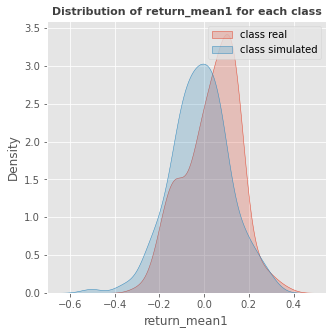

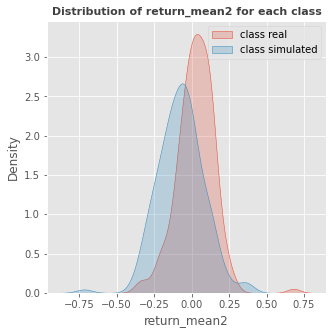

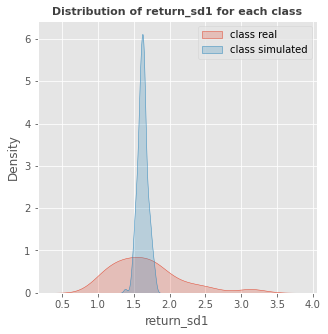

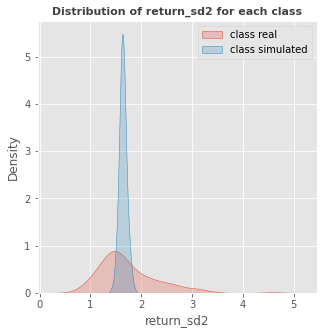

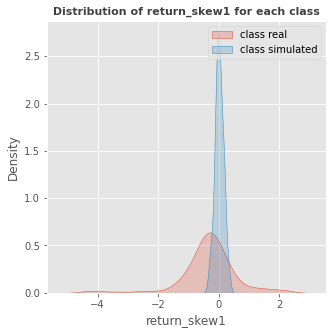

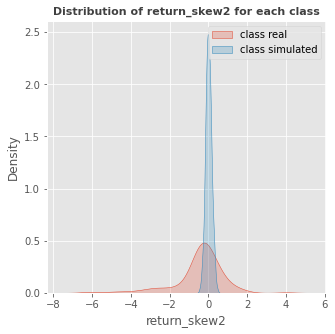

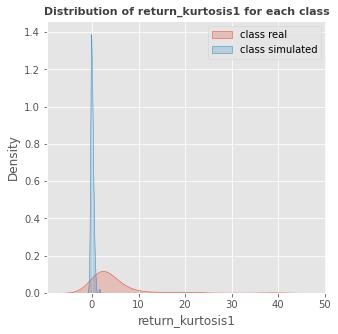

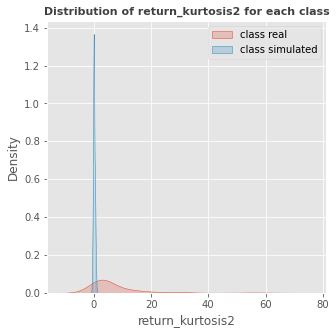

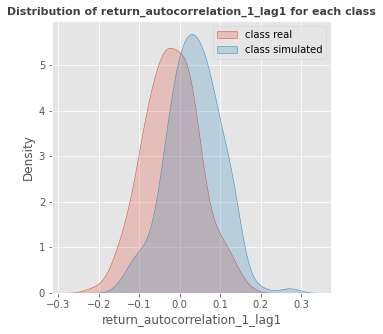

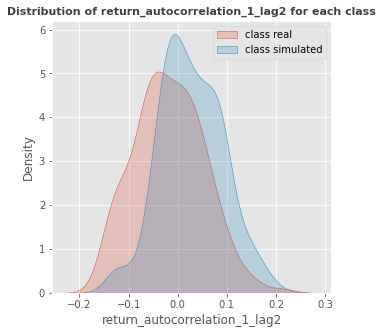

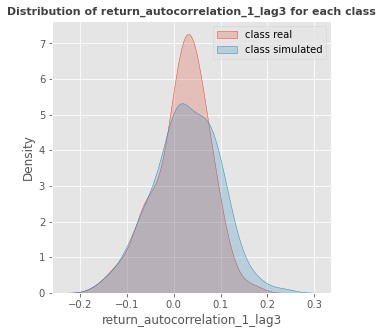

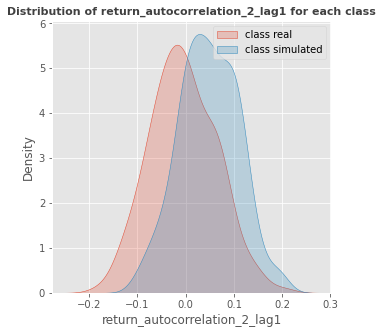

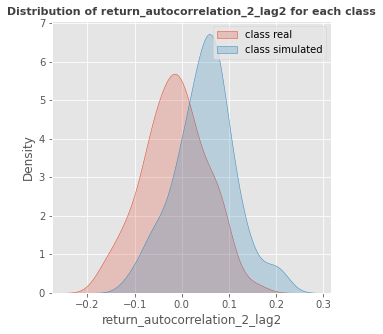

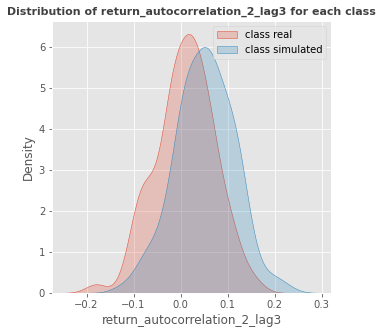

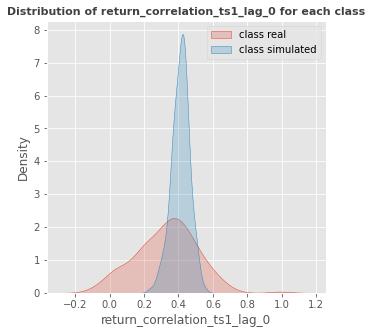

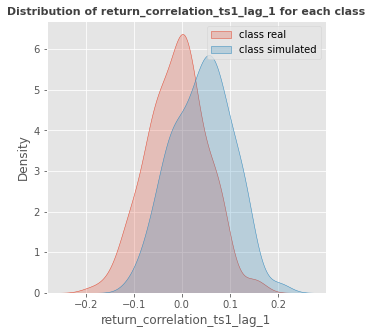

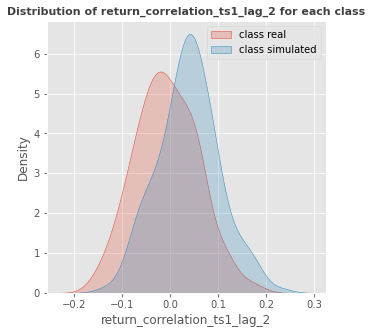

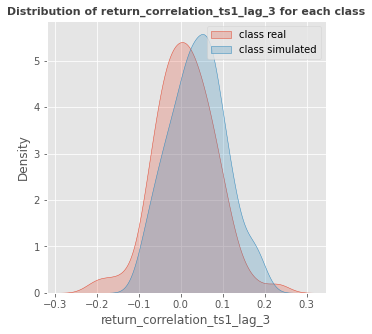

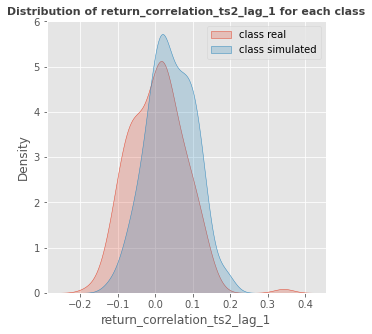

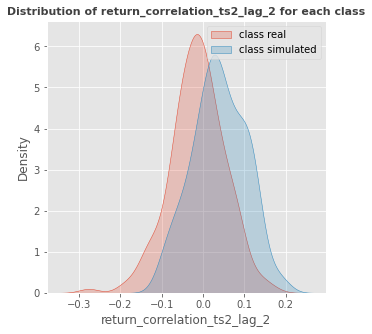

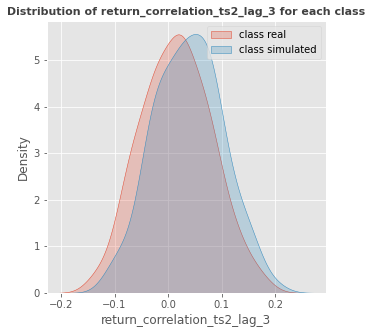

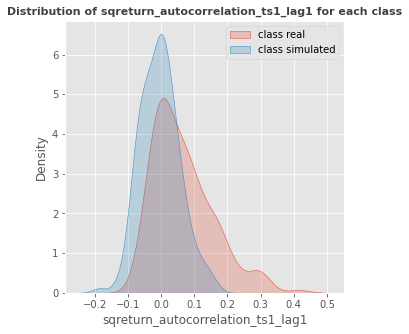

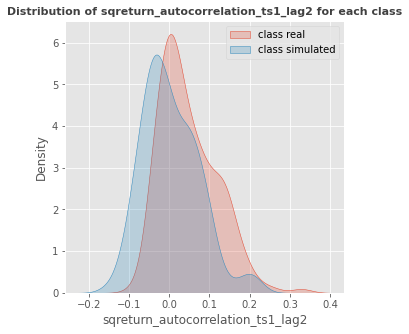

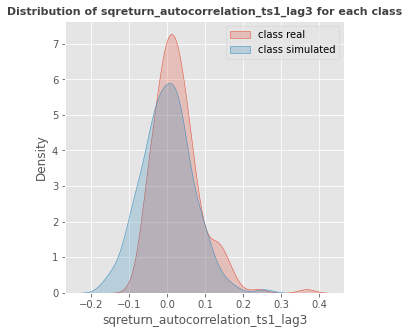

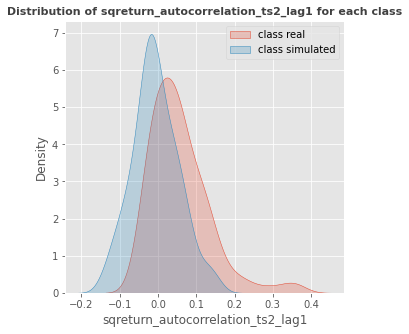

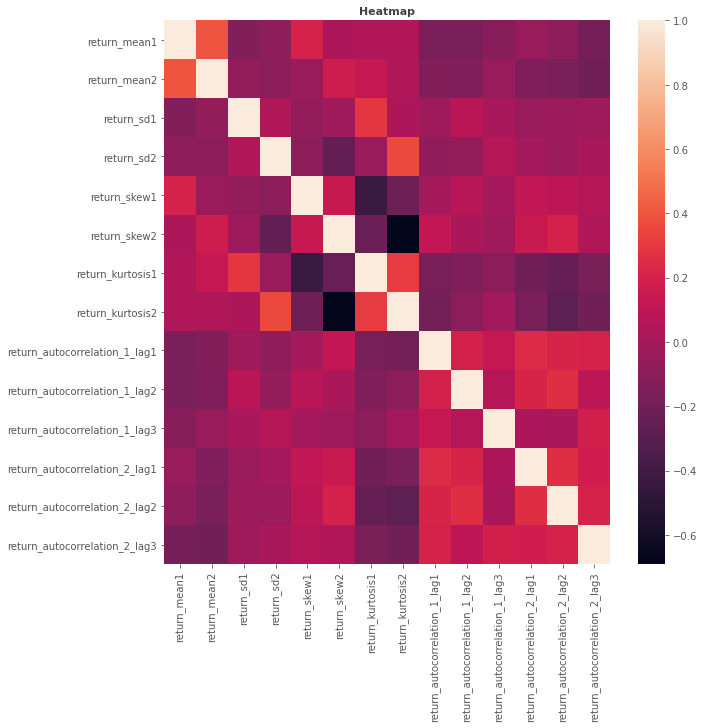

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_ou_log_prices = n_ou_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu12=params[1], 
    mu21=params[2], mu22=params[3],
    sigma11=params[4], sigma12=params[5], 
    sigma21=params[6], sigma22=params[7],
    xinit_vec=xinit_vec, T0=0, T=1, length=250)
    
    n_sim_ou_pair_prices = log_price_to_price(n_log_price=n_sim_ou_log_prices)
    n_sim_ou_pair_returns = price_to_return(n_price=n_sim_ou_pair_prices)
    
    n_sim_ou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")
    n_sim_ou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv")


    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")

    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_ou")


In [5]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9530201342281879, 0.9798657718120806, 0.9865771812080537, 0.9798657718120806, 0.9731543624161074]
0.974496644295302
0.011546745324889456
